In [ ]:
!pip install -q catboost
!pip install -q --upgrade sklearn==1.2.0

# Import Neccesary Libraries

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import os
import time

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set(
    style='ticks', 
    context='talk', 
    font_scale=0.8, 
    rc={'figure.figsize': (8,6)}
)

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from catboost import CatBoostClassifier

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif, RFECV, RFE, chi2

from sklearn.metrics import balanced_accuracy_score, accuracy_score, precision_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings("ignore")

# Load train and test 

From critical review of the data sictionary, we were able to detect redundant columns and exclude them from our analysis

In [2]:
# Read CSV file
train_data = pd.read_csv(r'C:\Users\kings\OneDrive - MMU\Desktop\bip-mental-health-technical-challenge\HDRUK_GROUP_4\training_set.csv')

# Filter based on DISPCODE, i.e completed surveys
train_data = train_data[train_data['DISPCODE'] == 1100]

# Drop specified columns
columns_to_drop = ['IDATE', 'FMONTH', 'IDAY',
                     'SEQNO', 'X_PSU', 'CTELENM1',
                     'STATERE1', 'CELPHON1', 'COLGSEX', 'NUMADULT',
                      'NUMMEN', 'NUMWOMEN', 'RESPSLCT',
                     'SAFETIME', 'CTELNUM1', 'CELLFON5', 'CSTATE1',
                     "LANDLINE", "HHADULT", "CELLSEX", "LANDSEX", "BPMEDS",
                     "CHOLMED3", "ASTHNOW", "ARTHEXER", "ARTHEDU", "LMTJOIN3",
                     "ARTHDIS2", "NUMHHOL3", "NUMPHON3", "AVEDRNK3", "DRNK3GE5",
                     "MAXDRNKS", "FLSHTMY3", "IMFVPLA2", "FRENCHF1", "HAVECFS",
                     "WORKCFS", 'TOLDHEPC', "TRETHEPC", "PRIRHEPC", "MEDSHEPB",
                     "HPVADSHT", "LCSFIRST", "LCSLAST", "LCSNUMCG", "HOWLONG",
                     "CRVCLCNC", "PSATIME1", "PCPSARS2", "PCSTALK", "HADSIGM4",
                     "COLNTES1", "SIGMTES1", "LASTSIG4", "COLNCNCR", "VCLNTES1",
                     "STOLTEST", "BLDSTFIT", "SDNATES1", "CSRVSUM", "CSRVRTRN", "CSRVINST",
                     "CSRVCTL2", "CSRVCLIN", "CSRVPAIN", "CSRVCTL2", "HOMBPCHK",
                     "HOMRGCHK", "WHEREBP", "SHAREBP", "DRADVISE", "CDASSIST", "CDHELP", "CDHOUSE",
                     "CDSOCIAL", "CDDISCUS", "CRGVREL4", "CRGVLNG1", "CRGVHRS1", "CRGVPRB3",
                     "CRGVALZD", "CRGVPER1", "CRGVHOU1" , "CRGVEXPT", "USEMRJN3", "LASTSMK2", "STOPSMK2",
                     "GUNLOAD", "LOADULK2", "RCSRLTN2", "CASTHDX2", "CASTHNO2", "QSTVER",
                     "QSTLANG", "MSCODE", "X_STSTR", "X_STRWT", "X_RAWRAKE", "X_WT2RAKE", "X_CHISPNC",
                     "X_CRACE1", "X_CPRACE1", "CAGEG", "X_CLLCPWT", "X_DUALUSE", "X_DUALCOR",
                     "X_LLCPWT2", "X_LLCPWT", "X_MRACE1", "X_HISPANC", "X_RACE", "X_RACEG21", "X_RACEGR3", "X_RACEPRV",
                     "X_AGEG5YR", "X_AGE80", "X_AGE_G", "HTIN4", "HTM4", "WTKG3", "X_BMI5", "X_RFSMOK3", "X_CURECI1",
                     "DROCDY3_", "X_RFBING5", "X_DRNKWK1", "X_RFDRHV7", "X_MISFRT1", "X_MISVEG1",
                     "X_FRTRES1", "X_VEGRES1", "X_FRTLT1A", "X_VEGLT1A", "X_FRT16A", "X_VEG23A", "X_FRUITE1", "X_VEGETE1",
                     "GENHLTH", "PHYSHLTH",  "PRIMINSR", "EXERANY2","BPHIGH6",   "CHOLCHK3", "CVDINFR4",  "CVDCRHD4", "ASTHMA3",
                     "HAVARTH5", "BIRTHSEX", "EDUCA", "CHILDREN", "INCOME3", "SMOKE100",
                     "ECIGNOW1", "ALCDAY5", "HIVTST7", "FRUIT2",   "FRUITJU2","FVGREEN1",  "POTATOE1", "VEGETAB2", "Record_ID"]
train_data = train_data.drop(columns=columns_to_drop)

# Write filtered DataFrame to a new CSV file
train_data.to_csv('new_train.csv', index=False)

In [3]:
train_data = pd.read_csv("new_train.csv")
train_data.head()

,X_STATE,IMONTH,IYEAR,DISPCODE,PVTRESD1,COLGHOUS,LADULT1,CADULT1,PVTRESD3,CCLGHOUS,...,X_AIDTST4,FTJUDA2_,FRUTDA2_,GRENDA1_,FRNCHDA_,POTADA1_,VEGEDA2_,X_FRUTSU1,X_VEGESU1,Outcome
0,29,11,2021,1100,NaN,NaN,NaN,1.0,1.0,NaN,...,9.0,NaN,14.0,100.0,0.0,0.0,100.0,NaN,200.0,Neg
1,28,3,2021,1100,NaN,NaN,NaN,1.0,1.0,NaN,...,1.0,0.0,200.0,33.0,10.0,17.0,100.0,200.0,160.0,Pos
2,19,8,2021,1100,NaN,NaN,NaN,1.0,1.0,NaN,...,2.0,0.0,43.0,3.0,7.0,2.0,14.0,43.0,26.0,Neg
3,27,9,2021,1100,NaN,NaN,NaN,1.0,1.0,NaN,...,1.0,3.0,7.0,29.0,100.0,100.0,50.0,10.0,279.0,Pos
4,50,4,2021,1100,NaN,NaN,NaN,1.0,1.0,NaN,...,1.0,200.0,500.0,300.0,100.0,500.0,600.0,700.0,1500.0,Pos


## **Data Exporation and Cleaning**

In [4]:
# Change the headers to lowercase
train_data.columns = train_data.columns.str.lower()

In [5]:
# Generarl information about the train set
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65802 entries, 0 to 65801
Columns: 127 entries, x_state to outcome
dtypes: float64(92), int64(34), object(1)
memory usage: 63.8+ MB


In [6]:
# Display the number rows and column
train_data.shape

(65802, 127)

# Quick Visualization on Demography

In [7]:
def countplot(df, col):
    """Create a count plot to visualize the distribution of outcomes for a specified column.

    Args:
    - df (pd.DataFrame): A DataFrame containing the data.
    - col (str): The column in the DataFrame to be plotted on the x-axis.
    """
    plot = sns.countplot(data=df, x=col, hue="outcome", palette=['#0288D1', '#B3E5FC'])

    plot.set_xticklabels(plot.get_xticklabels())
    plot.set_title(f"{col.upper()} column value counts with Outcome", weight='bold')
    plt.show();


#### Year

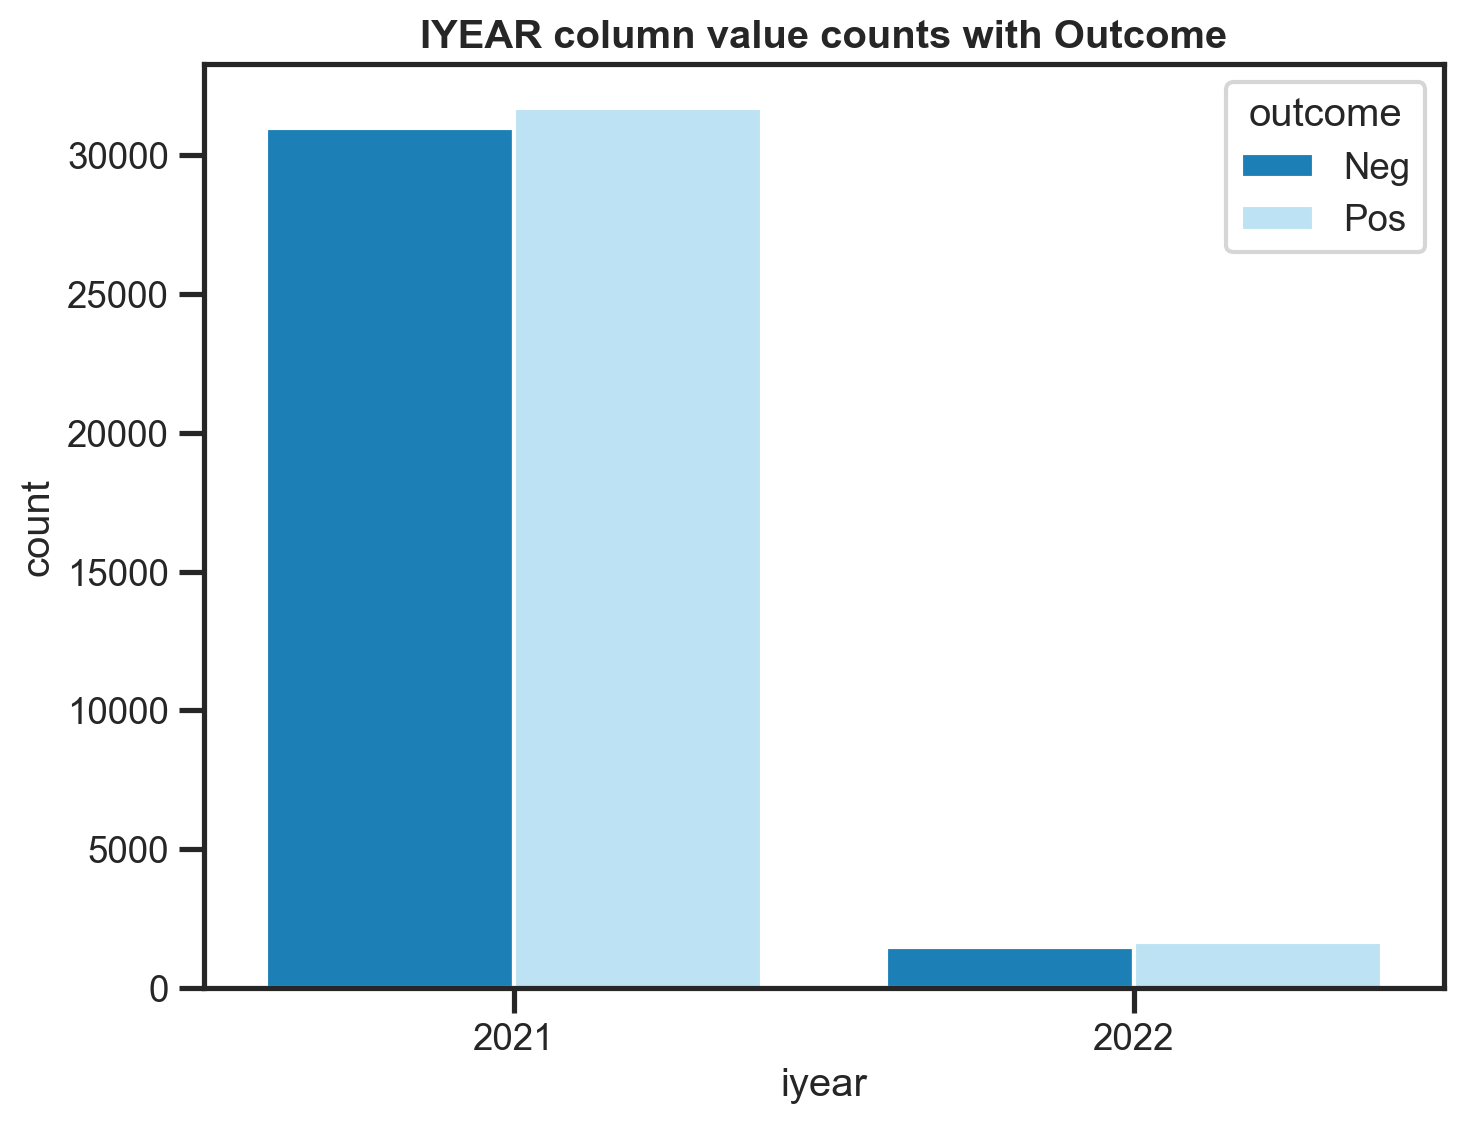

In [8]:
countplot(train_data, 'iyear')

#### Gender
 
Male = 1

Female = 2

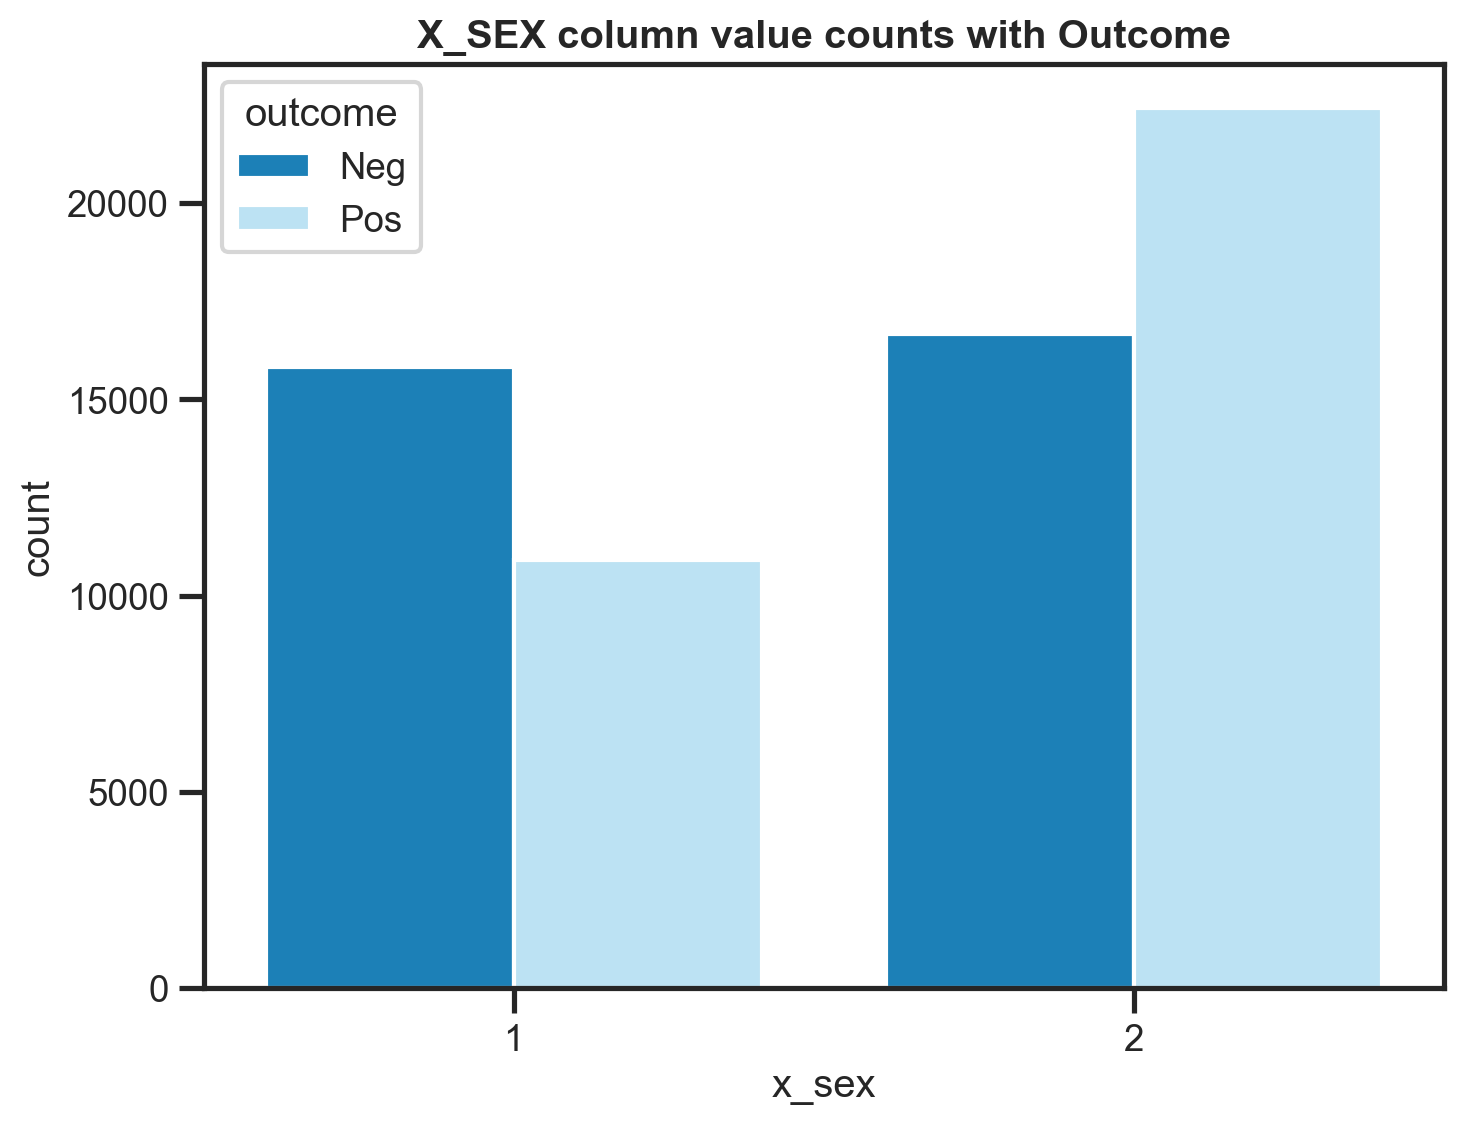

In [9]:
countplot(train_data, 'x_sex')

#### Age groups

group 1 = 18 - 64

group 2 = 65 >

group 3 = info not provided

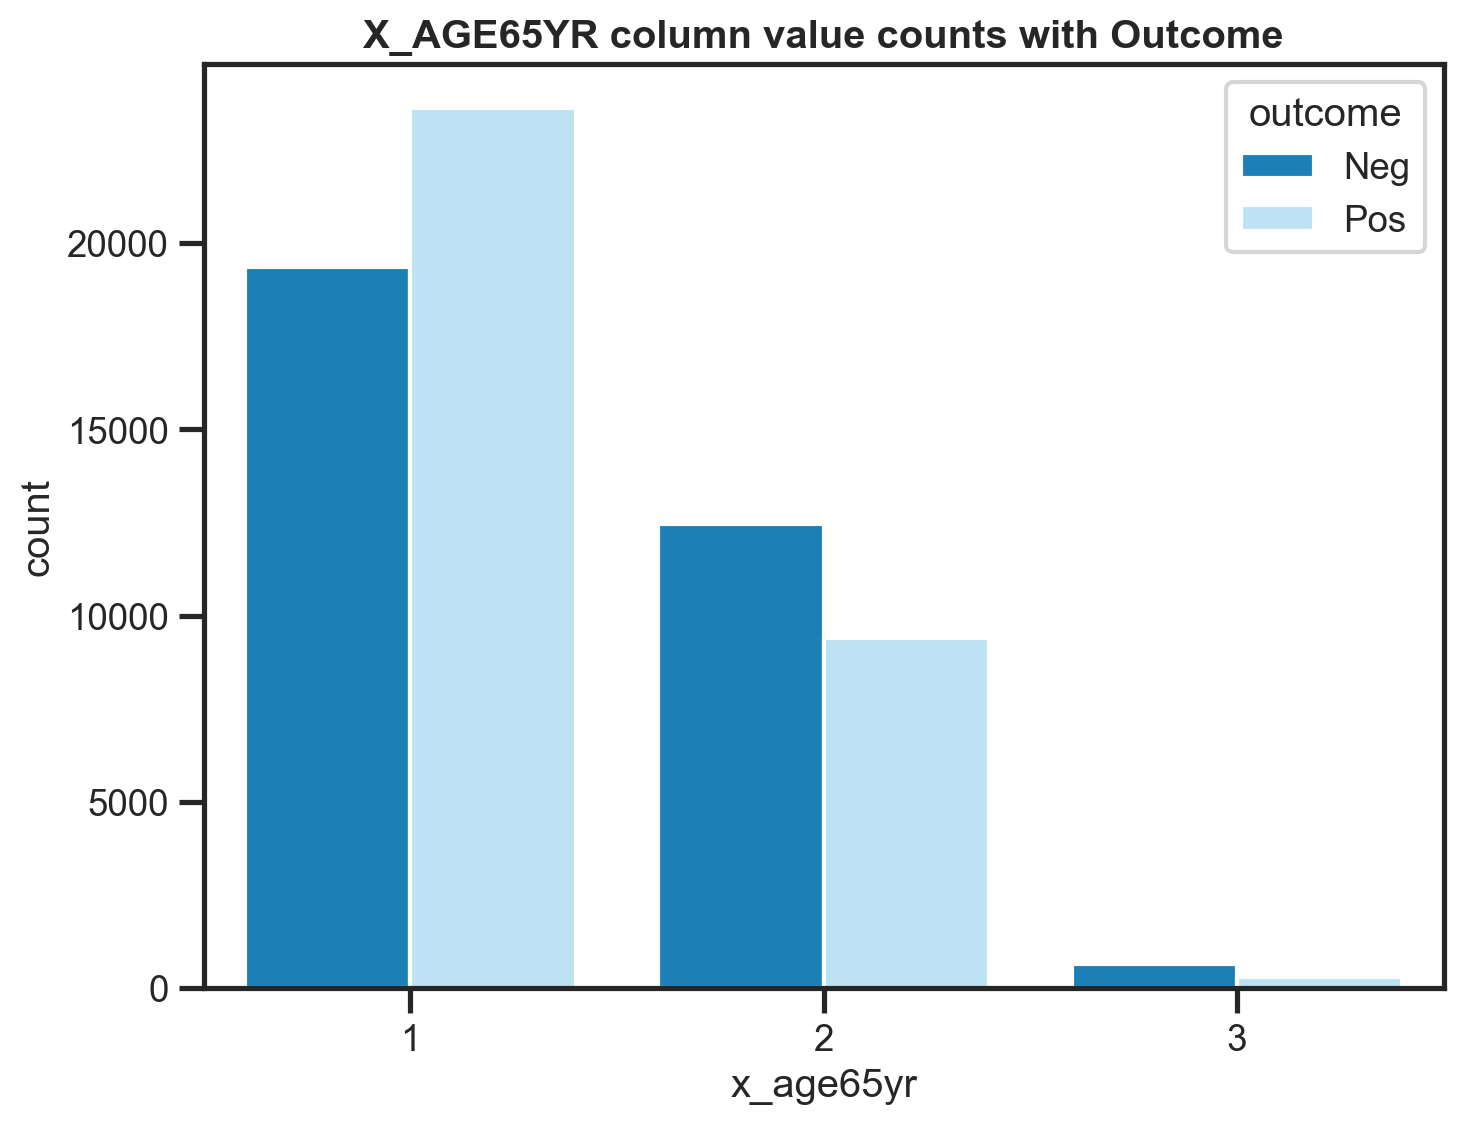

In [10]:
countplot(train_data, 'x_age65yr')


#### BMI

1 = underweight

2 = normal weight

3 = overweight

4 = obese

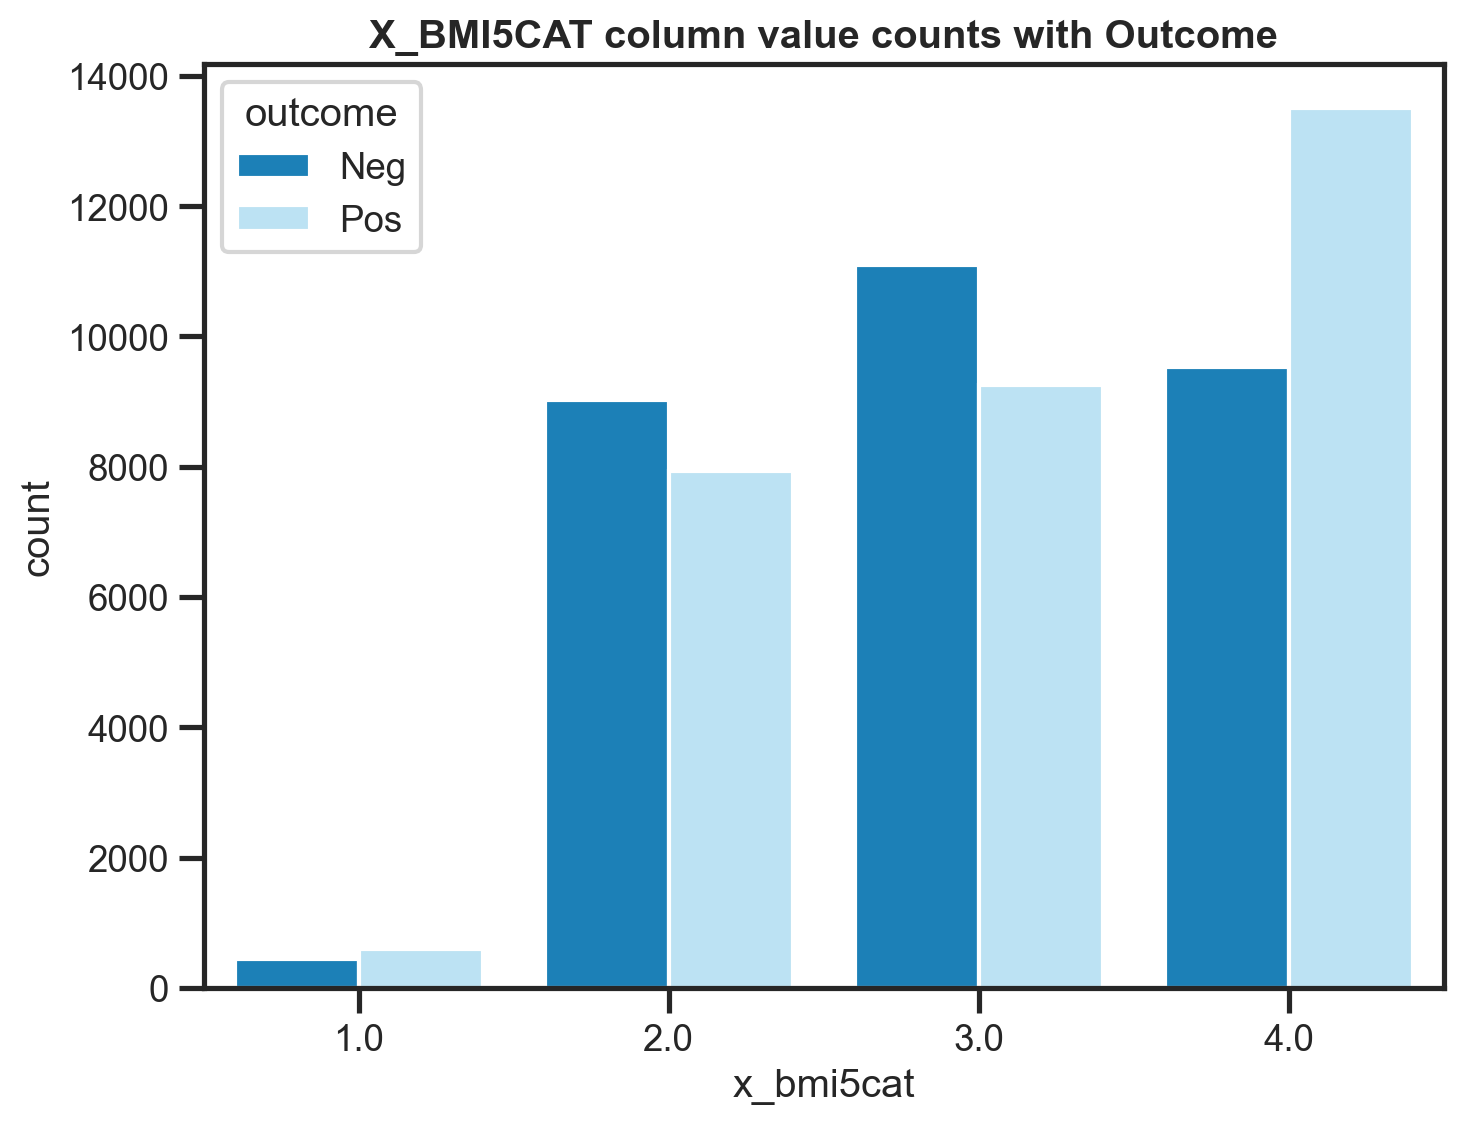

In [11]:
countplot(train_data, 'x_bmi5cat')

#### Marital

1 = married

2 = divorced

3 = widowed

4 = separated

5 = never married

6 = unmarried couple

9 = refused

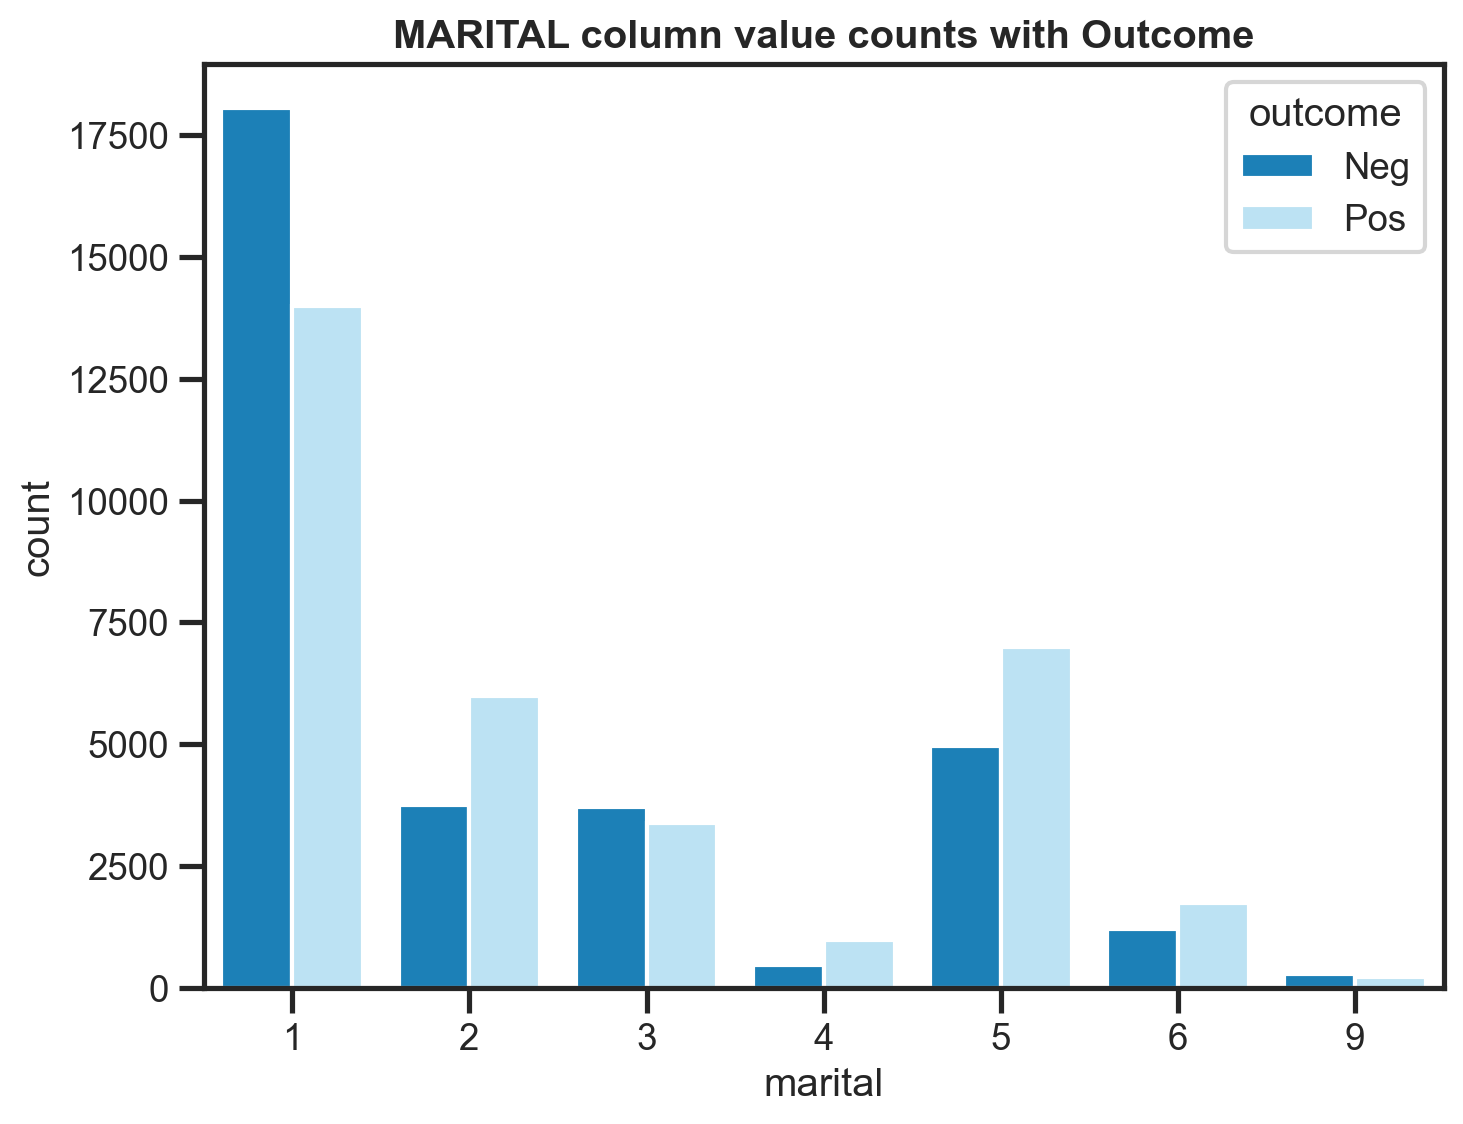

In [12]:
countplot(train_data, 'marital')

In [13]:
# Display number of empty cells in each column
print(train_data.shape)
train_data.isnull().sum().sort_values(ascending=False).head(10)

(65802, 127)


toldcfs     65802
colghous    65798
havehepc    65768
cclghous    65651
psatest1    65472
vircolo1    65469
stooldn1    65469
smalstol    65469
csrvdein    65073
csrvdoc1    65073
dtype: int64

### Deleting Columns with null values up to 50000 and above


In [14]:
# Drop column with empty cell above 50000
train_data.dropna(thresh=50000, inplace=True, axis=1)
print(train_data.shape)

# Display column according to number of null values in decreasing order
train_data.isnull().sum().sort_values(ascending=False).head(20)

(65802, 68)


x_rfchol3    8807
toldhi3      8761
x_bmi5cat    4387
x_vegesu1    2972
x_frutsu1    2201
frutda2_     1364
potada1_     1342
ftjuda2_     1200
vegeda2_     1164
grenda1_     1059
x_urbstat    1032
x_metstat    1032
frnchda_      944
x_michd       746
x_drdxar3     414
x_lmtwrk3     414
x_lmtact3     414
x_aidtst4       1
medcost1        1
x_cholch3       0
dtype: int64

### Value Counts for the columns with null values

In [15]:
def null_counts(df):
    """Print value counts of non-null and null values for columns with missing data in a DataFrame.

    Args:
        df (pd.DataFrame): A DataFrame containing the data.

    Returns:
        columns_with_nulls (list): A list of column names with missing values

    """

    # Get a Series containing the count of null values in each column
    null_counts = df.isnull().sum()

    # Sort the columns based on the number of null values in descending order and get the columns
    columns_with_nulls = null_counts[null_counts > 0].sort_values(ascending=False).index.tolist()

    # Create a dictionary to store value_counts for each column
    value_counts_dict = {}

    # Iterate through columns with null values and compute value_counts
    for column in columns_with_nulls:
        value_counts_dict[column] = df[column].value_counts(dropna=False)

    # Printing the value_counts for each column with null values in descending order of null values
    for column in columns_with_nulls:
        value_counts = value_counts_dict[column]
        print(f"Value counts for column '{column}' (Null Count: {null_counts[column]}):\n{value_counts}\n")

    return columns_with_nulls

In [16]:
columns_with_nulls = null_counts(train_data)

Value counts for column 'x_rfchol3' (Null Count: 8807):
1.0    31774
2.0    24741
NaN     8807
9.0      480
Name: x_rfchol3, dtype: int64

Value counts for column 'toldhi3' (Null Count: 8761):
2.0    31819
1.0    24742
NaN     8761
7.0      434
9.0       46
Name: toldhi3, dtype: int64

Value counts for column 'x_bmi5cat' (Null Count: 4387):
4.0    23041
3.0    20362
2.0    16965
NaN     4387
1.0     1047
Name: x_bmi5cat, dtype: int64

Value counts for column 'x_vegesu1' (Null Count: 2972):
NaN        2972
200.0      1441
157.0      1351
143.0      1092
186.0       986
           ... 
476.0         1
12084.0       1
1216.0        1
9985.0        1
791.0         1
Name: x_vegesu1, Length: 1261, dtype: int64

Value counts for column 'x_frutsu1' (Null Count: 2201):
100.0     8770
200.0     6923
300.0     3150
43.0      3002
NaN       2201
          ... 
3020.0       1
923.0        1
141.0        1
383.0        1
380.0        1
Name: x_frutsu1, Length: 438, dtype: int64

Value counts for co

In [17]:
len(columns_with_nulls)

19

### Grouping the 19 columns into categorical and continuous columns and replacing nulls values, 9, and 7 in the categorical columns with respective mode and null values in the continuous columns with respective mean or median (depending on outliers)

In [18]:
# Identify the data types of columns to distinguish between continuous and categorical
continuous_columns = []
categorical_columns = []

for column in train_data.columns[train_data.columns.isin(columns_with_nulls)]:
    if train_data[column].nunique() <= 4:
        # for null columns, columns with less than or equal to 4 unique values are categorical
        categorical_columns.append(column)
    else:
        continuous_columns.append(column)

In [19]:
print(
    f"number of contious columns with missing values = {len(continuous_columns)}\n"
      f"number of contious columns with missing values = {len(categorical_columns)}"
      )

number of contious columns with missing values = 8
number of contious columns with missing values = 11


In [20]:
def fill_null_values(df, columns_with_nulls):
    """Fill missing values of columns with the right approach.

    Args:
        df (pd.DataFrame): A DataFrame containing the data.
        columns_with_nulls (list): A list of column names with missing values.

    Returns:
        replacement_values_dict (dict): A dictionary that holds the replacement values for each column.
        
    """
    continuous_columns = []
    categorical_columns = []

    for column in df.columns[df.columns.isin(columns_with_nulls)]:
        if df[column].nunique() <= 4:
            # for null columns, columns with less than or equal to 4 unique values are categorical
            categorical_columns.append(column)
        else:
            continuous_columns.append(column)
    # Create a dictionary to store the replacement values for each column
    replacement_values_dict = {}

    print("Columns and Method to replace missing values")
    
    # Automate the replacement of null values
    for column in categorical_columns:
        replacement_values_dict[column] = df[column].mode().iloc[0]
        # columns and mode of fillina missing values
        print(f"'{column}': (Replaced with Mode)")

    for column in continuous_columns:
        if df[column].isnull().any():
            # Check for outliers using Z-score
            z_scores = np.abs(stats.zscore(df[column].dropna()))
            is_outlier = z_scores > 3  # Adjust the threshold as needed
            if is_outlier.any():
                # Replace null values with median if outliers are present
                replacement_values_dict[column] = df[column].median()
                # Print value_counts for replaced column
                print(f"'{column}': (Replaced with Median)")
            else:
                # Replace null values with mean if no outliers are present
                replacement_values_dict[column] = df[column].mean()
                # Print value_counts for replaced column
                print(f"'{column}': (Replaced with Mean)")
    return replacement_values_dict
replacement_values_dict = fill_null_values(train_data, columns_with_nulls)

Columns and Method to replace missing values
'medcost1': (Replaced with Mode)
'toldhi3': (Replaced with Mode)
'x_metstat': (Replaced with Mode)
'x_urbstat': (Replaced with Mode)
'x_rfchol3': (Replaced with Mode)
'x_michd': (Replaced with Mode)
'x_drdxar3': (Replaced with Mode)
'x_lmtact3': (Replaced with Mode)
'x_lmtwrk3': (Replaced with Mode)
'x_bmi5cat': (Replaced with Mode)
'x_aidtst4': (Replaced with Mode)
'ftjuda2_': (Replaced with Median)
'frutda2_': (Replaced with Median)
'grenda1_': (Replaced with Median)
'frnchda_': (Replaced with Median)
'potada1_': (Replaced with Median)
'vegeda2_': (Replaced with Median)
'x_frutsu1': (Replaced with Median)
'x_vegesu1': (Replaced with Median)


In [21]:
# Replace null values in the DataFrame with the respective mode/median/mean
train_data.fillna(replacement_values_dict, inplace=True)

In [22]:
# Print first 5 rows of the clean dataset
train_data.head()

,x_state,imonth,iyear,dispcode,sexvar,persdoc3,medcost1,checkup1,toldhi3,cvdstrk3,...,x_aidtst4,ftjuda2_,frutda2_,grenda1_,frnchda_,potada1_,vegeda2_,x_frutsu1,x_vegesu1,outcome
0,29,11,2021,1100,2,1,1.0,1,1.0,2,...,9.0,3.0,14.0,100.0,0.0,0.0,100.0,100.0,200.0,Neg
1,28,3,2021,1100,1,1,2.0,1,2.0,2,...,1.0,0.0,200.0,33.0,10.0,17.0,100.0,200.0,160.0,Pos
2,19,8,2021,1100,1,1,2.0,1,2.0,2,...,2.0,0.0,43.0,3.0,7.0,2.0,14.0,43.0,26.0,Neg
3,27,9,2021,1100,1,2,2.0,1,1.0,2,...,1.0,3.0,7.0,29.0,100.0,100.0,50.0,10.0,279.0,Pos
4,50,4,2021,1100,2,1,2.0,1,1.0,2,...,1.0,200.0,500.0,300.0,100.0,500.0,600.0,700.0,1500.0,Pos


In [23]:
train_data.isnull().sum().any()

False

### Exploring the cleaned dataset and delecting any redundant columns using the data dictionary

In [24]:
train_data.shape

(65802, 68)

In [25]:
# Display all column names
train_data.columns

Index(['x_state', 'imonth', 'iyear', 'dispcode', 'sexvar', 'persdoc3',
       'medcost1', 'checkup1', 'toldhi3', 'cvdstrk3', 'chcscncr', 'chcocncr',
       'chccopd3', 'chckdny2', 'marital', 'renthom1', 'cpdemo1b', 'veteran3',
       'employ1', 'weight2', 'height3', 'deaf', 'blind', 'decide', 'diffwalk',
       'diffdres', 'diffalon', 'usenow3', 'flushot7', 'pneuvac4', 'x_metstat',
       'x_urbstat', 'x_imprace', 'x_rfhlth', 'x_phys14d', 'x_hlthpln',
       'x_hcvu652', 'x_totinda', 'x_rfhype6', 'x_cholch3', 'x_rfchol3',
       'x_michd', 'x_ltasth1', 'x_casthm1', 'x_asthms1', 'x_drdxar3',
       'x_lmtact3', 'x_lmtwrk3', 'x_prace1', 'x_sex', 'x_age65yr', 'x_bmi5cat',
       'x_rfbmi5', 'x_chldcnt', 'x_educag', 'x_incomg1', 'x_smoker3',
       'drnkany5', 'x_aidtst4', 'ftjuda2_', 'frutda2_', 'grenda1_', 'frnchda_',
       'potada1_', 'vegeda2_', 'x_frutsu1', 'x_vegesu1', 'outcome'],
      dtype='object')

In [26]:
def get_nunique_values(df, cols, threshold):
    """
    Check number of unique values in each columns by setting a threshold
    """
    for col in cols:
        if df[col].nunique() > threshold:
            print(f'{col} = {df[col].nunique()}')

In [27]:
# columns with unique values greater than 10
get_nunique_values(train_data, train_data.columns[:-1], 10)

x_state = 53
imonth = 12
weight2 = 416
height3 = 95
ftjuda2_ = 79
frutda2_ = 97
grenda1_ = 91
frnchda_ = 78
potada1_ = 79
vegeda2_ = 97
x_frutsu1 = 437
x_vegesu1 = 1260


#### Normalizing column units

#### Height3

* 200 - 711 Height (ft/inches)
    Notes: 0 _ / _ _ = feet / inches
* 7777 Don’t know/Not sure 
* 9061 -9998
    Height (meters/centimeters)
    Notes: The initial ´9 ´ indicates this was a
    metric value.
* 9999 Refused 

In [28]:
train_data['height3'].value_counts()

506.0     6054
504.0     6029
505.0     5429
507.0     5144
503.0     4926
          ... 
9200.0       1
9188.0       1
9147.0       1
701.0        1
9100.0       1
Name: height3, Length: 95, dtype: int64

In [29]:
train_data[train_data['height3'].astype(str).str.startswith('9')]['height3']

71       9150.0
195      9158.0
228      9151.0
233      9999.0
261      9999.0
          ...  
65590    9999.0
65629    9999.0
65747    9999.0
65782    9160.0
65788    9999.0
Name: height3, Length: 988, dtype: float64

In [30]:
train_data[train_data['height3'].astype(str).str.startswith('77')]['height3']

248      7777.0
288      7777.0
502      7777.0
534      7777.0
546      7777.0
          ...  
65058    7777.0
65328    7777.0
65558    7777.0
65567    7777.0
65713    7777.0
Name: height3, Length: 441, dtype: float64

In [31]:
x = train_data['height3'].apply(lambda x : ''.join(str(int(x))[0]+'.' + str(int(x))[1:] if not str(int(x)).startswith('9') and not str(int(x)).startswith('77') else str(int(x))))
pd.DataFrame(x).query('height3>"7"')

,height3
71,9150
195,9158
228,9151
233,9999
248,7777
...,...
65629,9999
65713,7777
65747,9999
65782,9160


In [32]:
# seperate the feet from the inches using a period(.)
train_data['height3'] = train_data['height3'].apply(lambda x : ''.join(str(int(x))[0]+'.' + str(int(x))[1:] if not str(int(x)).startswith('9') and not str(int(x)).startswith('77') else str(int(x))))

In [33]:
train_data['height3'].value_counts()

5.06    6054
5.04    6029
5.05    5429
5.07    5144
5.03    4926
        ... 
9200       1
9188       1
9147       1
7.01       1
9100       1
Name: height3, Length: 95, dtype: int64

##### do convert all feet inches to centimeters i.e value with 2 decimal

In [34]:
train_data['height3'] = train_data['height3'].astype(float)
train_data[train_data['height3'].astype(str).str.startswith('9')]['height3']

71       9150.0
195      9158.0
228      9151.0
233      9999.0
261      9999.0
          ...  
65590    9999.0
65629    9999.0
65747    9999.0
65782    9160.0
65788    9999.0
Name: height3, Length: 988, dtype: float64

In [35]:
train_data[train_data['height3'].astype(str).str.startswith('77')]['height3']

248      7777.0
288      7777.0
502      7777.0
534      7777.0
546      7777.0
          ...  
65058    7777.0
65328    7777.0
65558    7777.0
65567    7777.0
65713    7777.0
Name: height3, Length: 441, dtype: float64

In [36]:
train_data['height3'].describe()

count    65802.000000
mean       204.203605
std       1343.582701
min          3.000000
25%          5.040000
50%          5.060000
75%          5.100000
max       9999.000000
Name: height3, dtype: float64

In [37]:
train_data.iloc[37146]['height3']

3.0

In [38]:
def ft_inch_to_cm(df, col):
    """
    Convert height in ft/inches to centimeters
    """

    df = df.copy()
    df[['ft','inch']] = df[col].astype(str).str.split('.',expand=True)
    df['ft'] = df['ft']
    df['inch'] = df['inch'].astype(int)
    df['inch'] = df['inch'].apply(lambda x: float(f"0.{x:02}"))
    df = df[['ft','inch']]

    results = []
    for i, j in df.iterrows():
        if j['ft'].startswith('9') or j['ft'].startswith('77') :
            results.append(j['ft'])
        else:
            j['ft'] = int(j['ft'])
            inches = j['ft'] * 12 + j['inch']
            cm = round(inches * 2.54)
            results.append(cm)  
    return results

In [39]:
# converting ft/inches to centimeters
train_data['height3'] = ft_inch_to_cm(train_data, 'height3')

In [40]:
train_data[train_data['height3'].astype(str).str.startswith('9')]['height3']

71       9150
195      9158
228      9151
233      9999
261      9999
         ... 
65590    9999
65629    9999
65747    9999
65782    9160
65788    9999
Name: height3, Length: 997, dtype: object

In [41]:
train_data[train_data['height3'].astype(float)<100]['height3']

7365     91
15770    91
23151    91
25837    91
26162    91
30710    91
37146    91
45637    91
54522    92
Name: height3, dtype: object

In [42]:
train_data[train_data['height3'].astype(str).str.startswith('777')]['height3']

248      7777
288      7777
502      7777
534      7777
546      7777
         ... 
65058    7777
65328    7777
65558    7777
65567    7777
65713    7777
Name: height3, Length: 441, dtype: object

In [43]:
train_data[train_data['height3'].astype(str).str.startswith('9')]['height3'].unique()

array(['9150', '9158', '9151', '9999', '9169', '9175', '9172', '9164',
       '9154', '9167', '9165', '9160', '9168', '9138', '9147', '9162',
       '9188', '9173', '9152', '9176', '9200', 91, '9180', '9157', '9199',
       '9170', '9178', '9155', '9156', '9161', '9153', '9105', '9190',
       '9171', '9145', '9185', '9159', '9174', '9146', '9163', '9166',
       '9189', '9125', '9177', '9140', '9117', '9143', '9182', '9103',
       '9149', 92, '9179', '9130', '9100'], dtype=object)

In [44]:
train_data['height3']

0        153
1        183
2        152
3        183
4        152
        ... 
65797    152
65798    153
65799    153
65800    153
65801    183
Name: height3, Length: 65802, dtype: object

In [45]:
x = 91
[int(str(int(x))[1:]) if str(int(x)).startswith('9') and len(str(x)) > 4 else x]

[91]

In [46]:
# removing the first 9 from each values
train_data['height3'] = train_data['height3'].apply(lambda x : int(str(int(x))[1:]) if str(int(x)).startswith('9') and len(str(x)) > 4 else x)

In [47]:
train_data['height3'][71]

'9150'

In [48]:
train_data[train_data['height3'].astype(str).str.startswith('9')]['height3'].unique()

array(['9150', '9158', '9151', '9999', '9169', '9175', '9172', '9164',
       '9154', '9167', '9165', '9160', '9168', '9138', '9147', '9162',
       '9188', '9173', '9152', '9176', '9200', 91, '9180', '9157', '9199',
       '9170', '9178', '9155', '9156', '9161', '9153', '9105', '9190',
       '9171', '9145', '9185', '9159', '9174', '9146', '9163', '9166',
       '9189', '9125', '9177', '9140', '9117', '9143', '9182', '9103',
       '9149', 92, '9179', '9130', '9100'], dtype=object)

In [49]:
train_data[train_data['height3'].astype(str).str.startswith('7')]['height3'].unique()

array(['7777'], dtype=object)

In [50]:
train_data['height3'].astype(float).describe()

count    65802.000000
mean       352.156728
std       1321.718621
min         91.000000
25%        152.000000
50%        153.000000
75%        153.000000
max       9999.000000
Name: height3, dtype: float64

In [51]:
train_data['height3'] = train_data['height3'].astype(float)

<Axes: ylabel='height3'>

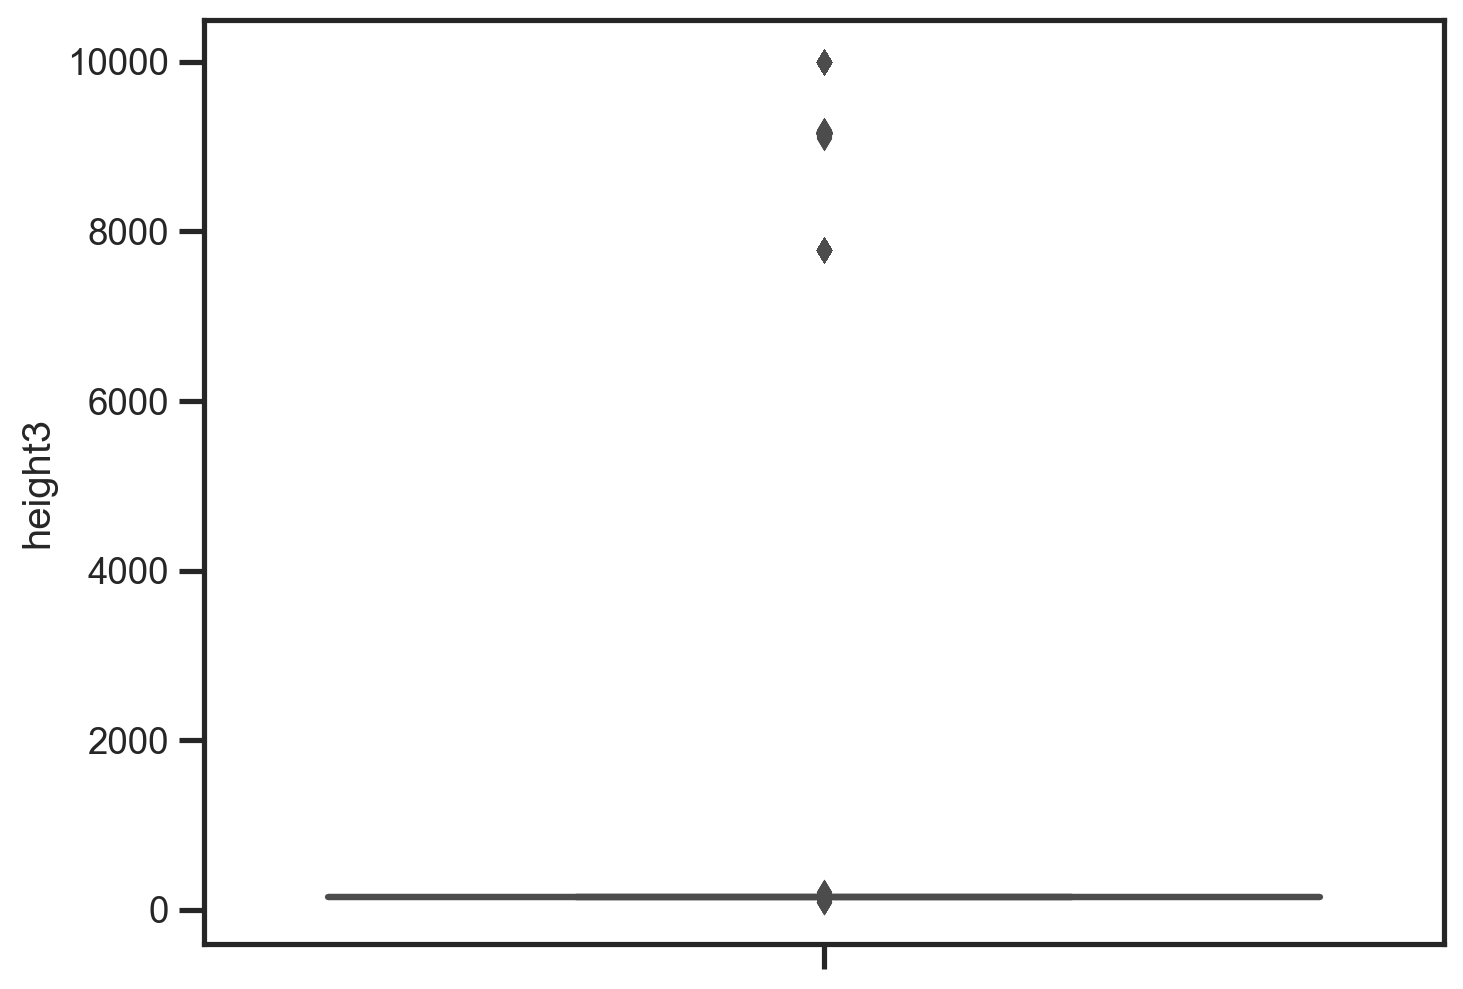

In [52]:
sns.boxplot(y=train_data['height3'])

#### Weight2

* 0 - 0776 Weight (pounds)
    Notes: 0 _ _ _ = weight in pounds
* 7777 Don’t know/Not sure 
* 9023 - 9352 Weight (kilograms)
    Notes: The initial ´9´ indicates this was a
    metric value.
* 9999 Refused

In [53]:
train_data['weight2'].value_counts()

200.0     3220
180.0     2887
160.0     2572
150.0     2551
9999.0    2492
          ... 
9081.0       1
610.0        1
530.0        1
9154.0       1
9067.0       1
Name: weight2, Length: 416, dtype: int64

In [54]:
train_data[train_data['weight2'].astype(str).str.startswith('9')]['weight2']

19       9999.0
49       9999.0
72       9999.0
135      9999.0
195      9051.0
          ...  
65674    9999.0
65747    9999.0
65774    9999.0
65779      92.0
65788    9999.0
Name: weight2, Length: 2869, dtype: float64

In [55]:
train_data[train_data['weight2'].astype(str).str.startswith('99')]['weight2']

19       9999.0
49       9999.0
72       9999.0
135      9999.0
205      9999.0
          ...  
65671    9999.0
65674    9999.0
65747    9999.0
65774    9999.0
65788    9999.0
Name: weight2, Length: 2515, dtype: float64

In [56]:
train_data['weight2'].min()

55.0

In [57]:
train_data['weight2'].value_counts()

200.0     3220
180.0     2887
160.0     2572
150.0     2551
9999.0    2492
          ... 
9081.0       1
610.0        1
530.0        1
9154.0       1
9067.0       1
Name: weight2, Length: 416, dtype: int64

In [58]:
train_data['weight2'].describe()

count    65802.000000
mean       711.260737
std       2137.419367
min         55.000000
25%        150.000000
50%        180.000000
75%        220.000000
max       9999.000000
Name: weight2, dtype: float64

In [59]:
train_data[~train_data['weight2'].astype(str).str.startswith('999')]['weight2']

0        214.0
1        313.0
2        300.0
3        258.0
4        150.0
         ...  
65797    125.0
65798    180.0
65799    200.0
65800    215.0
65801    260.0
Name: weight2, Length: 63310, dtype: float64

In [60]:
train_data[train_data['weight2'].astype(str).str.startswith('7777')]['weight2']

21       7777.0
40       7777.0
44       7777.0
50       7777.0
71       7777.0
          ...  
65535    7777.0
65606    7777.0
65652    7777.0
65713    7777.0
65772    7777.0
Name: weight2, Length: 1177, dtype: float64

In [61]:
train_data['weight2'][1304]

90.0

In [62]:
round(55.0/2.2046)

25

In [63]:
def pounds_to_kg(df, col):
    """
    Convert weight in pounds to kilograms
    """

    df = df.copy()
    df = df[[col]]

    results = []

    for i in df[col]:
        if str(i).startswith('9'):
            results.append(i)
        elif  str(i).startswith('7777'):
            results.append(i)
        else:
            kg = round(i / 2.2046)
            results.append(kg)  
    return results

In [64]:
train_data['weight2'].sort_values(ascending=True)

56480      55.0
38403      60.0
58848      60.0
36035      67.0
37230      68.0
          ...  
41720    9999.0
41723    9999.0
20400    9999.0
36411    9999.0
14128    9999.0
Name: weight2, Length: 65802, dtype: float64

In [65]:
pounds_to_kg(train_data, 'weight2')

[97,
 142,
 136,
 117,
 68,
 49,
 86,
 78,
 109,
 91,
 147,
 91,
 105,
 62,
 132,
 68,
 77,
 47,
 143,
 9999.0,
 118,
 7777.0,
 77,
 77,
 68,
 100,
 145,
 59,
 76,
 77,
 77,
 63,
 68,
 130,
 50,
 100,
 67,
 59,
 45,
 84,
 7777.0,
 91,
 61,
 47,
 7777.0,
 104,
 95,
 61,
 57,
 9999.0,
 7777.0,
 66,
 106,
 77,
 100,
 86,
 93,
 107,
 91,
 59,
 91,
 70,
 113,
 77,
 103,
 94,
 86,
 88,
 136,
 77,
 77,
 7777.0,
 9999.0,
 64,
 109,
 90,
 79,
 116,
 86,
 68,
 145,
 70,
 66,
 64,
 59,
 145,
 70,
 100,
 68,
 117,
 78,
 59,
 95,
 68,
 40,
 61,
 93,
 101,
 7777.0,
 77,
 98,
 62,
 59,
 75,
 73,
 109,
 82,
 116,
 98,
 70,
 63,
 84,
 82,
 80,
 73,
 141,
 64,
 60,
 97,
 125,
 109,
 88,
 109,
 66,
 82,
 52,
 98,
 109,
 95,
 60,
 59,
 68,
 132,
 88,
 70,
 9999.0,
 82,
 82,
 79,
 63,
 134,
 58,
 98,
 73,
 91,
 91,
 68,
 83,
 82,
 113,
 78,
 66,
 60,
 100,
 63,
 61,
 59,
 102,
 58,
 86,
 79,
 109,
 109,
 68,
 112,
 54,
 95,
 94,
 73,
 91,
 59,
 68,
 81,
 73,
 82,
 64,
 113,
 73,
 82,
 104,
 68,
 64,
 86,
 

In [66]:
pd.Series(pounds_to_kg(train_data, 'weight2')).min()

25.0

In [67]:
# converting ft/inches to centimeters
train_data['weight2'] = pounds_to_kg(train_data, 'weight2')

In [68]:
# train_data['weight2'] = train_data['weight2'].astype(str).str.strip().astype(float)

In [69]:
train_data[train_data['weight2'].astype(str).str.startswith('9')]['weight2'].unique()

array([  97.,   91., 9999.,   95.,   93.,   94.,   90.,   98., 9051.,
         96., 9066.,   99.,   92., 9090., 9068., 9078., 9046., 9070.,
       9071., 9085., 9065., 9083., 9088., 9041., 9060., 9082., 9087.,
       9073., 9079., 9096., 9056., 9055., 9080., 9084., 9086., 9100.,
       9075., 9165., 9072., 9118., 9094., 9154., 9069., 9081., 9045.,
       9105., 9092., 9048., 9059., 9114., 9098., 9115., 9050., 9095.,
       9076., 9116., 9063., 9127., 9053., 9058., 9052., 9067.])

In [70]:
train_data[train_data['weight2'].astype(str).str.startswith('7')]['weight2']

7          78.0
16         77.0
21       7777.0
22         77.0
23         77.0
          ...  
65786      79.0
65789      77.0
65790      77.0
65791      75.0
65796      77.0
Name: weight2, Length: 13713, dtype: float64

In [71]:
x = 9090.000
[int(str(int(x))[1:]) if str(int(x)).startswith('9') and len(str(x)) > 4 else x]

[90]

In [72]:
# removing the first 9 from each values
train_data['weight2'] = train_data['weight2'].apply(lambda x : int(str(int(x))[1:]) if str(int(x)).startswith('9') and len(str(x)) > 4 else x)

In [73]:
train_data[train_data['weight2'].astype(str).str.startswith('9')]['weight2'].unique()

array([ 97.,  91., 999.,  95.,  93.,  94.,  90.,  98.,  96.,  99.,  92.])

In [74]:
# removing the 7777 from each values
train_data['weight2'] = train_data['weight2'].apply(lambda x : int(str(int(x))[1:]) if str(int(x)).startswith('7') and len(str(x)) > 4 else x)

In [75]:
train_data[train_data['weight2'].astype(str).str.startswith('7')]['weight2'].unique()

array([ 78.,  77., 777.,  76.,  70.,  79.,  75.,  73.,  72.,  74.,  71.])

In [76]:
train_data['weight2'].value_counts()

91.0     3301
82.0     2969
73.0     2905
68.0     2735
77.0     2572
         ... 
277.0       1
240.0       1
178.0       1
228.0       1
352.0       1
Name: weight2, Length: 198, dtype: int64

In [77]:
train_data[train_data['weight2'].astype(str).str.startswith('9')]['weight2']

0         97.0
9         91.0
11        91.0
19       999.0
41        91.0
         ...  
65779     92.0
65784     93.0
65788    999.0
65799     91.0
65800     98.0
Name: weight2, Length: 11079, dtype: float64

In [78]:
train_data[train_data['weight2'].astype(str).str.startswith('7')]['weight2']

7         78.0
16        77.0
21       777.0
22        77.0
23        77.0
         ...  
65786     79.0
65789     77.0
65790     77.0
65791     75.0
65796     77.0
Name: weight2, Length: 13755, dtype: float64

In [79]:
train_data['weight2'][71]

777.0

In [80]:
train_data['weight2'].describe()

count    65802.000000
mean       131.295614
std        196.276739
min         25.000000
25%         68.000000
50%         82.000000
75%        100.000000
max        999.000000
Name: weight2, dtype: float64

In [81]:
def get_nunique_cols(df, cols, threshold):
    """
    Check number of unique values in each columns by setting a threshold
    """
    cont_cols = []
    for col in cols:
        if df[col].nunique() > threshold:
            cont_cols.append(col)
    return cont_cols

In [82]:
cont_cols = get_nunique_cols(train_data, train_data.columns[:-1], 10)
cat_cols = [ i for i in  train_data.columns[:-1] if i not in cont_cols]

State and month are meant to be categorical

In [83]:
cat_cols.append(cont_cols.pop(0))
cat_cols.append(cont_cols.pop(0))

In [84]:
cont_cols

['weight2',
 'height3',
 'ftjuda2_',
 'frutda2_',
 'grenda1_',
 'frnchda_',
 'potada1_',
 'vegeda2_',
 'x_frutsu1',
 'x_vegesu1']

In [85]:
cat_cols

['iyear',
 'dispcode',
 'sexvar',
 'persdoc3',
 'medcost1',
 'checkup1',
 'toldhi3',
 'cvdstrk3',
 'chcscncr',
 'chcocncr',
 'chccopd3',
 'chckdny2',
 'marital',
 'renthom1',
 'cpdemo1b',
 'veteran3',
 'employ1',
 'deaf',
 'blind',
 'decide',
 'diffwalk',
 'diffdres',
 'diffalon',
 'usenow3',
 'flushot7',
 'pneuvac4',
 'x_metstat',
 'x_urbstat',
 'x_imprace',
 'x_rfhlth',
 'x_phys14d',
 'x_hlthpln',
 'x_hcvu652',
 'x_totinda',
 'x_rfhype6',
 'x_cholch3',
 'x_rfchol3',
 'x_michd',
 'x_ltasth1',
 'x_casthm1',
 'x_asthms1',
 'x_drdxar3',
 'x_lmtact3',
 'x_lmtwrk3',
 'x_prace1',
 'x_sex',
 'x_age65yr',
 'x_bmi5cat',
 'x_rfbmi5',
 'x_chldcnt',
 'x_educag',
 'x_incomg1',
 'x_smoker3',
 'drnkany5',
 'x_aidtst4',
 'x_state',
 'imonth']

#### check for outliers

In [86]:
def plot_boxplot(df, col, target):
    """Create a box plot by taking in three arguements:
        
    Args:
        df (pd.DataFrame): The dataframe 
        col (str): The column of interest
        target: The target column.
        
    """
    plt.figure(figsize=(8, 5))
    feature = df[col]
    target = df[target]
    sns.boxplot(data=df, y=feature, x=target)
    plt.title(col)    
    plt.show()

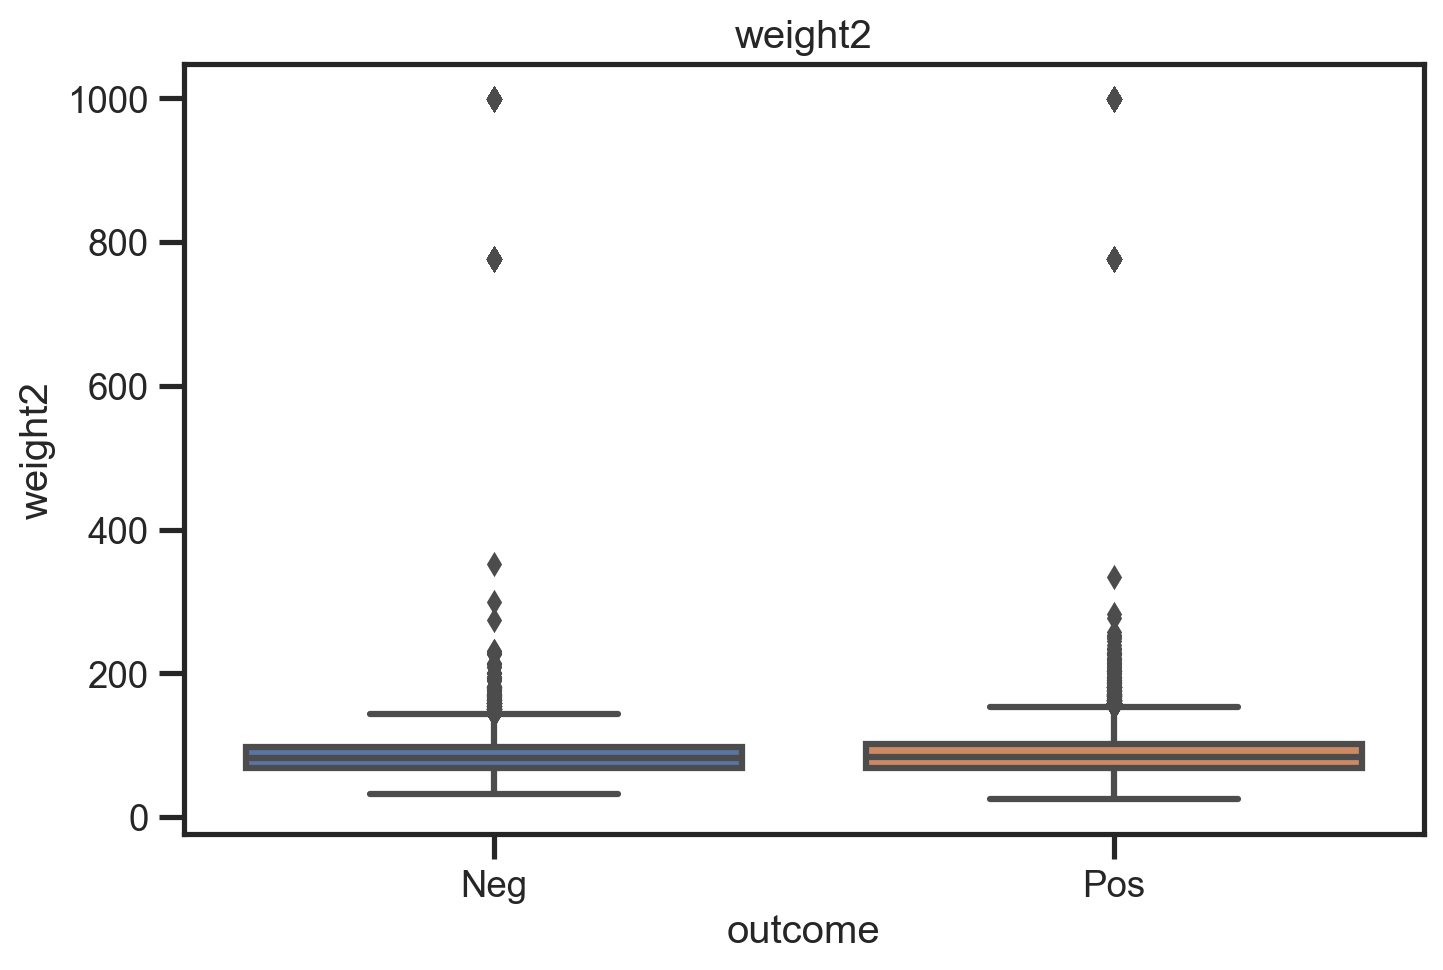

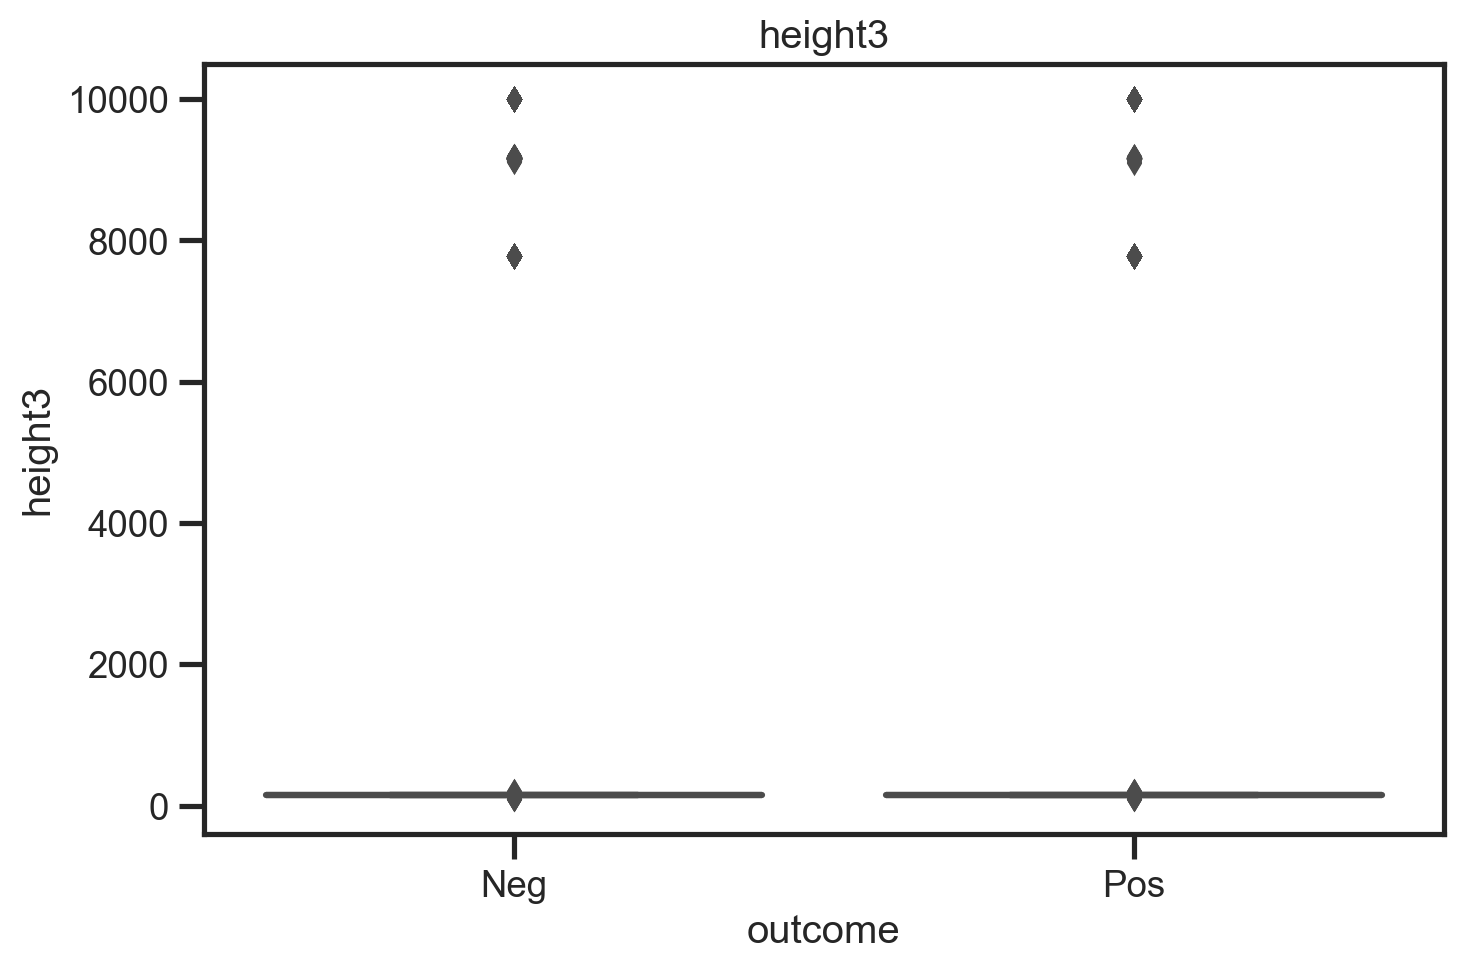

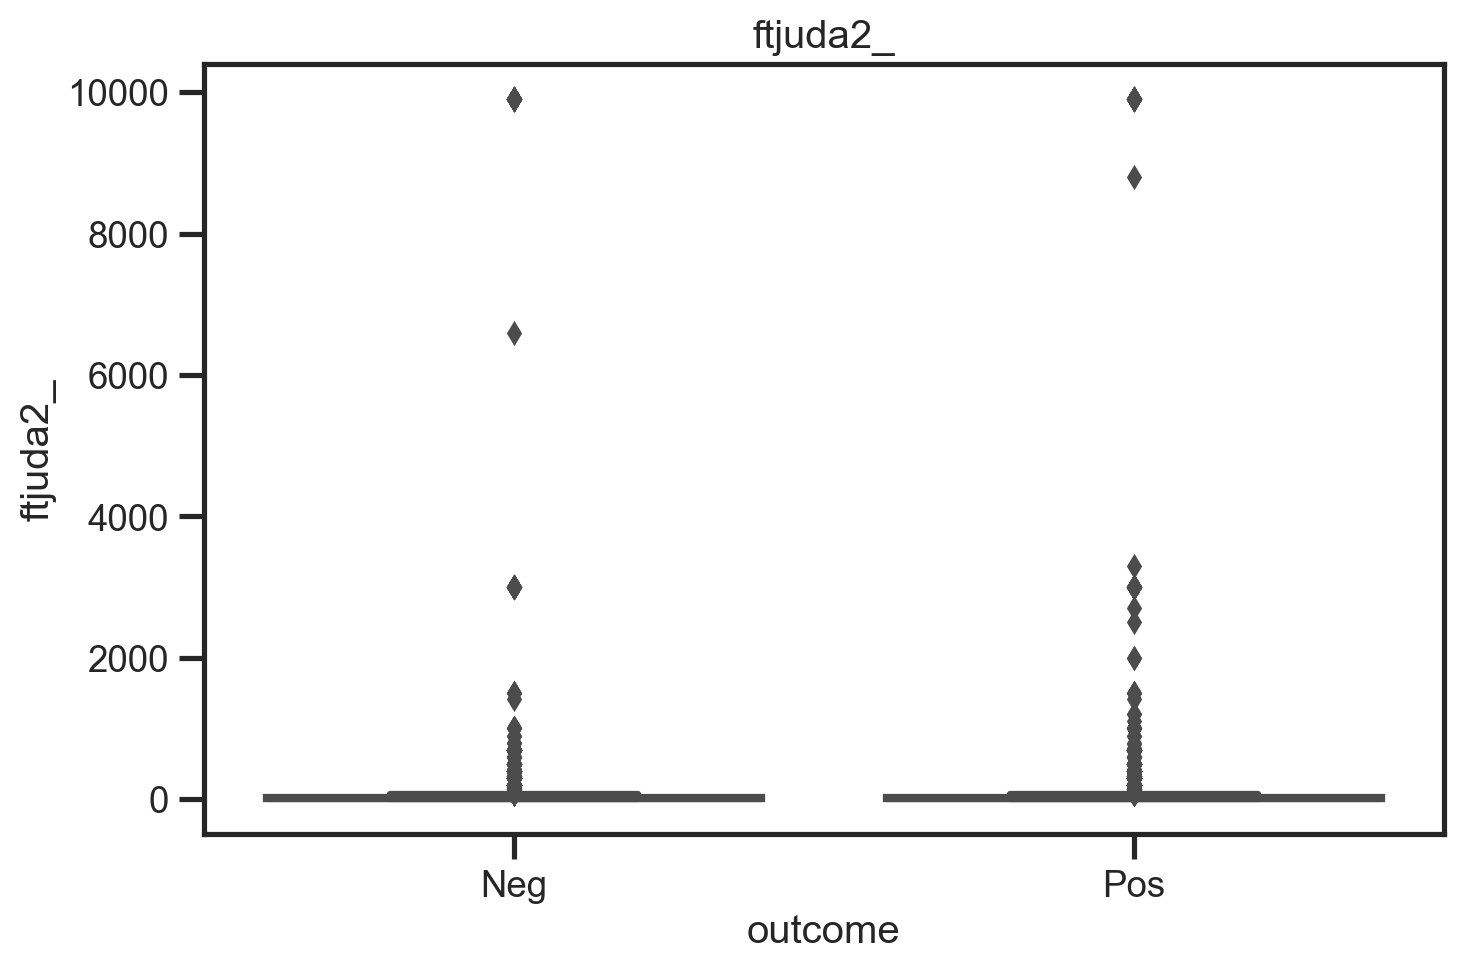

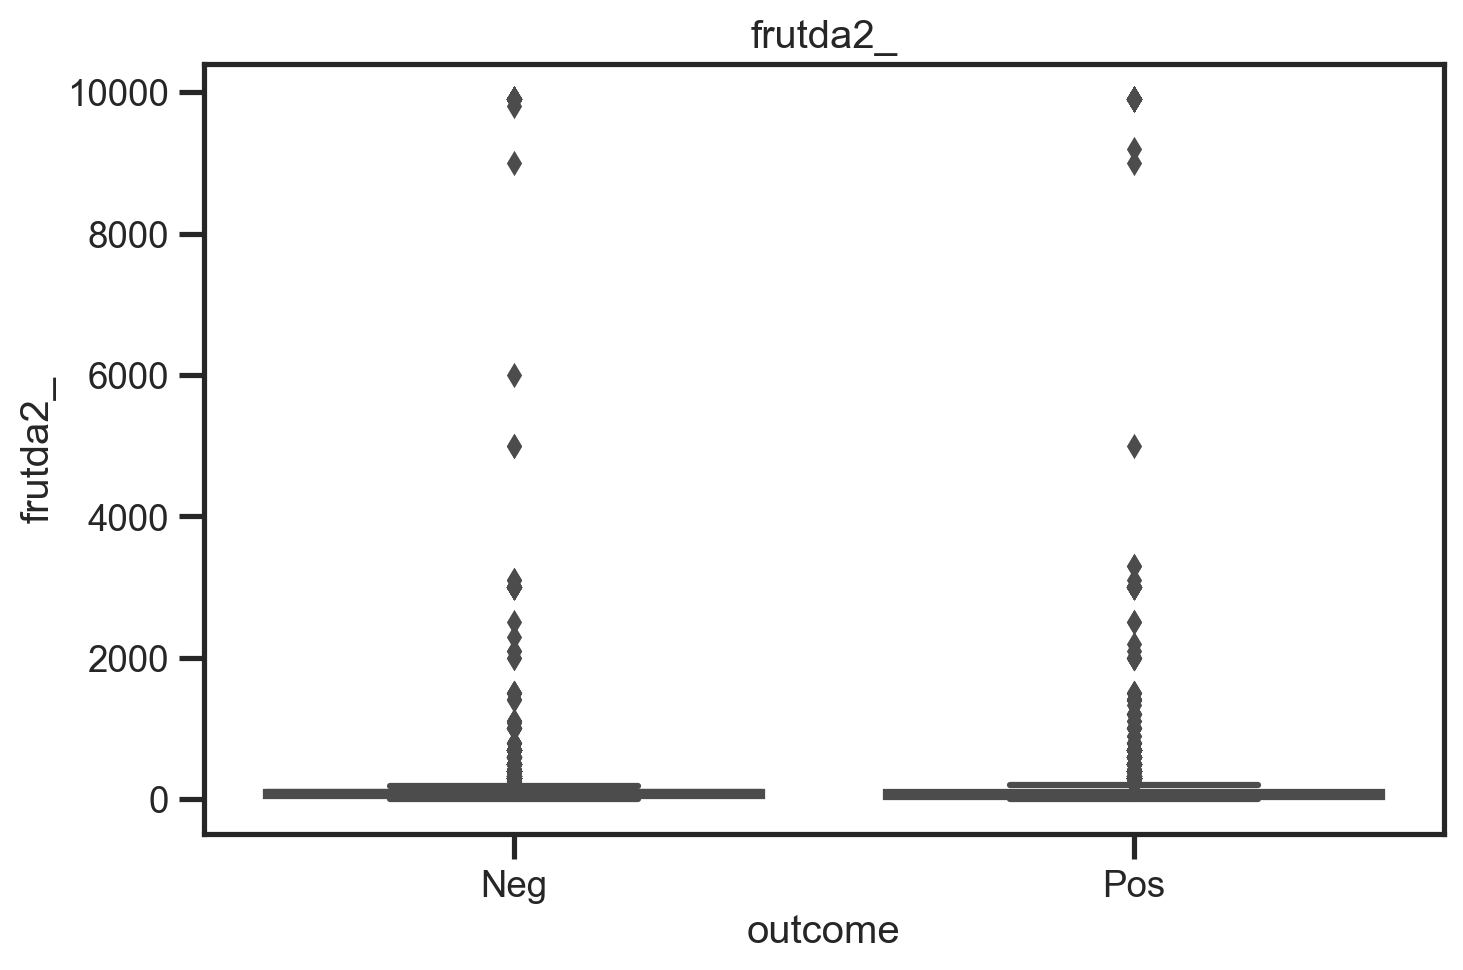

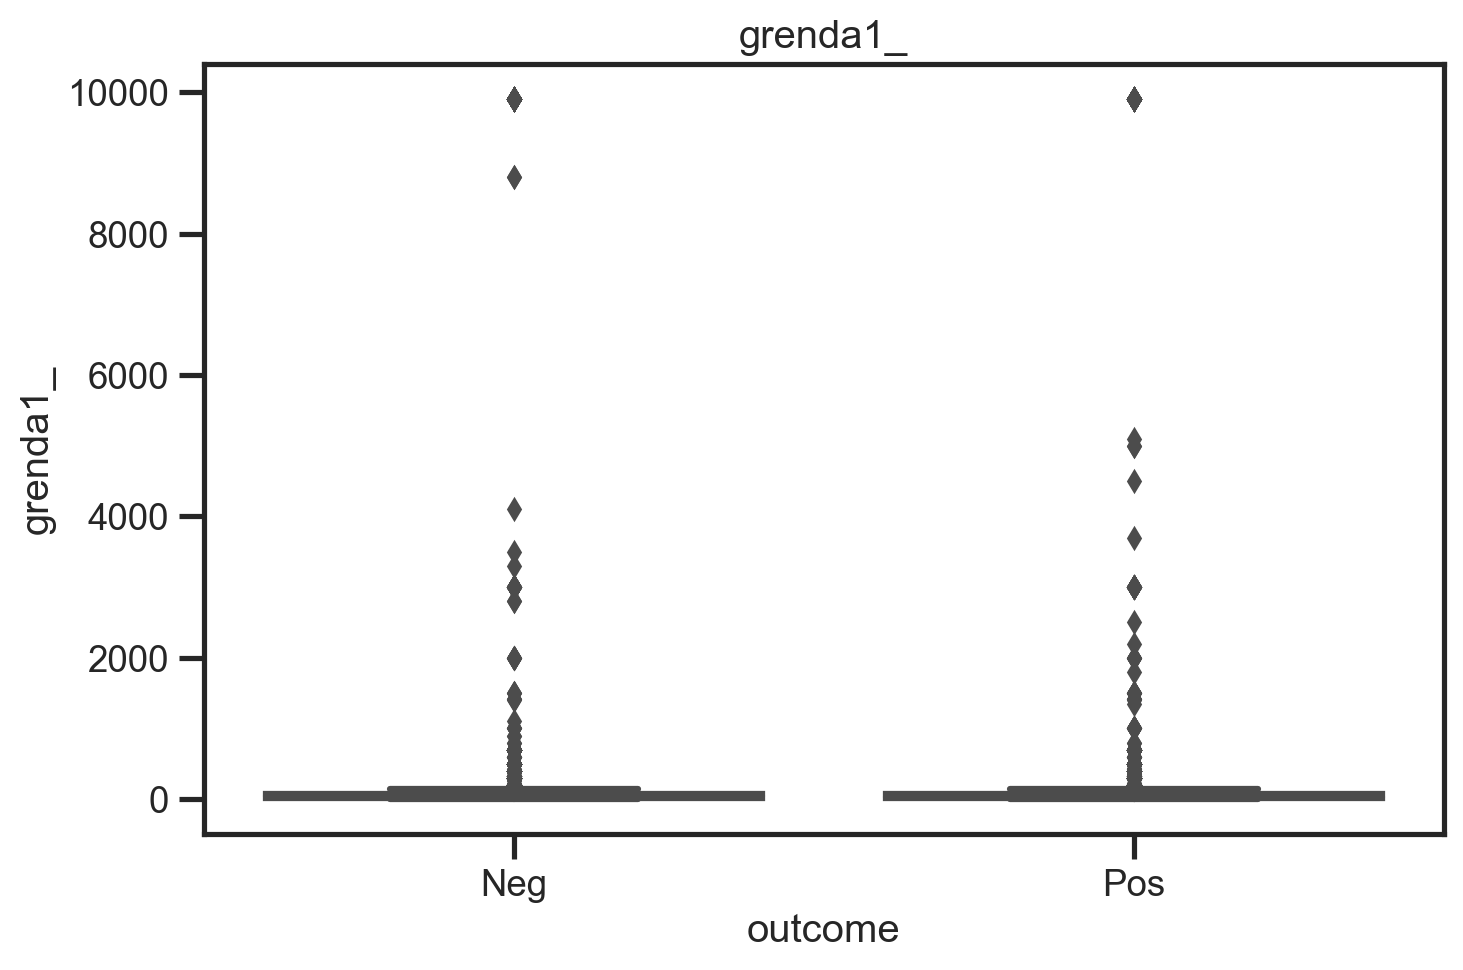

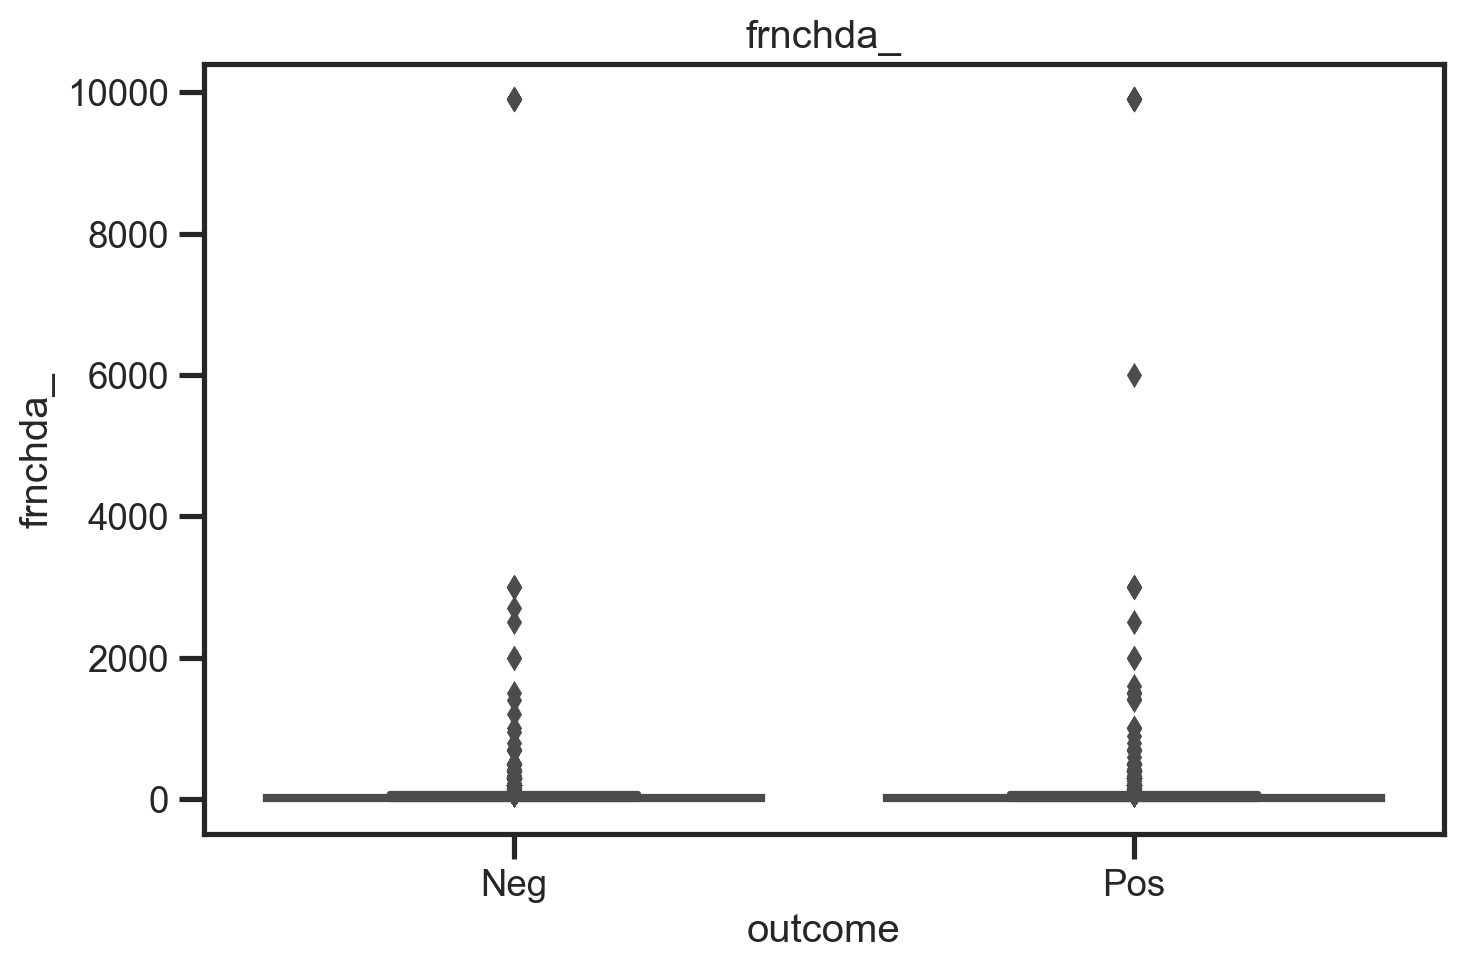

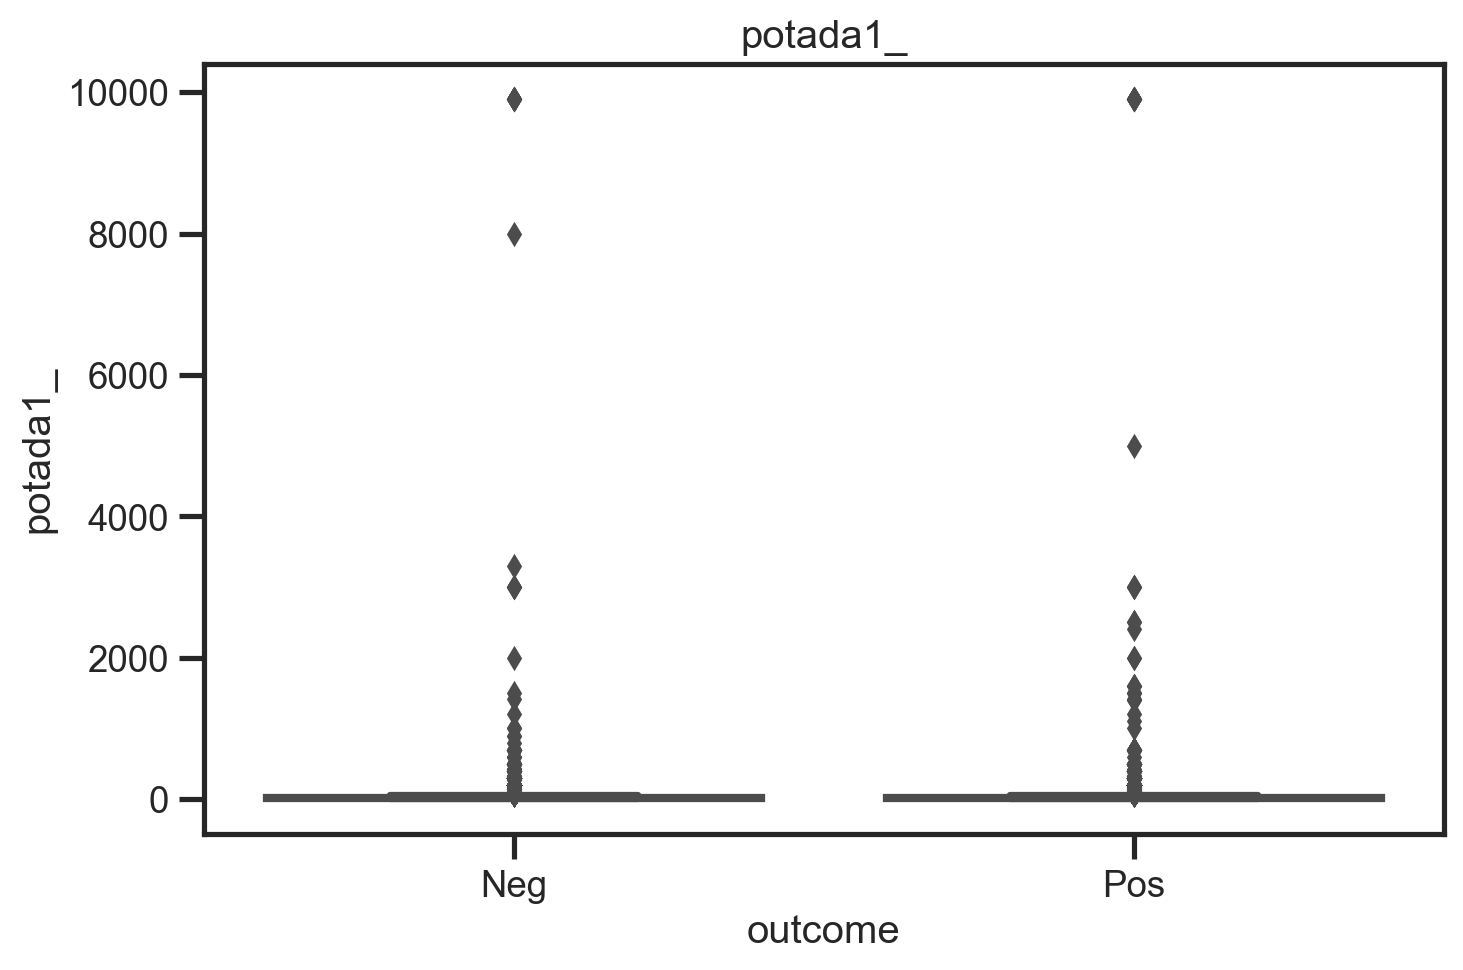

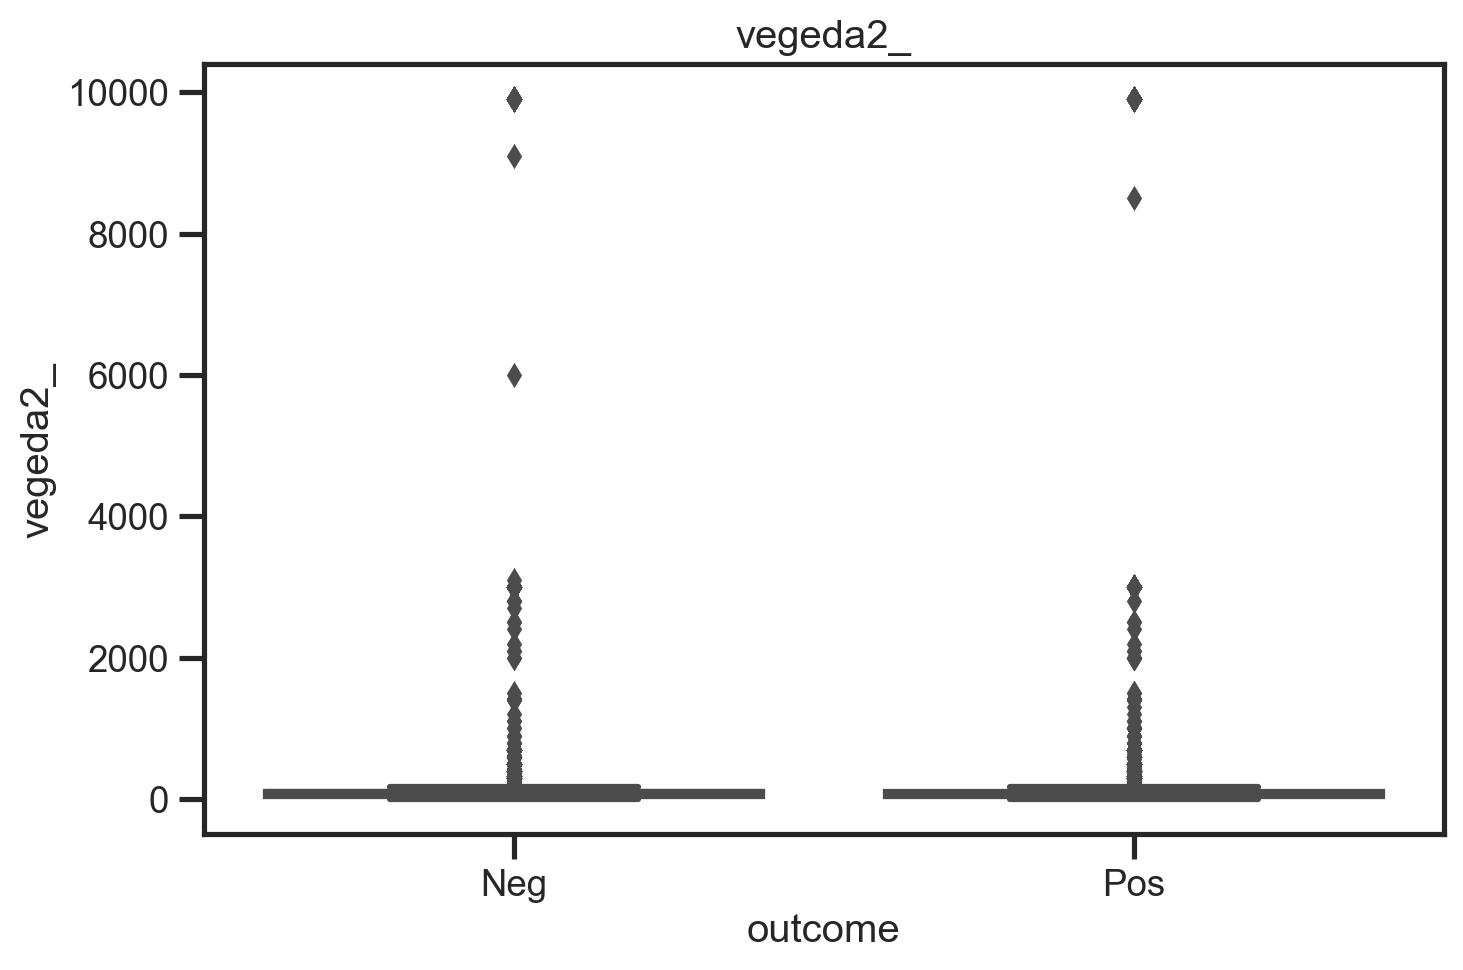

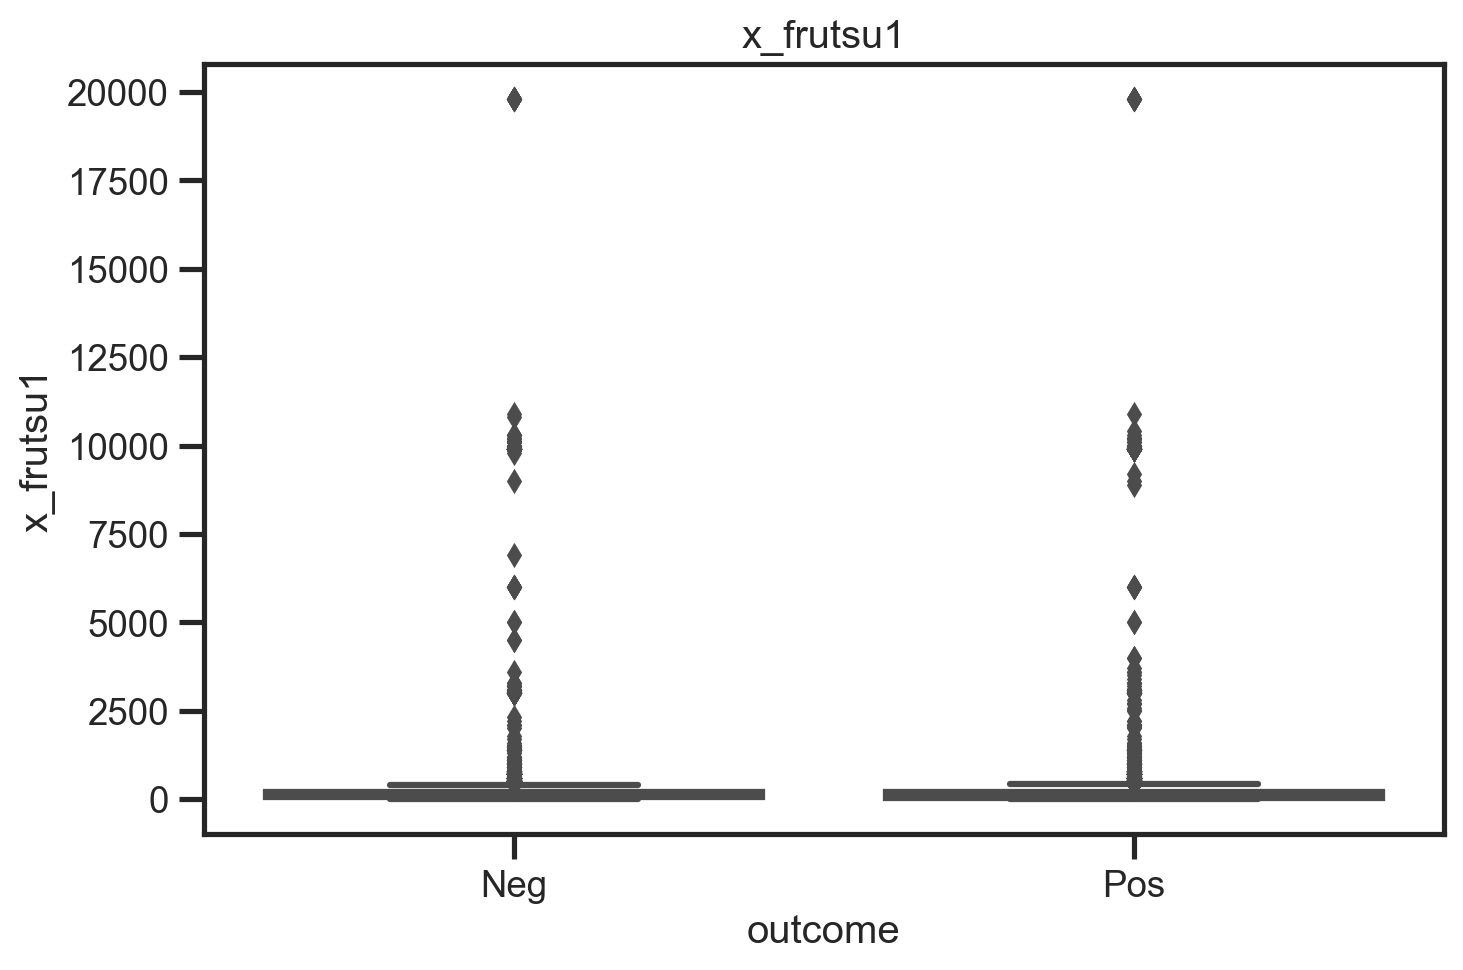

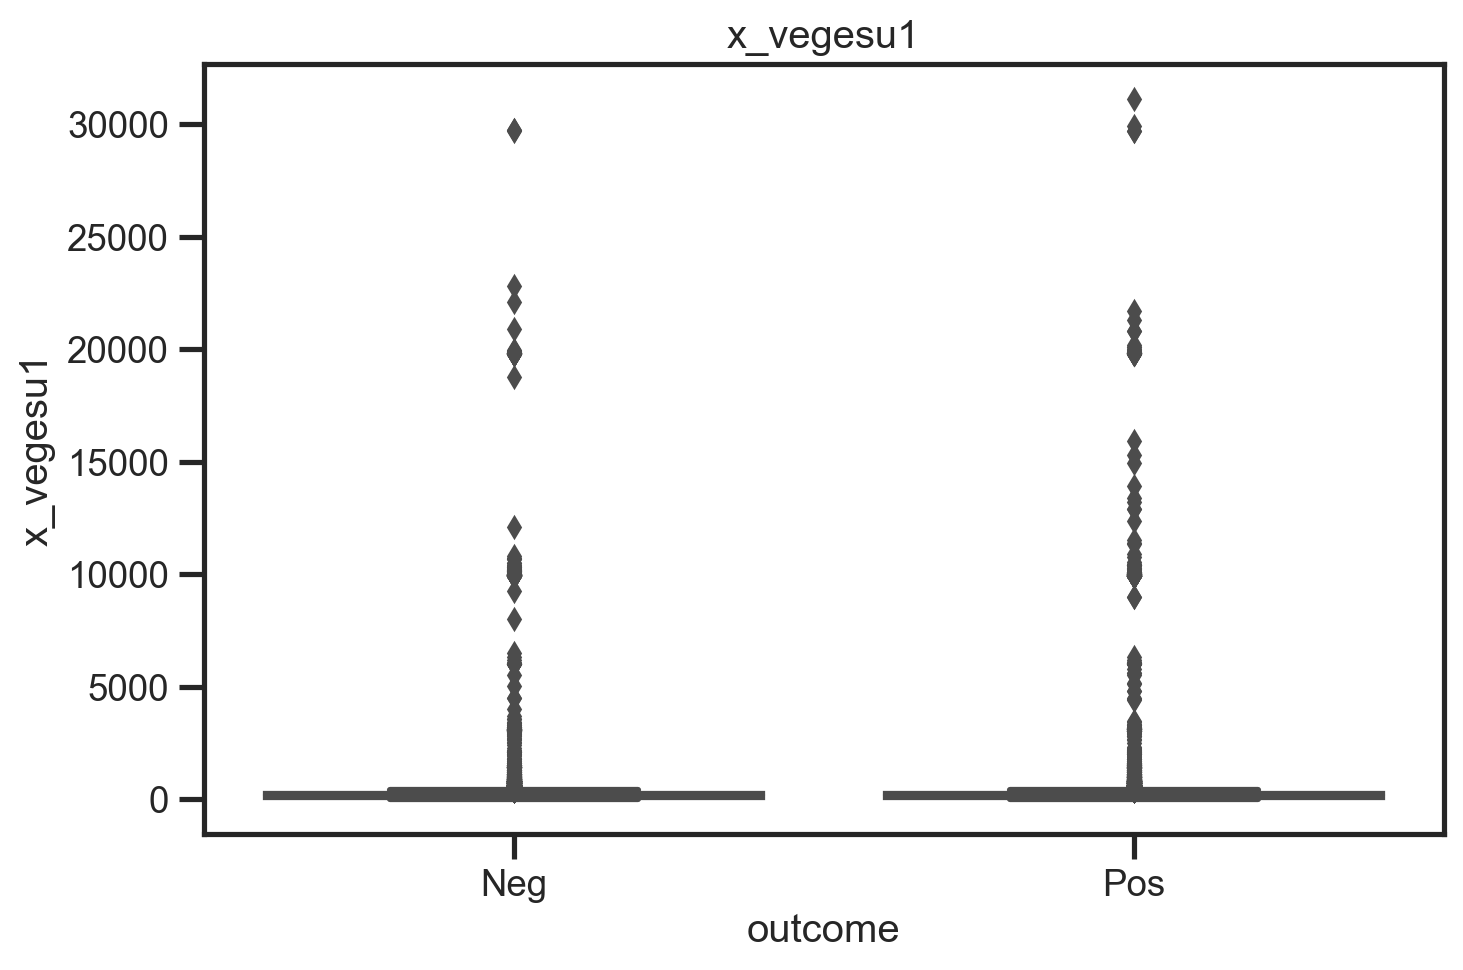

In [87]:
for i in cont_cols:
    plot_boxplot(train_data, i, 'outcome')

#### Handling outliers using InterQuartile Range

In [88]:
#lets impute the outliers in height, weight and bmi
def outliers(df, column):
    # Calculate the 25th and 75th percentiles (Q1 and Q3)
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)

    # Calculate the Interquartile Range (IQR)
    IQR = Q3 - Q1

    # Define the lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Replace outliers with the median value
    median_value = df[column].quantile(0.99)
    df[column] = df[column].mask((df[column] < lower_bound) | (df[column] > upper_bound), median_value)


# Treating outliers on some continuous columns
# outliers(train_data, 'height3')
# outliers(train_data, 'weight2')
# outliers(train_data, 'ftjuda2_')
# outliers(train_data, 'frutda2_')
# outliers(train_data, 'grenda1_')
# outliers(train_data, 'frnchda_')
# outliers(train_data, 'potada1_')
# outliers(train_data, 'vegeda2_')
# outliers(train_data, 'x_frutsu1')
# outliers(train_data, 'x_vegesu1')

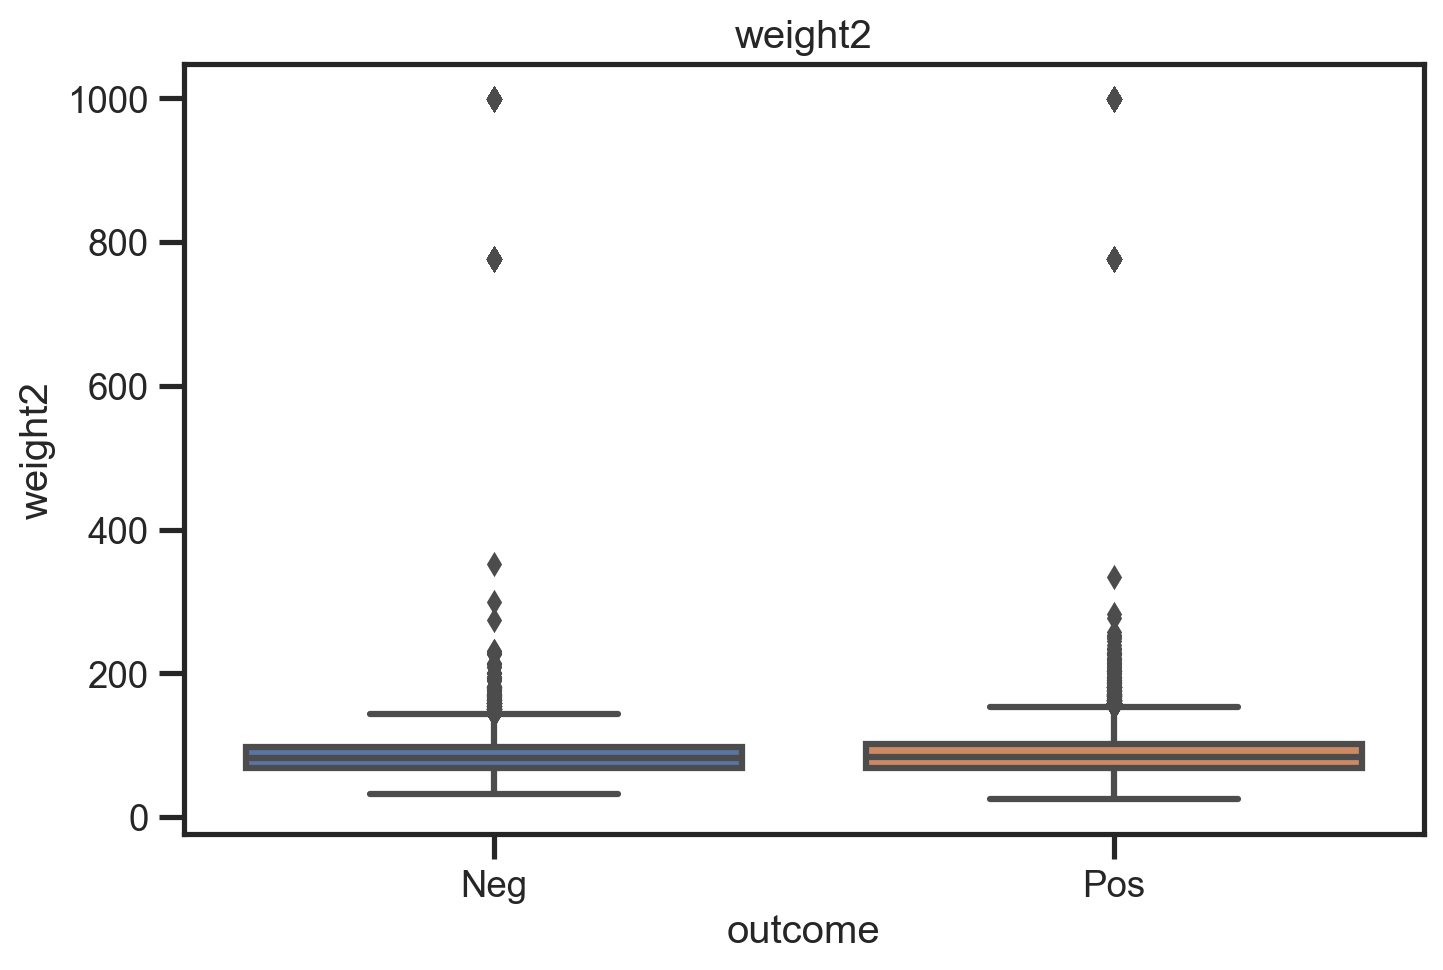

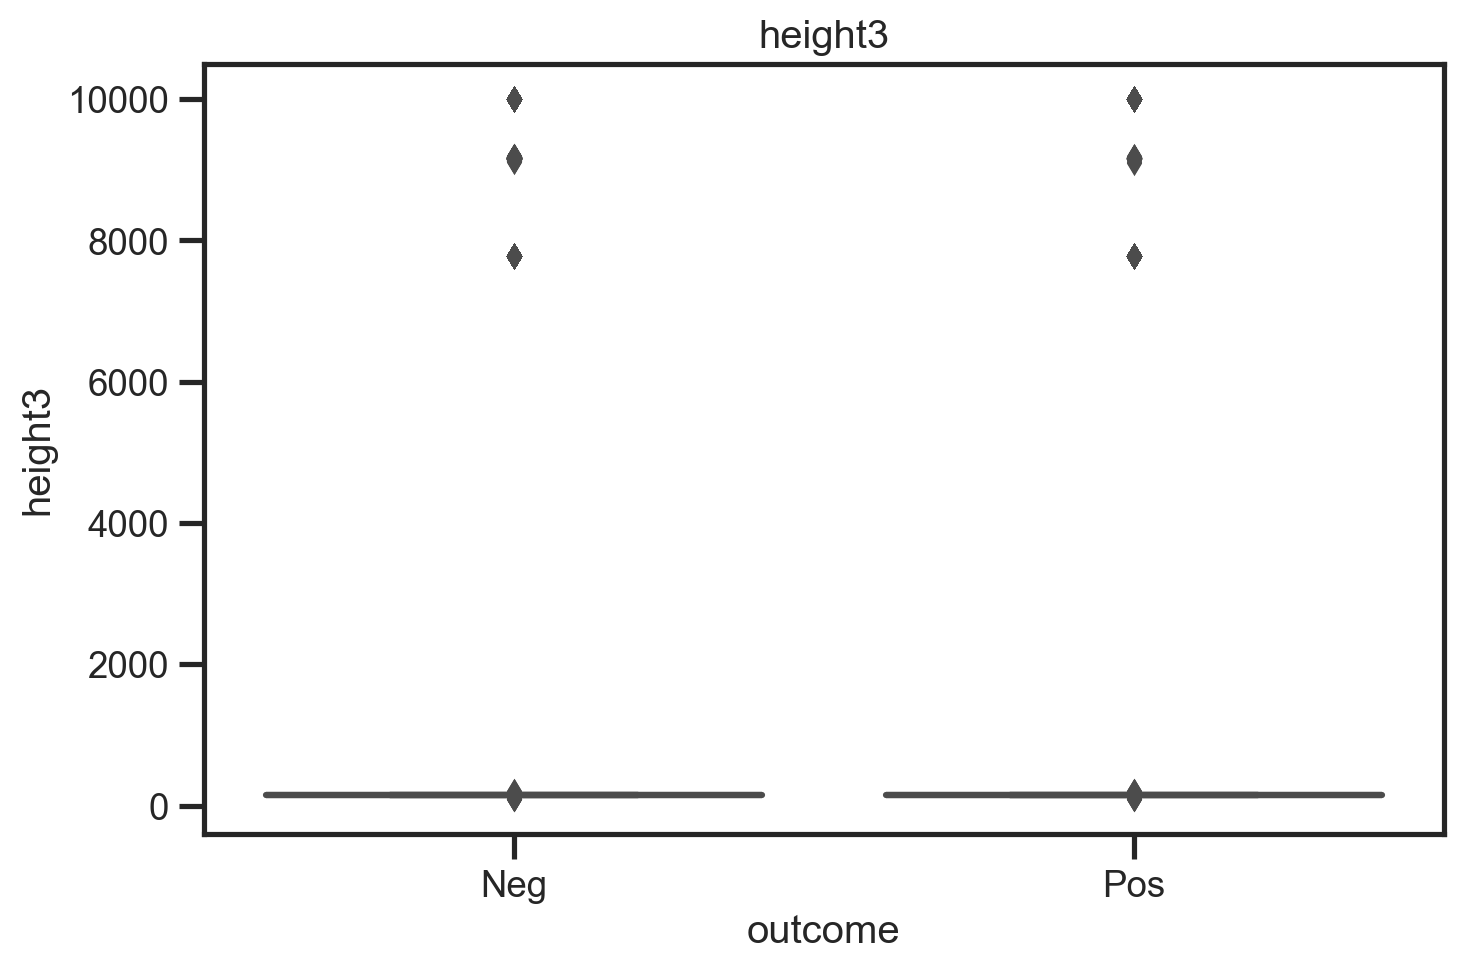

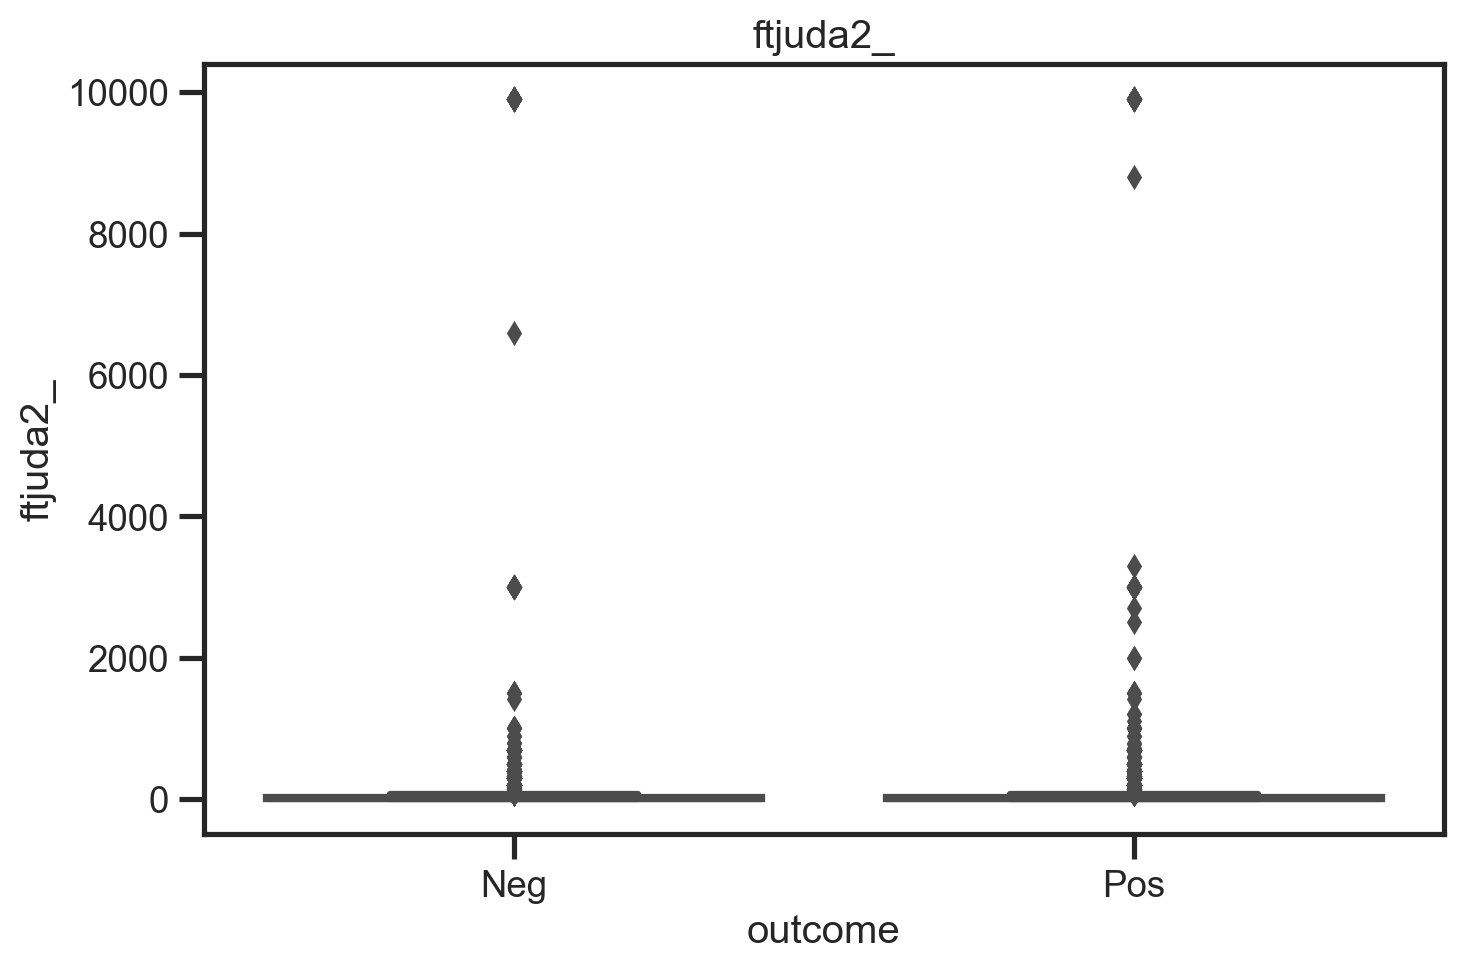

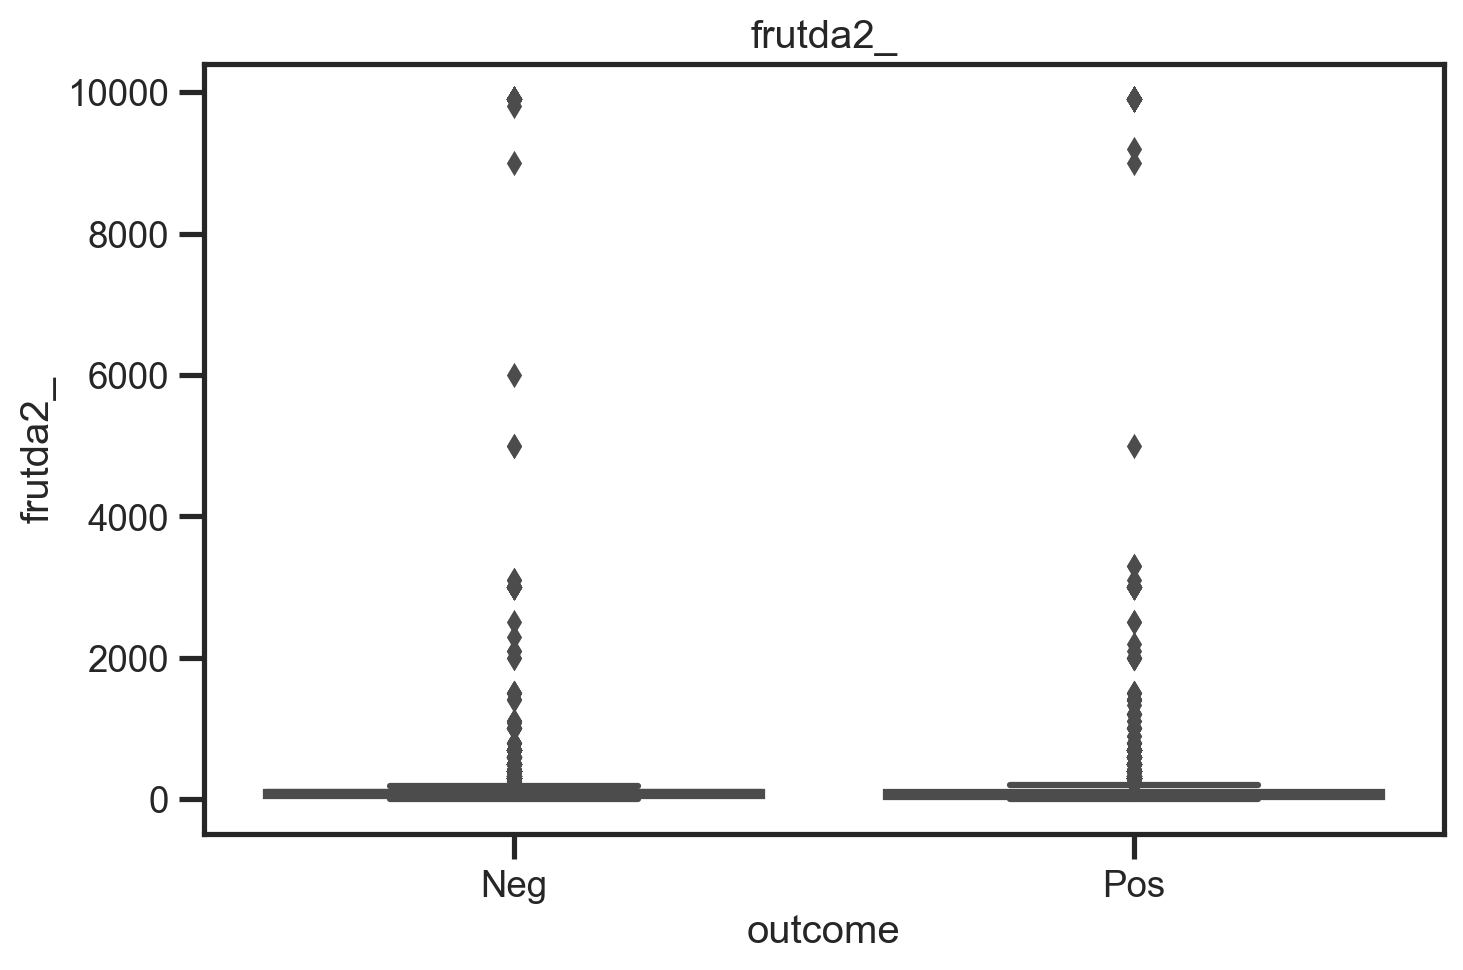

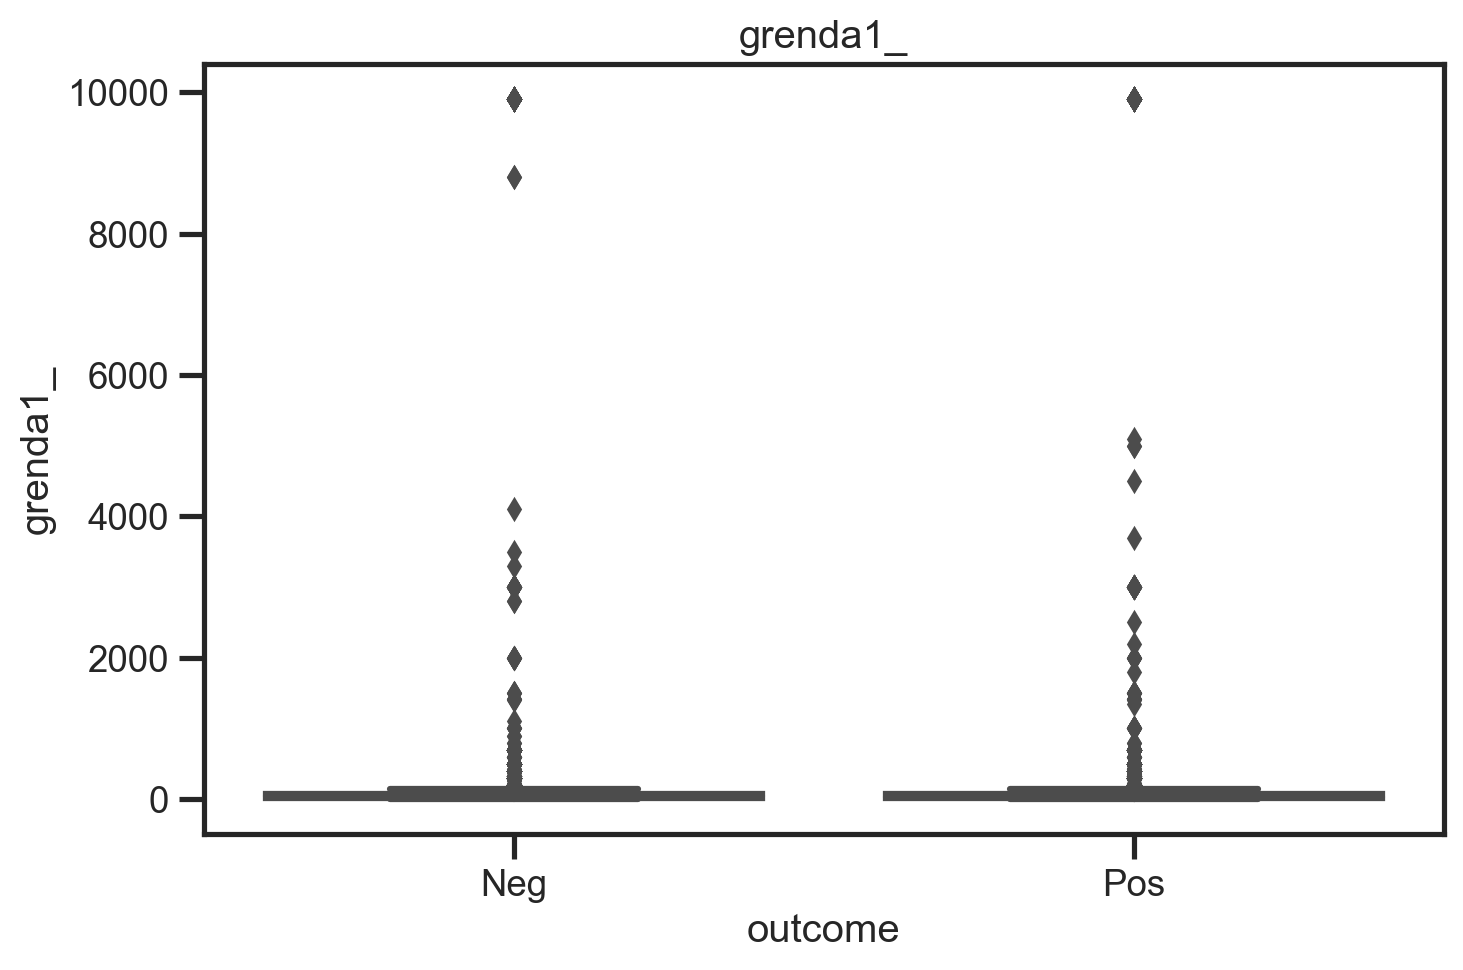

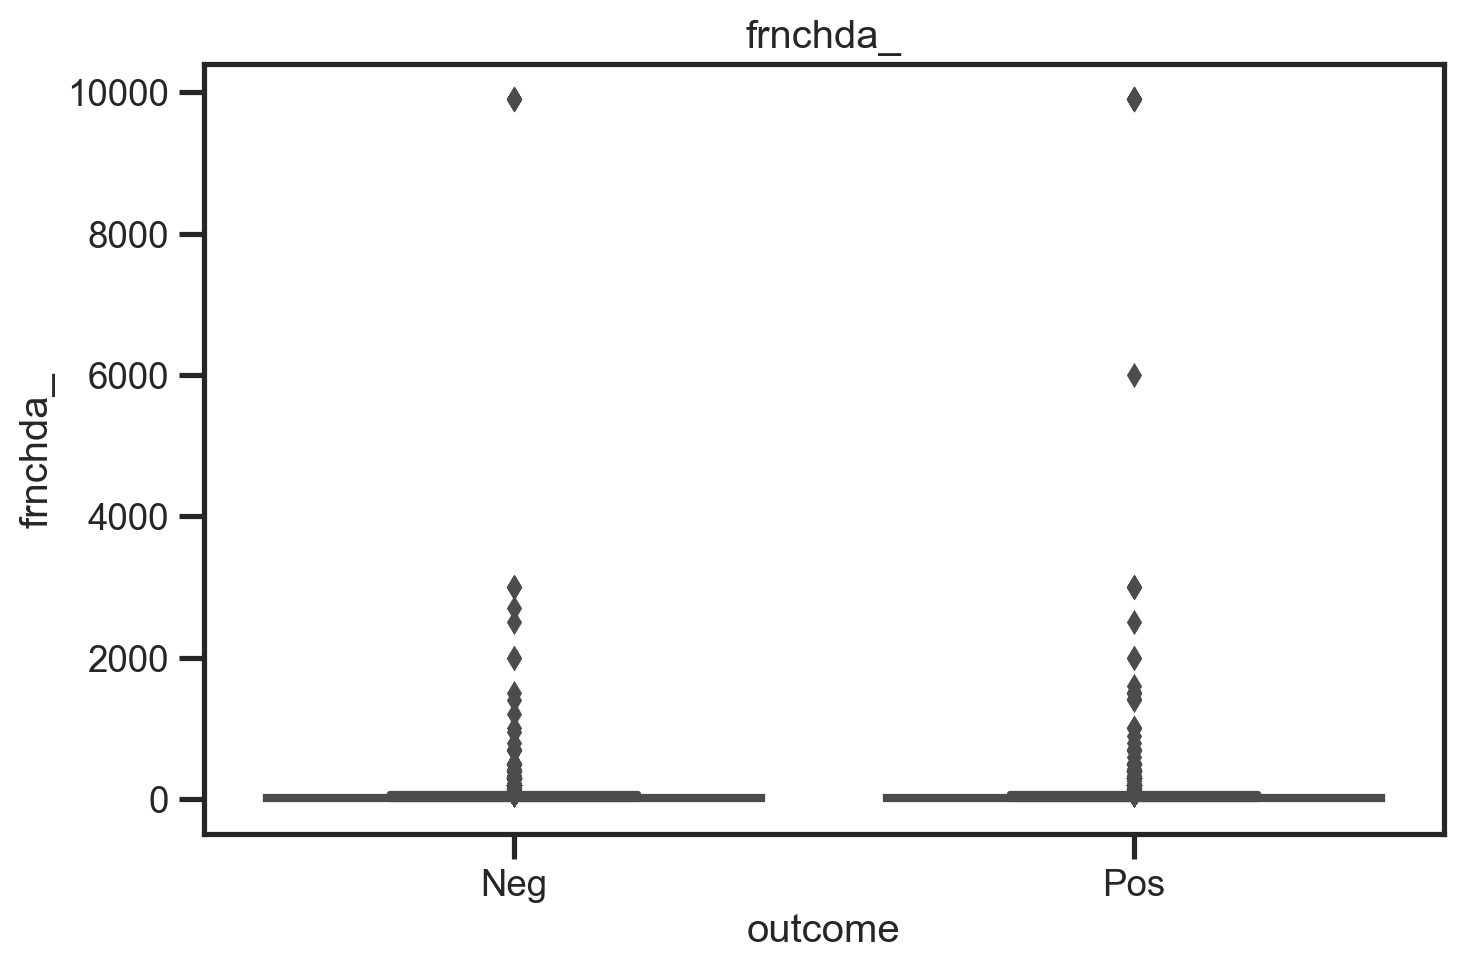

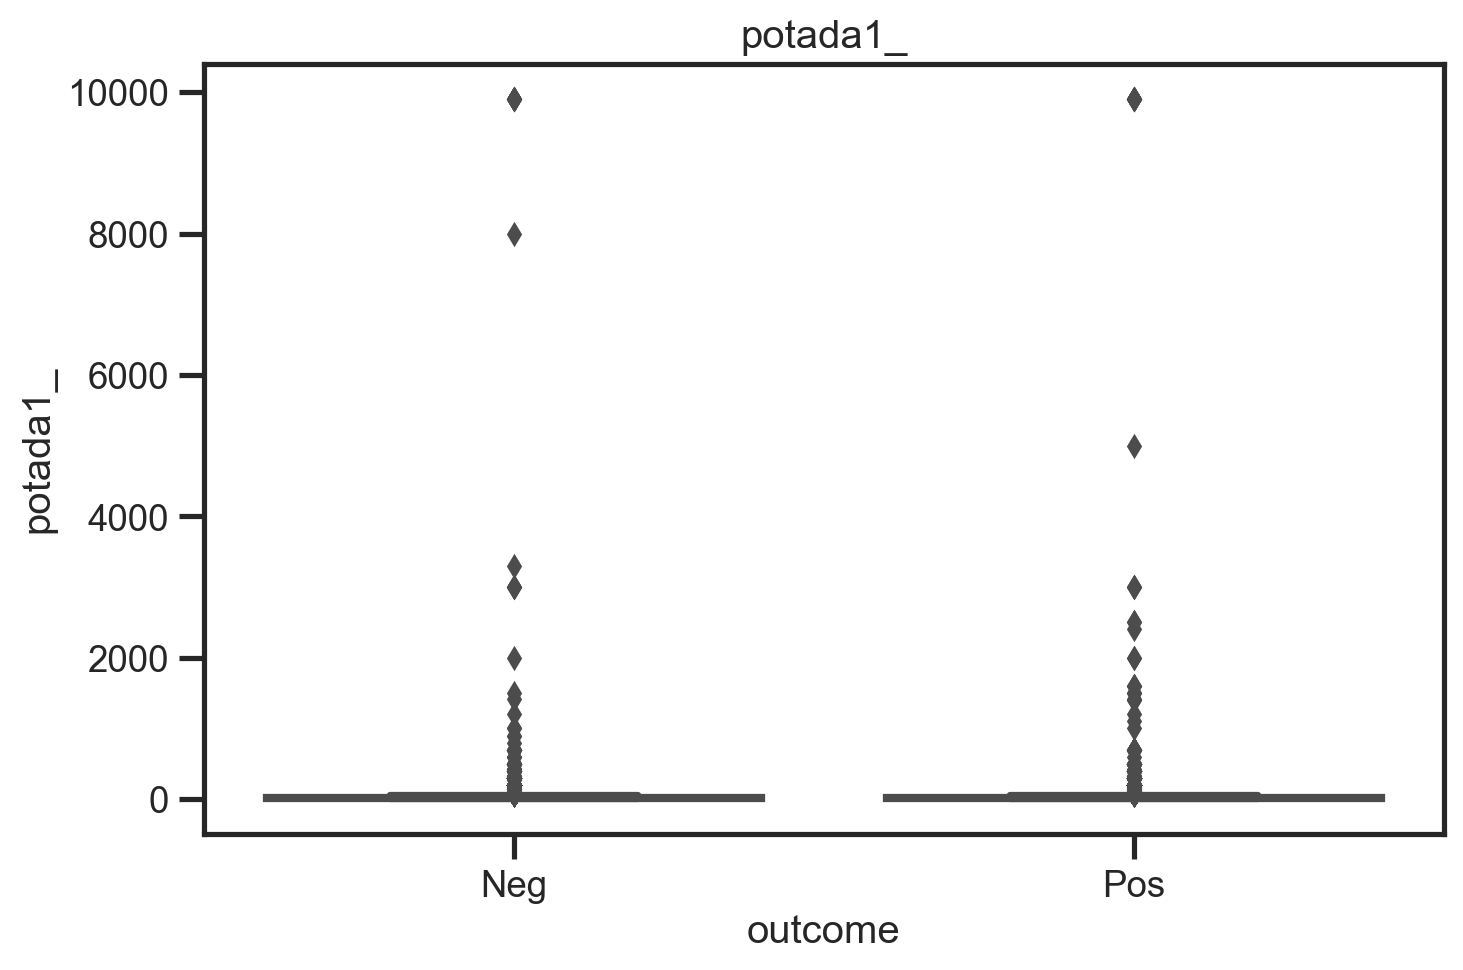

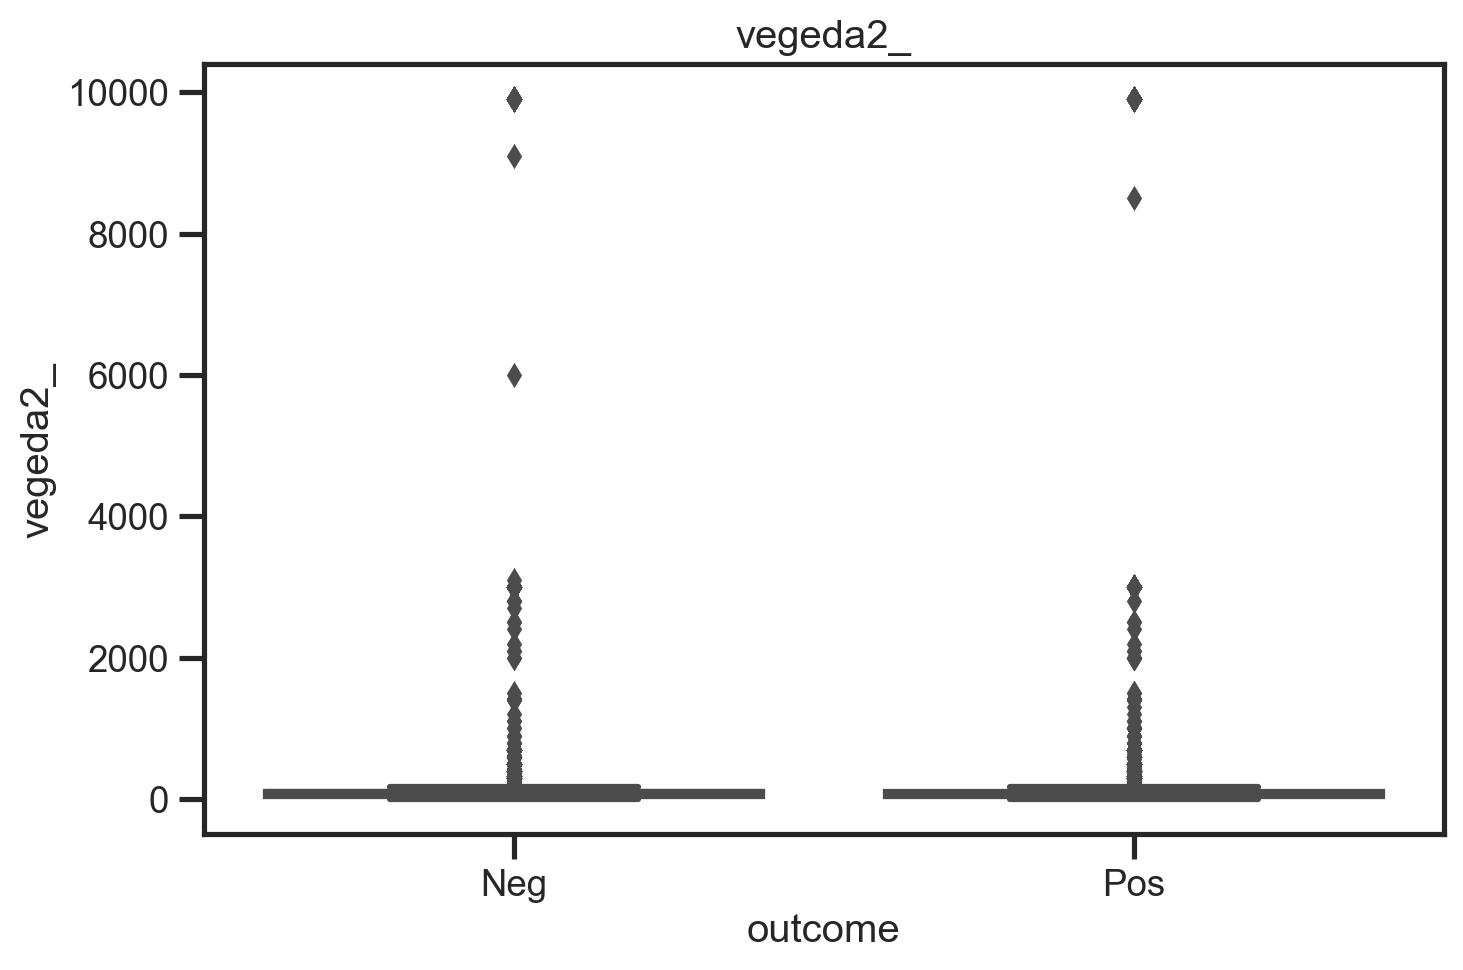

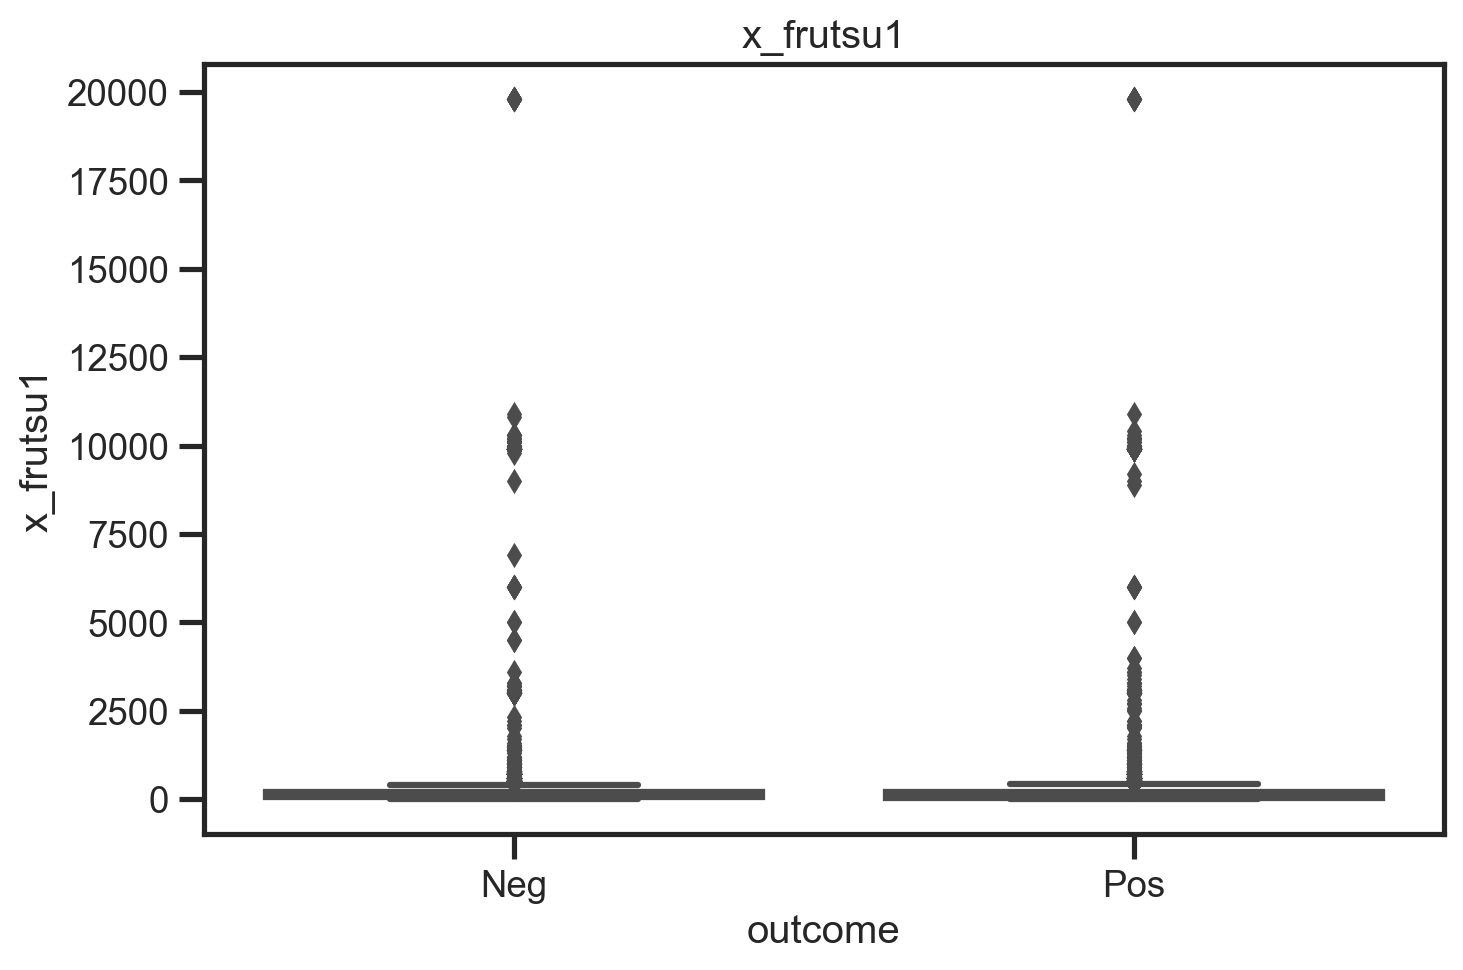

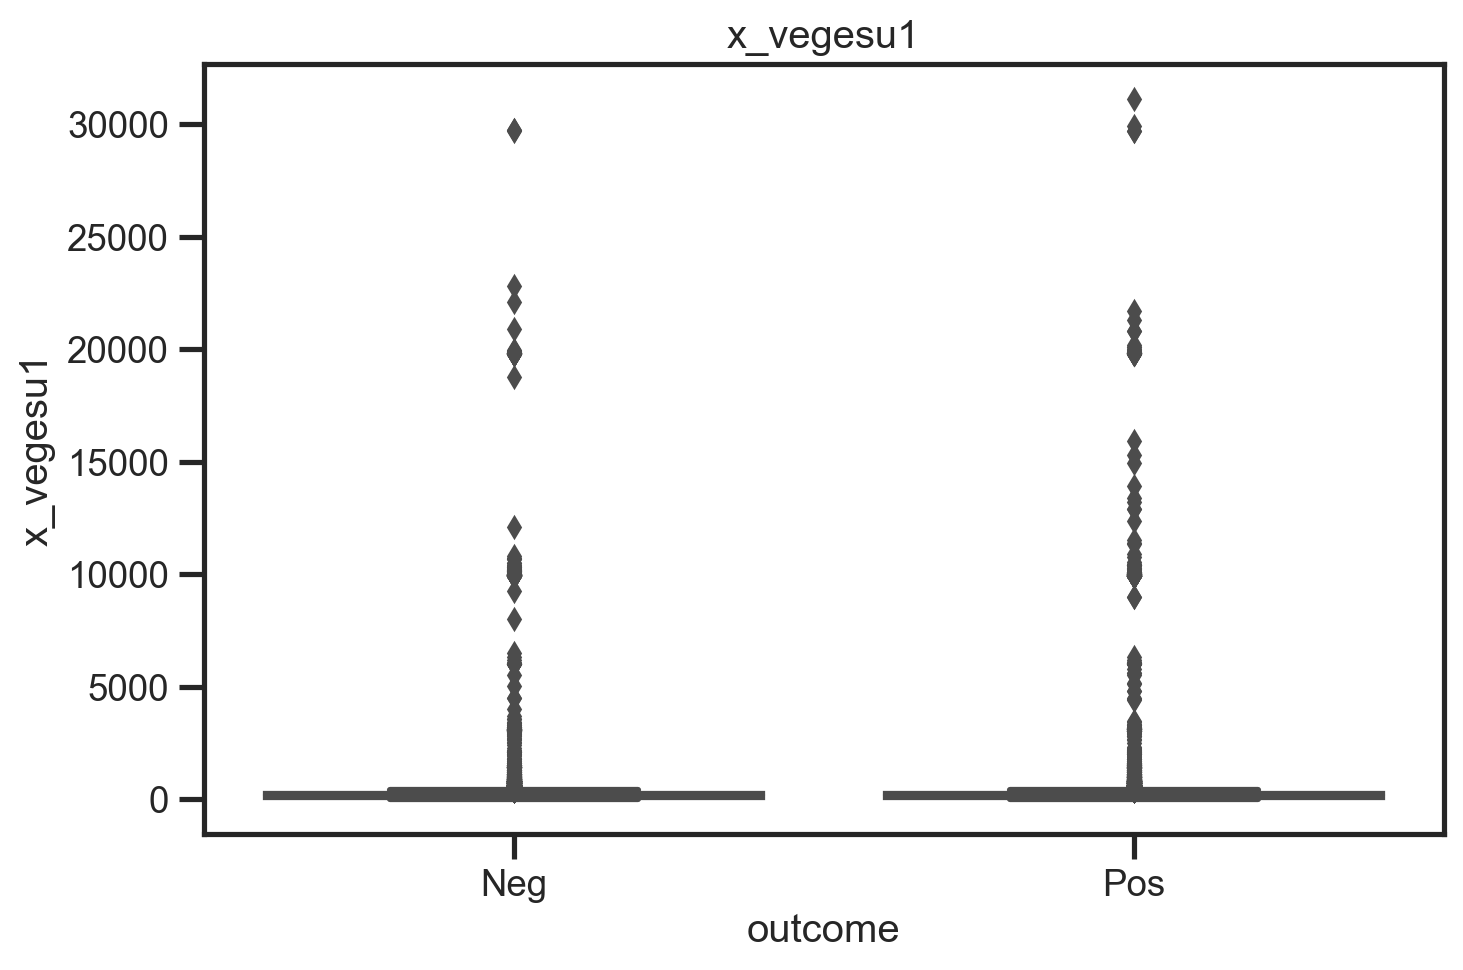

In [89]:
# cols = ['x_rfbmi5', 'x_bmi5cat', 'height3', 'weight2', 'ftjuda2_', 'frutda2_', 'grenda1_', 'frnchda_', 'potada1_', 'vegeda2_', 'x_frutsu1', 'x_vegesu1']
# for i in cols:
#     plot_boxplot(train_data, i,'outcome')
for i in cont_cols:
    plot_boxplot(train_data, i, 'outcome')

In [90]:
cont_cols

['weight2',
 'height3',
 'ftjuda2_',
 'frutda2_',
 'grenda1_',
 'frnchda_',
 'potada1_',
 'vegeda2_',
 'x_frutsu1',
 'x_vegesu1']

In [91]:
cat_cols

['iyear',
 'dispcode',
 'sexvar',
 'persdoc3',
 'medcost1',
 'checkup1',
 'toldhi3',
 'cvdstrk3',
 'chcscncr',
 'chcocncr',
 'chccopd3',
 'chckdny2',
 'marital',
 'renthom1',
 'cpdemo1b',
 'veteran3',
 'employ1',
 'deaf',
 'blind',
 'decide',
 'diffwalk',
 'diffdres',
 'diffalon',
 'usenow3',
 'flushot7',
 'pneuvac4',
 'x_metstat',
 'x_urbstat',
 'x_imprace',
 'x_rfhlth',
 'x_phys14d',
 'x_hlthpln',
 'x_hcvu652',
 'x_totinda',
 'x_rfhype6',
 'x_cholch3',
 'x_rfchol3',
 'x_michd',
 'x_ltasth1',
 'x_casthm1',
 'x_asthms1',
 'x_drdxar3',
 'x_lmtact3',
 'x_lmtwrk3',
 'x_prace1',
 'x_sex',
 'x_age65yr',
 'x_bmi5cat',
 'x_rfbmi5',
 'x_chldcnt',
 'x_educag',
 'x_incomg1',
 'x_smoker3',
 'drnkany5',
 'x_aidtst4',
 'x_state',
 'imonth']

Replacing values such as 7,9,77,99 (not sure/refuse/missing) in the categorical column with the respective mode. It is to be noted that column X_AGE65YR has a value of 3 which means not_sure/refuse/missing. Also column X_INCOMG1 has a value of 7 but not equivalent to not_sure/refuse/missing

In [92]:
# def standardize_values(df):
#     """Standardize categorical column values.

#     Args:
#         df (pd.DataFrame): Dataframe containg the columns of interest

#     Returns:
#        df( (pd.DataFrame): A new dataframe

#     """

#     categorical_columns = df.columns[~df.columns.isin(continuous_columns)]
#     # Calculate the mode of the X_AGE65YR column
#     mode_value = df['x_age65yr'].mode().iloc[0]
#     # Replace the 3 with the mode_value
#     df['x_age65yr'] = df['x_age65yr'].replace(3, mode_value)

#     # Calculate the mode of the X_INCOMG1 column
#     mode_value = df['x_incomg1'].mode().iloc[0]
#     # Replace the 3 with the mode_value
#     df['x_incomg1'] = df['x_incomg1'].replace(9, mode_value)


#     # List of columns for replacement (excluding 'X_INCOMG1')
#     categorical_columns_to_replace = [col for col in categorical_columns if col != 'X_INCOMG1']

#     # Target values to replace
#     target_values = [7, 9, 77, 99]
#     for column in categorical_columns_to_replace:
#         # Calculate the mode for each column
#         mode_value = df[column].mode().iloc[0]

#         # Replace the target values with their respective mode values
#         df[column] = df[column].replace(target_values, mode_value)
    
#     return df


In [93]:
# train_data = standardize_values(train_data)

In [94]:
train_data.shape

(65802, 68)

# Statistical Visualization

In [95]:
train_data[continuous_columns].describe()

,ftjuda2_,frutda2_,grenda1_,frnchda_,potada1_,vegeda2_,x_frutsu1,x_vegesu1
count,65802.000000,65802.000000,65802.000000,65802.000000,65802.000000,65802.000000,65802.000000,65802.000000
mean,40.864715,127.798152,73.474241,25.976703,27.713762,135.191301,167.299702,259.731057
std,336.194239,471.926779,440.764051,187.379994,172.848338,629.960949,626.883942,985.764662
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,43.000000,14.000000,3.000000,7.000000,43.000000,50.000000,114.000000
50%,3.000000,100.000000,43.000000,14.000000,14.000000,86.000000,100.000000,163.000000
75%,29.000000,100.000000,71.000000,29.000000,29.000000,100.000000,200.000000,228.000000
max,9900.000000,9900.000000,9900.000000,9900.000000,9900.000000,9900.000000,19800.000000,31114.000000


Data Skewness:
ftjuda2_     26.998526
frutda2_     18.912707
grenda1_     20.977746
frnchda_     48.071542
potada1_     51.025546
vegeda2_     14.658409
x_frutsu1    19.098008
x_vegesu1    16.393811
dtype: float64

Data Kurtosis:
ftjuda2_      775.162573
frutda2_      382.648528
grenda1_      458.677029
frnchda_     2485.549736
potada1_     2840.830975
vegeda2_      221.901644
x_frutsu1     438.362949
x_vegesu1     316.819831
dtype: float64



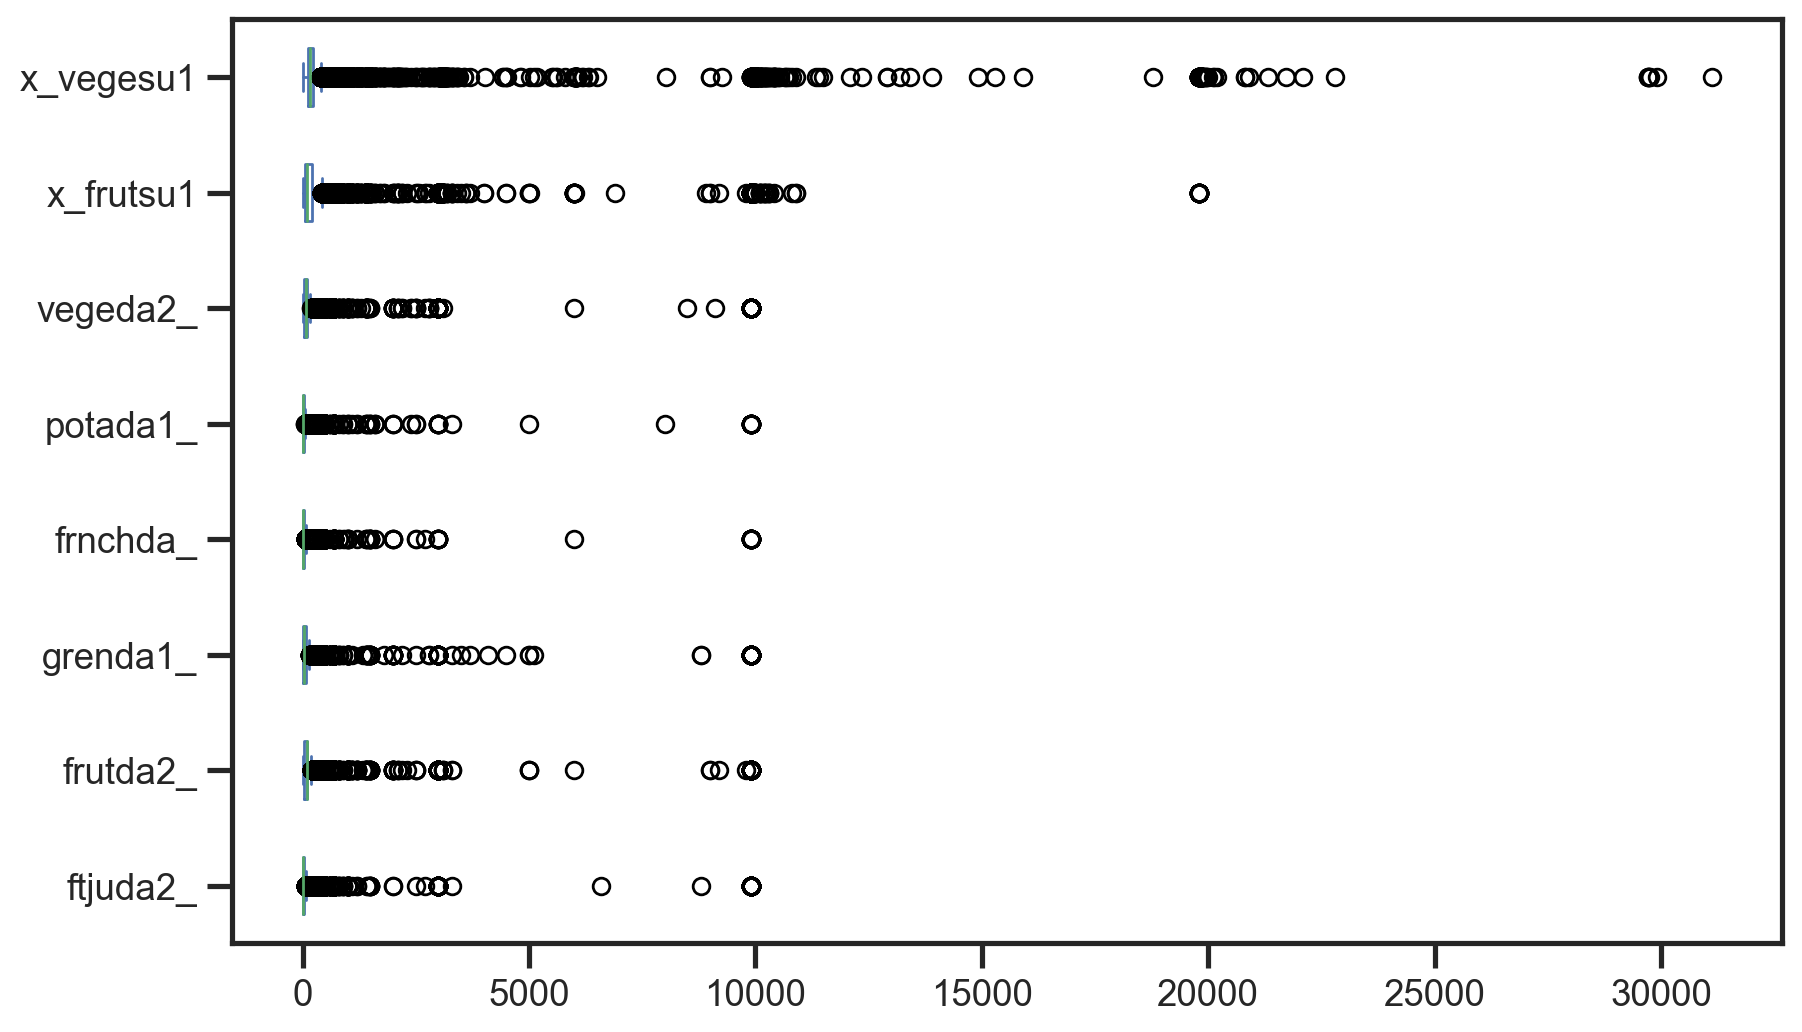

In [96]:
# Skewness of continous variables
continuous_var1 = train_data[continuous_columns]
print(f"Data Skewness:\n{continuous_var1.skew()}\n")

# Kurtosis of continous variables
print(f"Data Kurtosis:\n{continuous_var1.kurtosis()}\n")

# Boxplot of continuous variables
continuous_var1.plot.box(figsize=(10,6), vert = False, grid = False);

## **Correlation Analysis**

In [97]:
# Replace the object values ('Pos','Neg') in the Outcome column with integer (0,1)
train_data['outcome'] = train_data['outcome'].astype('category').cat.codes

# Display the updated value
train_data['outcome'].value_counts()

1    33335
0    32467
Name: outcome, dtype: int64

In [98]:
train_data.head()

,x_state,imonth,iyear,dispcode,sexvar,persdoc3,medcost1,checkup1,toldhi3,cvdstrk3,...,x_aidtst4,ftjuda2_,frutda2_,grenda1_,frnchda_,potada1_,vegeda2_,x_frutsu1,x_vegesu1,outcome
0,29,11,2021,1100,2,1,1.0,1,1.0,2,...,9.0,3.0,14.0,100.0,0.0,0.0,100.0,100.0,200.0,0
1,28,3,2021,1100,1,1,2.0,1,2.0,2,...,1.0,0.0,200.0,33.0,10.0,17.0,100.0,200.0,160.0,1
2,19,8,2021,1100,1,1,2.0,1,2.0,2,...,2.0,0.0,43.0,3.0,7.0,2.0,14.0,43.0,26.0,0
3,27,9,2021,1100,1,2,2.0,1,1.0,2,...,1.0,3.0,7.0,29.0,100.0,100.0,50.0,10.0,279.0,1
4,50,4,2021,1100,2,1,2.0,1,1.0,2,...,1.0,200.0,500.0,300.0,100.0,500.0,600.0,700.0,1500.0,1


<Axes: >

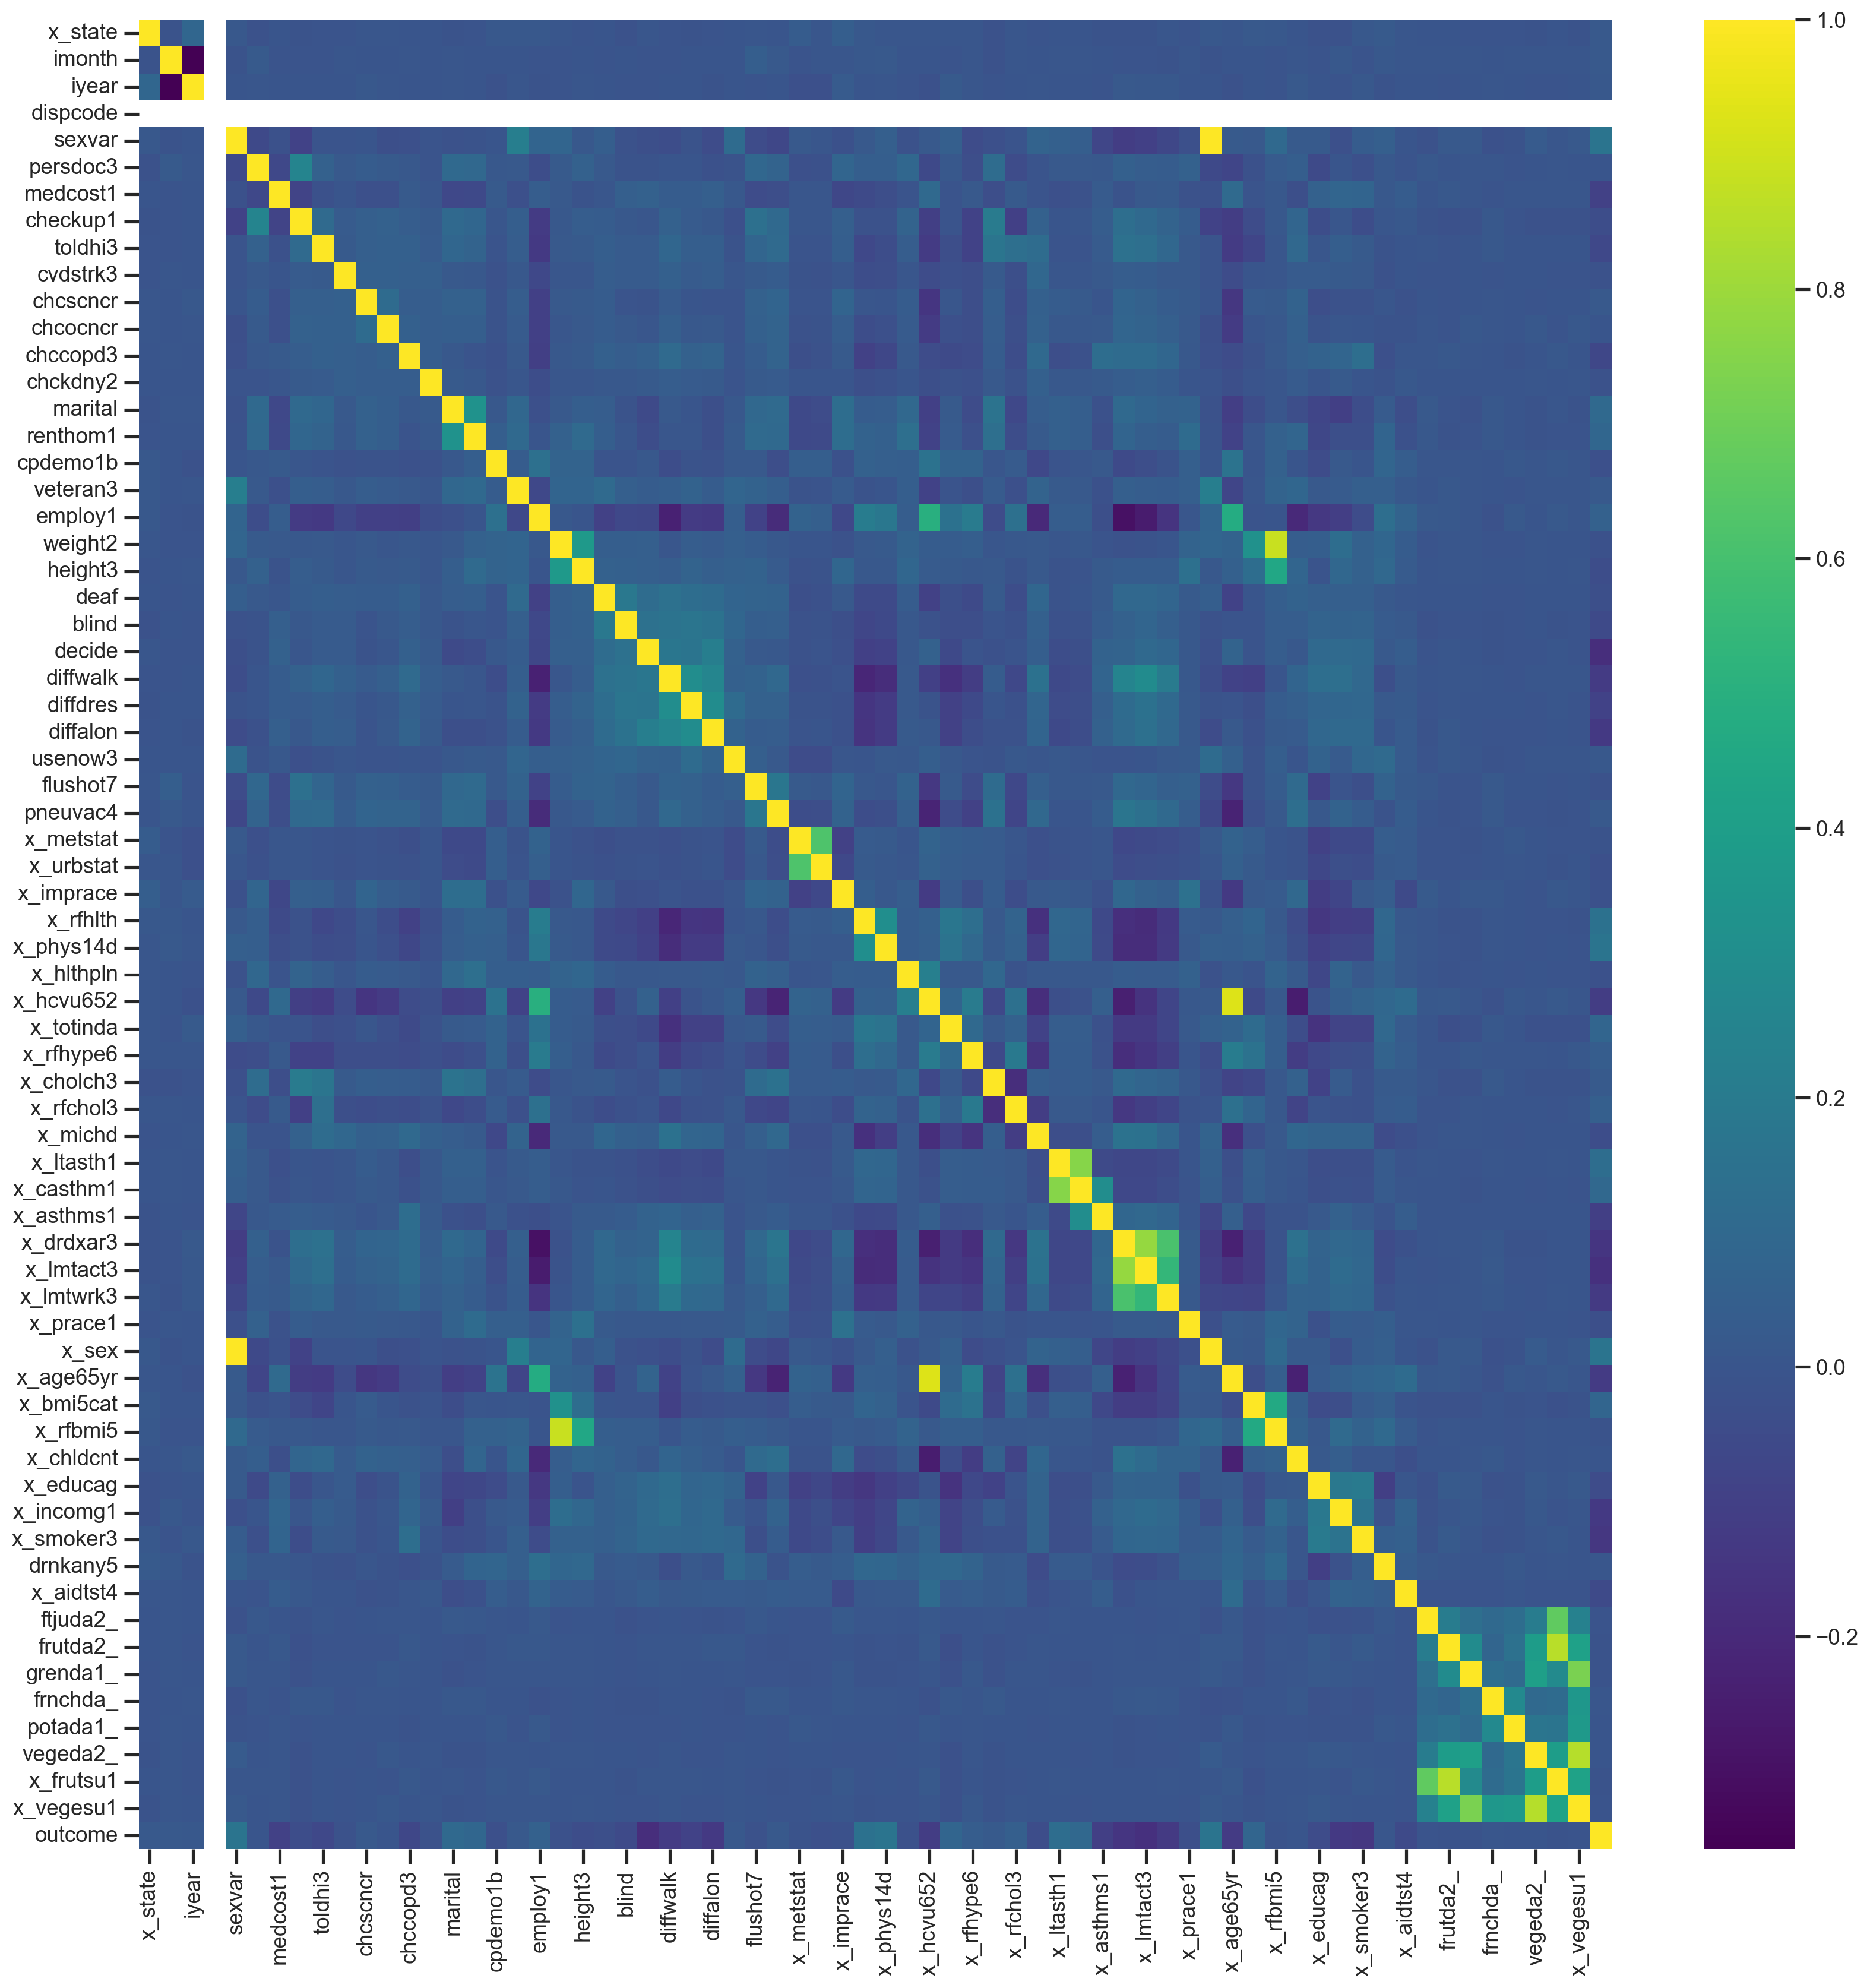

In [99]:
# features correlation
plt.figure(figsize=(20,20))
sns.heatmap(train_data.corr(), cmap='viridis')

In [100]:
# Compute the correlation between each variable and the target variable
correlations = abs(train_data.corr()['outcome'].drop('outcome'))

# Sort the correlation coefficients in descending order
correlations_sorted = correlations.sort_values(ascending=False)

print(correlations_sorted[0:20])

decide       0.181588
x_lmtact3    0.167287
x_phys14d    0.164211
x_sex        0.162362
sexvar       0.162233
x_rfhlth     0.150000
x_drdxar3    0.149463
x_smoker3    0.145067
diffalon     0.133418
x_incomg1    0.131141
x_lmtwrk3    0.125338
diffwalk     0.122498
x_ltasth1    0.122006
x_age65yr    0.120657
x_hcvu652    0.117490
x_asthms1    0.107167
marital      0.102920
x_casthm1    0.096082
medcost1     0.094108
diffdres     0.090065
Name: outcome, dtype: float64


In [295]:
train_data.to_csv('cleaned_train.csv', index=False)

In [101]:
# Drop irrelevant columns
# train_data.drop(columns=['x_state'], inplace=True)

In [102]:
seed =1234
X, y = train_data.drop(columns=['outcome','iyear', 'imonth', 'dispcode', 'sexvar']),train_data['outcome']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, random_state=seed)

In [103]:
print(f"continous columns: {len(cont_cols)}, categorical columns: {len(cat_cols)}")

continous columns: 10, categorical columns: 57


In [105]:
cat_cols.remove('imonth')
cat_cols.remove('dispcode')
cat_cols.remove('sexvar')

In [106]:
cat_cols.remove('iyear')

### Create preprocessing Pipeline

In [107]:
def preprocessor_pipe():
    numeric_features = cont_cols
    numeric_transformer = Pipeline(
        steps=[
            # its a good practice to do the polynomial/interaction feature generation before scaling.
            # ("poly_int", PolynomialFeatures(interaction_only=True, include_bias=False)),
            ("scaler", StandardScaler())
        ]
    ).set_output(transform='pandas')

    categorical_features = cat_cols
    categorical_transformer = Pipeline(
        steps=[
            ("ohe", OneHotEncoder(handle_unknown="infrequent_if_exist", sparse_output=False, drop='if_binary')),
        ]
    ).set_output(transform='pandas')

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_features),
            ("cat", categorical_transformer, categorical_features),
        ],
        remainder='passthrough',
        verbose_feature_names_out=False
    ).set_output(transform="pandas")

    return preprocessor

In [109]:
preprocessor = preprocessor_pipe() 
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

In [110]:
X_train_preprocessed.shape

(52641, 281)

In [111]:
X_train_preprocessed.head()

,weight2,height3,ftjuda2_,frutda2_,grenda1_,frnchda_,potada1_,vegeda2_,x_frutsu1,x_vegesu1,...,x_state_49,x_state_50,x_state_51,x_state_53,x_state_54,x_state_55,x_state_56,x_state_66,x_state_72,x_state_78
34708,-0.285905,-0.150516,0.174543,-0.150185,-0.070104,0.084200,0.088317,-0.146978,-0.018277,-0.090636,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
56696,-0.055280,-0.151273,-0.115315,-0.254818,-0.070104,-0.097697,-0.145147,-0.057119,-0.252657,-0.109849,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39835,-0.424281,-0.151273,-0.121231,0.149065,-0.151052,-0.097697,-0.162657,-0.146978,0.049820,-0.206929,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
63378,-0.091155,-0.127799,-0.115315,-0.150185,-0.135312,-0.062328,-0.080944,-0.169049,-0.173475,-0.192771,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
63336,-0.378156,-0.150516,-0.121231,-0.254818,-0.166792,-0.097697,0.421004,-0.057119,-0.255824,-0.055242,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Trying out Principal Component Analysis using the pre processed data set

In [112]:
X_pca = PCA()
X_pca.fit(X_train_preprocessed)

PCA()

In [113]:
X_pca.explained_variance_ratio_

array([1.10597243e-01, 7.11090841e-02, 5.00635648e-02, 4.89425556e-02,
       4.31714681e-02, 3.68355402e-02, 2.92222930e-02, 2.59536748e-02,
       2.47139777e-02, 2.27802219e-02, 2.21184295e-02, 2.17226703e-02,
       2.04572717e-02, 2.01210918e-02, 1.68312167e-02, 1.64484865e-02,
       1.53917499e-02, 1.37532959e-02, 1.33475967e-02, 1.26211787e-02,
       1.20160941e-02, 1.12084950e-02, 1.05792365e-02, 9.99347325e-03,
       9.94608504e-03, 9.52951229e-03, 9.35599395e-03, 9.29317069e-03,
       8.88251626e-03, 8.38633985e-03, 8.06247808e-03, 7.69774366e-03,
       7.24260818e-03, 7.11080451e-03, 6.99278432e-03, 6.58400171e-03,
       6.08195699e-03, 6.05891755e-03, 5.96757646e-03, 5.73618256e-03,
       5.61417673e-03, 5.44070982e-03, 5.23601501e-03, 5.17989403e-03,
       4.98315961e-03, 4.84189383e-03, 4.62499147e-03, 4.52275176e-03,
       4.50938626e-03, 4.14825986e-03, 4.02823544e-03, 3.88083164e-03,
       3.81446354e-03, 3.65761934e-03, 3.60791954e-03, 3.55724803e-03,
      

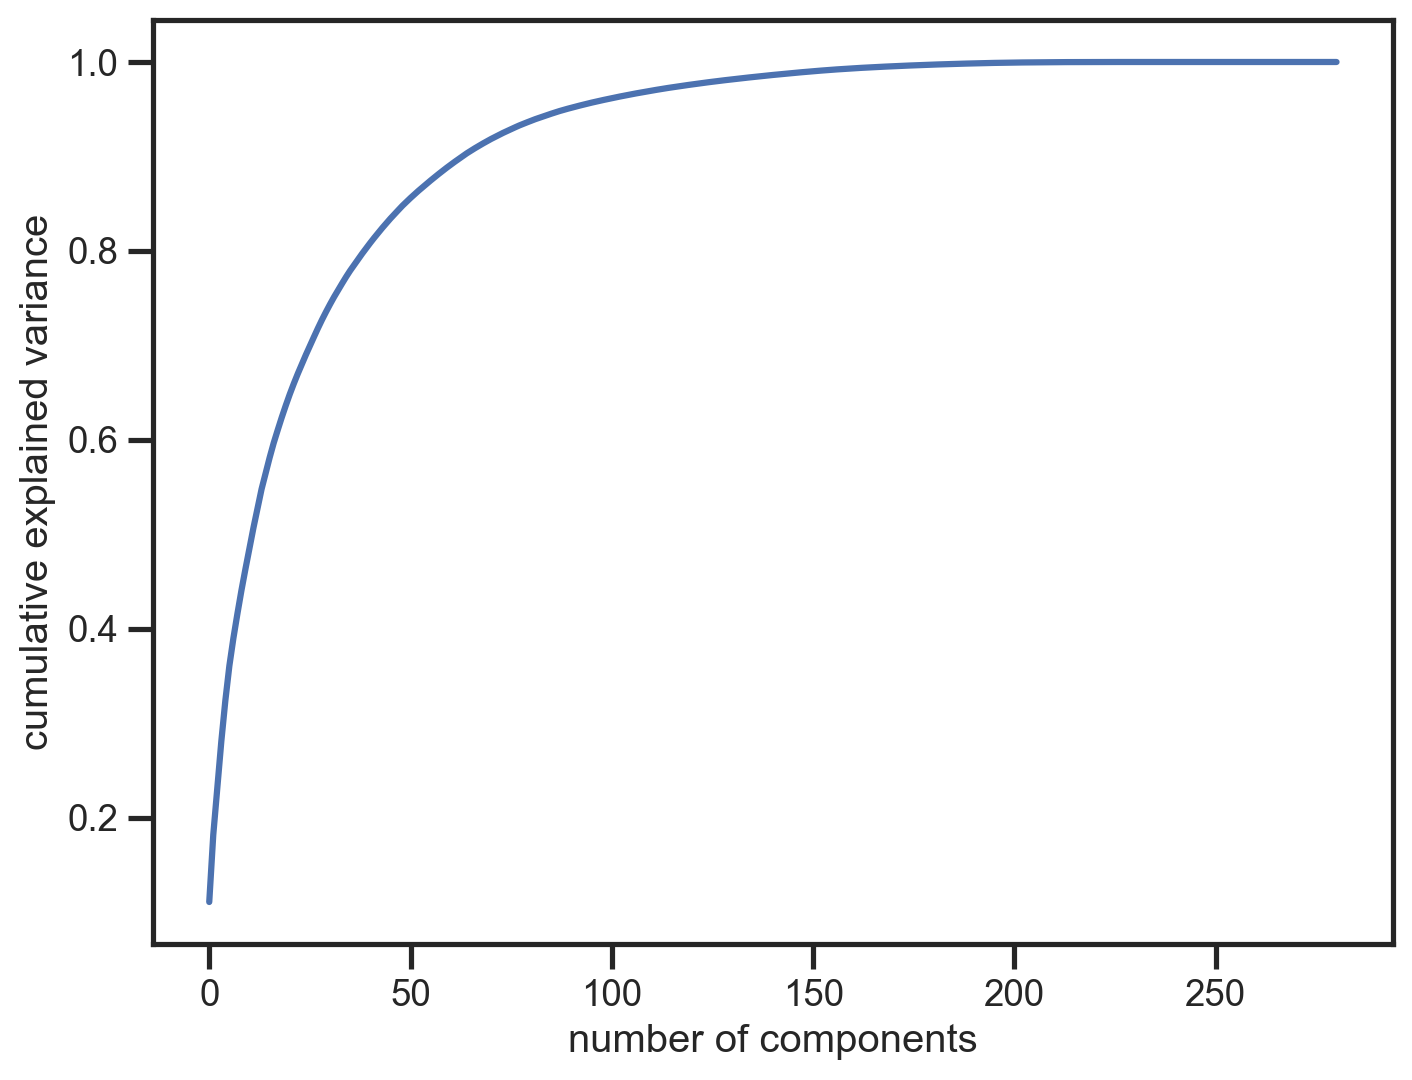

In [114]:
plt.plot(np.cumsum(X_pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

 n_components=0.95. This will select the number of components while preserving 95% of the variability in the data.

In [115]:
X_pca = PCA(n_components=0.95,random_state=seed)
X_pca.fit(X_train_preprocessed)
pca_X = X_pca.transform(X_train_preprocessed)
pca_test = X_pca.transform(X_test_preprocessed)

In [116]:
pca_X.shape

(52641, 90)

In [117]:
components = []
for i in range(1,pca_X.shape[1]+1):
    components.append('component'+str(i))    

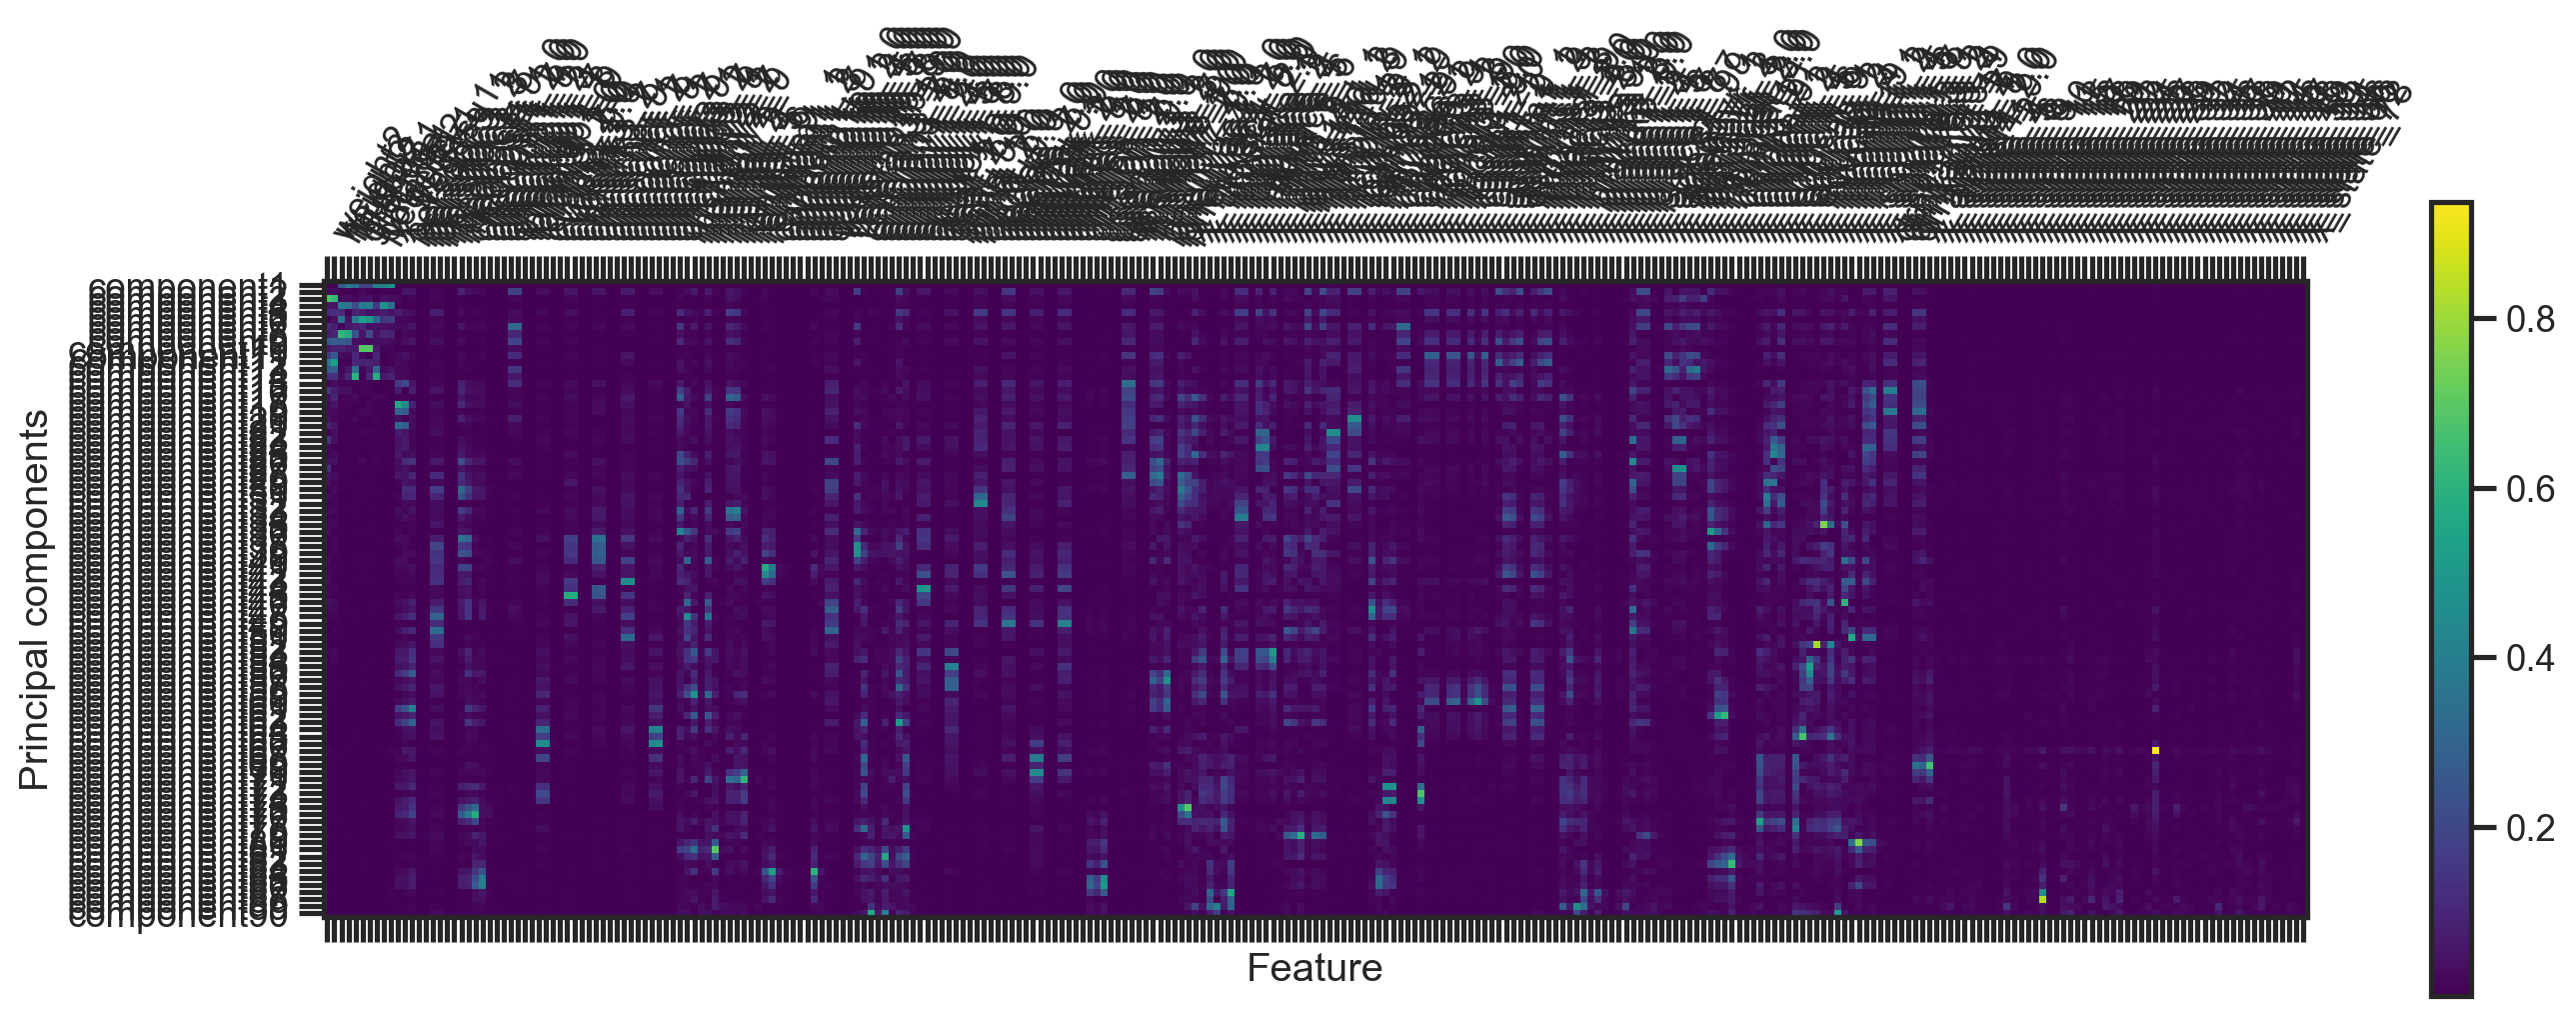

In [118]:
## The Influence of the Features in the Components
plt.matshow(np.abs(X_pca.components_)[:pca_X.shape[1]], cmap='viridis')
plt.yticks(range(pca_X.shape[1]), components)
plt.colorbar()
plt.xticks(range(len(X_train_preprocessed.columns)),
           X_train_preprocessed.columns, rotation=60, ha='left')
plt.xlabel("Feature")
plt.ylabel("Principal components");

### Model fitting on PCA components

In [119]:
def model_selection(xtrain,xtest,ytrain,ytest):
    models = {
        'logistic_regression':{
            'model':LogisticRegression()
        },
        'random_forest':{
            'model':RandomForestClassifier(random_state=seed)
        },
       'catboost':{
            'model':CatBoostClassifier(verbose=False,random_state=seed)
        },
        'decisontree':{
            'model': DecisionTreeClassifier(random_state=seed)
        },
        'extratree':{
            'model': ExtraTreesClassifier(random_state=seed)
        }
    }

    scores = []
    for model_name, config in models.items():
        start = time.time()
        config['model'].fit(xtrain, ytrain)
        y_pred = config['model'].predict(xtest) 
        train_score = config['model'].score(xtrain, ytrain)
        balanced_acc = balanced_accuracy_score(ytest, y_pred)
        acc = accuracy_score(ytest, y_pred)
        f1score = f1_score(ytest, y_pred, average='macro')
        end = time.time()
        elasped_time = end - start
        scores.append({
            'model': model_name,
            'train_score':train_score,
            'balanced_acc':balanced_acc,
            'acc':acc,
            'f1score':f1score,
            'time_taken':elasped_time})

    return pd.DataFrame(scores,columns=['model','train_score','balanced_acc','acc','f1score','time_taken'])

In [120]:
result_pca= model_selection(pca_X, pca_test, y_train, y_test)

In [121]:
result_pca.sort_values(by='f1score',ascending=False)

,model,train_score,balanced_acc,acc,f1score,time_taken
0,logistic_regression,0.719952,0.717036,0.716435,0.716344,0.515144
2,catboost,0.811516,0.715453,0.715143,0.715141,40.648611
1,random_forest,1.000000,0.700881,0.700403,0.700362,87.630943
4,extratree,1.000000,0.699215,0.698959,0.698959,35.929128
3,decisontree,1.000000,0.613525,0.613783,0.613537,15.703328


Run the entire dataset (`X_train_preprocessed`) on different models

In [122]:
result_whole = model_selection(X_train_preprocessed, X_test_preprocessed, y_train, y_test)

In [124]:
result_whole.sort_values(by='f1score',ascending=False)

,model,train_score,balanced_acc,acc,f1score,time_taken
2,catboost,0.782451,0.717876,0.717575,0.717573,20.940759
0,logistic_regression,0.722251,0.717079,0.716511,0.716437,4.486659
4,extratree,1.000000,0.707165,0.706937,0.706936,63.724333
1,random_forest,1.000000,0.707024,0.706633,0.706619,23.304242
3,decisontree,1.000000,0.617926,0.618114,0.617935,7.333385


### Automated Feature Selection Using Recursive Feature Elimination with Cross-Validation (RFECV)

In [125]:
model = LogisticRegression()
ref_selector = RFECV(model, step=1, cv=10)

In [126]:
ref_selector.fit(X_train_preprocessed, y_train)

RFECV(cv=10, estimator=LogisticRegression())

In [129]:
n_scores = len(ref_selector.cv_results_["mean_test_score"])
n_scores

281

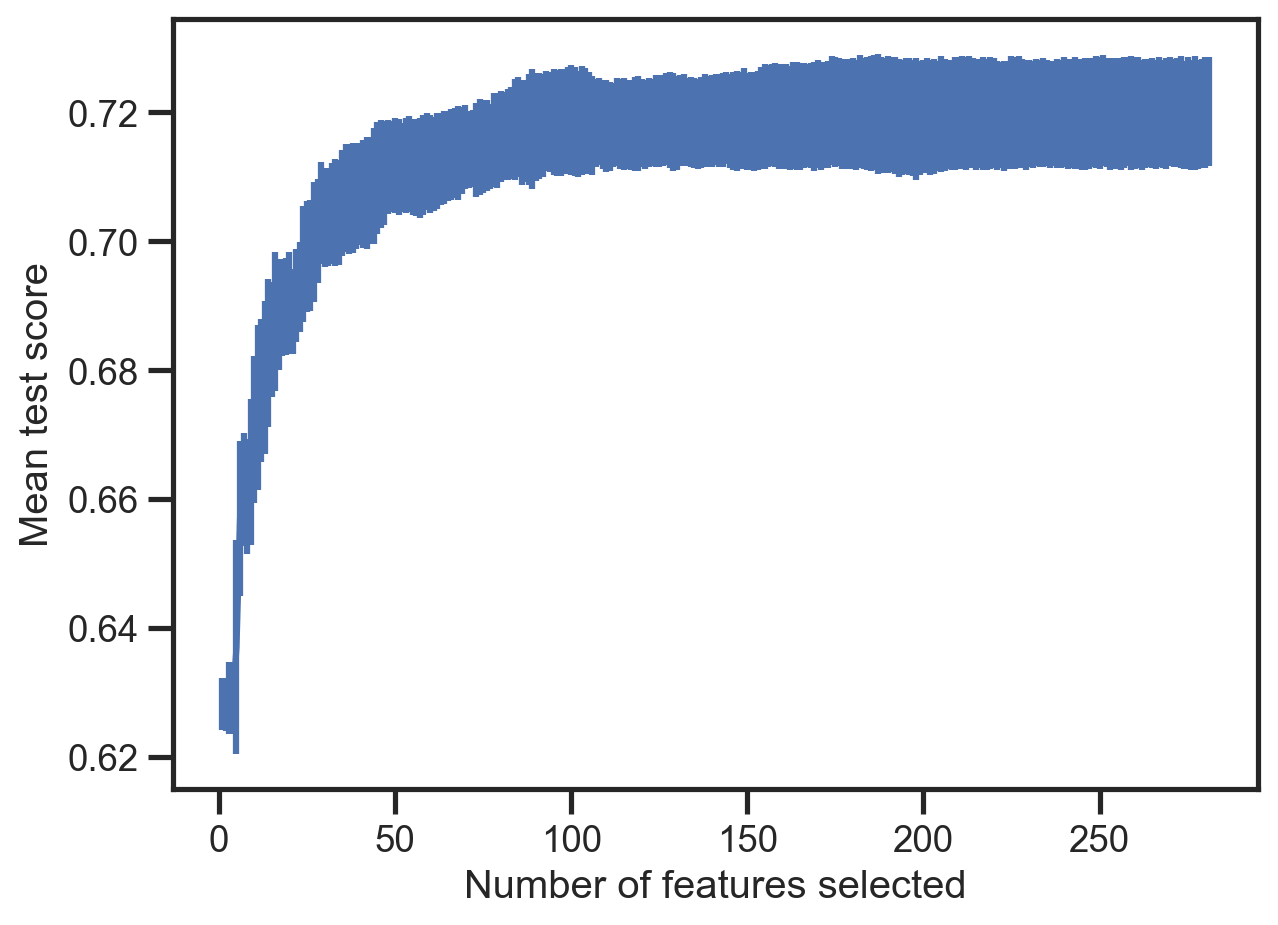

In [130]:
fig, ax = plt.subplots(figsize=(7,5))
ax.errorbar(
    range(1, n_scores+1),
    ref_selector.cv_results_["mean_test_score"],
    yerr=ref_selector.cv_results_["std_test_score"],
)
ax.set_xlabel("Number of features selected")
ax.set_ylabel("Mean test score");

In [131]:
pd.DataFrame(ref_selector.cv_results_["mean_test_score"],range(1, n_scores+1)).sort_values(by=0,ascending=False).head()

,0
174,0.720256
251,0.720237
270,0.720199
281,0.720123
249,0.720123


In [132]:
# Get the indices of the top performing features
top_features_idx = ref_selector.get_support(indices=True)

# Get the names of the top performing features
top_features_names = X_train_preprocessed.columns[top_features_idx]

# Print the top performing features
print("Top performing features:")
print(len(top_features_names))


Top performing features:
174


### Model fitting and prediction on top selected features by REFCV

In [133]:
result_refcv_full = model_selection(X_train_preprocessed[top_features_names], X_test_preprocessed[top_features_names], y_train, y_test)

In [134]:
result_refcv_full.sort_values(by='f1score',ascending=False)

,model,train_score,balanced_acc,acc,f1score,time_taken
2,catboost,0.766798,0.720466,0.720158,0.720156,27.874227
0,logistic_regression,0.721947,0.717139,0.716587,0.716521,2.683458
1,random_forest,0.998784,0.702191,0.701998,0.701995,24.820584
4,extratree,0.998784,0.697474,0.697439,0.697400,47.459893
3,decisontree,0.998784,0.623309,0.623585,0.623323,4.161237


### Model fitting on top 44 selected features using SelectKbest

In [135]:
selector = SelectKBest(f_classif, k=174).fit(X_train_preprocessed, y_train)
X_sel = selector.transform(X_train_preprocessed)
auto_select = pd.DataFrame(X_sel, columns=selector.get_feature_names_out()).columns

In [136]:
auto_select = auto_select.tolist()

In [137]:
result_selectkbest = model_selection(X_train_preprocessed[auto_select], X_test_preprocessed[auto_select], y_train, y_test)

### Comparing metrics between whole dataset, pca components, slekectKbest and REFCV features

In [138]:
result_selectkbest.sort_values(by='f1score',ascending=False)

,model,train_score,balanced_acc,acc,f1score,time_taken
2,catboost,0.772250,0.719112,0.718866,0.718866,18.415511
0,logistic_regression,0.721928,0.716689,0.716131,0.716062,2.158529
1,random_forest,0.999943,0.706225,0.705949,0.705949,23.054118
4,extratree,0.999943,0.703266,0.703138,0.703125,30.134546
3,decisontree,0.999943,0.624758,0.624953,0.624769,2.050619


In [139]:
result_whole.sort_values(by='f1score',ascending=False)

,model,train_score,balanced_acc,acc,f1score,time_taken
2,catboost,0.782451,0.717876,0.717575,0.717573,20.940759
0,logistic_regression,0.722251,0.717079,0.716511,0.716437,4.486659
4,extratree,1.000000,0.707165,0.706937,0.706936,63.724333
1,random_forest,1.000000,0.707024,0.706633,0.706619,23.304242
3,decisontree,1.000000,0.617926,0.618114,0.617935,7.333385


In [140]:
result_refcv_full.sort_values(by='f1score',ascending=False)

,model,train_score,balanced_acc,acc,f1score,time_taken
2,catboost,0.766798,0.720466,0.720158,0.720156,27.874227
0,logistic_regression,0.721947,0.717139,0.716587,0.716521,2.683458
1,random_forest,0.998784,0.702191,0.701998,0.701995,24.820584
4,extratree,0.998784,0.697474,0.697439,0.697400,47.459893
3,decisontree,0.998784,0.623309,0.623585,0.623323,4.161237


In [141]:
def model_pipe(est):
    """ """
    pipe = Pipeline(
        steps=[
            ("pp", preprocessor_pipe()),
            # ("featsel", SelectKBest(f_classif, k=47)),
            ("classif", est)
        ]
    ).set_output(transform="pandas")

    return pipe
def evaluate(model):
    scores = []
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test) 
    train_score = model.score(X_train, y_train)
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    f1score = f1_score(y_test, y_pred, average='weighted')
    scores.append({
        'model': model['classif'].__class__.__name__,
        'train_score':train_score,
        'balanced_acc':balanced_acc,
        'acc':acc,
        'f1score':f1score})

    return pd.DataFrame(scores,columns=['model','train_score','balanced_acc','acc','f1score'])

In [336]:
# Instantiate model
cat = model_pipe(CatBoostClassifier(verbose=False))

In [300]:
# Extra trees model
cat_optuna = model_pipe(CatBoostClassifier(iterations=2000, objective='Logloss',colsample_bylevel=0.0581586708938362, depth=9, boosting_type='Plain',
                bootstrap_type='MVS', verbose=False,learning_rate=0.01))
evaluate(cat_optuna)

,model,train_score,balanced_acc,acc,f1score
0,CatBoostClassifier,0.790923,0.720117,0.719778,0.719752


In [299]:
evaluate(cat)

,model,train_score,balanced_acc,acc,f1score
0,CatBoostClassifier,0.783097,0.717312,0.716967,0.716938


In [157]:
kf = KFold(n_splits=5, random_state=seed, shuffle=True)
cross_val_score(cat,X,y, cv=kf).mean()

0.721376338953004

In [302]:
cat_optuna

Pipeline(steps=[('pp',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['weight2', 'height3',
                                                   'ftjuda2_', 'frutda2_',
                                                   'grenda1_', 'frnchda_',
                                                   'potada1_', 'vegeda2_',
                                                   'x_frutsu1', 'x_vegesu1']),
                                                 ('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='infrequent_if_exist',
                                                                                 sparse_o...
                                                   'chckdny2', 'marital',
                                                   'renthom1', 'cpdemo1b',
                                                   'veteran3', 'employ1',
                                                   'deaf', 'blind', 'decide',
                                                   'diffwalk', 'diffdres',
                                                   'diffalon', 'usenow3',
                                                   'flushot7', 'pneuvac4',
                                                   'x_metstat', 'x_urbstat',
                                                   'x_imprace', 'x_rfhlth',
                                                   'x_phys14d', 'x_hlthpln',
                                                   'x_hcvu652', ...])],
                                   verbose_feature_names_out=False)),
                ('classif',
                 <catboost.core.CatBoostClassifier object at 0x00000159396E6AA0>)])

In [304]:
kf = KFold(n_splits=5, random_state=seed, shuffle=True)
x = cross_val_score(cat_optuna ,X,y, cv=kf)

In [306]:
x.mean()

0.7229568329473028

# Preparing Test data

In [337]:
test = pd.read_csv(r'C:\Users\kings\OneDrive - MMU\Desktop\bip-mental-health-technical-challenge\HDRUK_GROUP_4\test_set.csv')

In [338]:
test.head()

,X_STATE,FMONTH,IDATE,IMONTH,IDAY,IYEAR,DISPCODE,SEQNO,X_PSU,CTELENM1,...,X_VEGRES1,X_FRUTSU1,X_VEGESU1,X_FRTLT1A,X_VEGLT1A,X_FRT16A,X_VEG23A,X_FRUITE1,X_VEGETE1,Record_ID
0,26,2,3162021,3,16,2021,1100,2021002830,2021002830,NaN,...,1,24.0,201.0,2,1,1,1,0,0,169293
1,5,5,5162021,5,16,2021,1200,2021003616,2021003616,NaN,...,0,NaN,NaN,9,9,1,1,1,1,24215
2,53,7,8132021,8,13,2021,1100,2021009215,2021009215,NaN,...,1,157.0,100.0,1,1,1,1,0,0,408054
3,20,1,2112021,2,11,2021,1100,2021004848,2021004848,NaN,...,1,110.0,417.0,1,1,1,1,0,0,108467
4,49,5,6292021,6,29,2021,1100,2021003468,2021003468,NaN,...,1,71.0,429.0,2,1,1,1,0,0,375464


In [339]:
test.shape

(20000, 287)

In [340]:
columns_to_drop = ['IDATE', 'FMONTH', 'IDAY',
                     'SEQNO', 'X_PSU', 'CTELENM1',
                     'STATERE1', 'CELPHON1', 'COLGSEX', 'NUMADULT',
                      'NUMMEN', 'NUMWOMEN', 'RESPSLCT',
                     'SAFETIME', 'CTELNUM1', 'CELLFON5', 'CSTATE1',
                     "LANDLINE", "HHADULT", "CELLSEX", "LANDSEX", "BPMEDS",
                     "CHOLMED3", "ASTHNOW", "ARTHEXER", "ARTHEDU", "LMTJOIN3",
                     "ARTHDIS2", "NUMHHOL3", "NUMPHON3", "AVEDRNK3", "DRNK3GE5",
                     "MAXDRNKS", "FLSHTMY3", "IMFVPLA2", "FRENCHF1", "HAVECFS",
                     "WORKCFS", 'TOLDHEPC', "TRETHEPC", "PRIRHEPC", "MEDSHEPB",
                     "HPVADSHT", "LCSFIRST", "LCSLAST", "LCSNUMCG", "HOWLONG",
                     "CRVCLCNC", "PSATIME1", "PCPSARS2", "PCSTALK", "HADSIGM4",
                     "COLNTES1", "SIGMTES1", "LASTSIG4", "COLNCNCR", "VCLNTES1",
                     "STOLTEST", "BLDSTFIT", "SDNATES1", "CSRVSUM", "CSRVRTRN", "CSRVINST",
                     "CSRVCTL2", "CSRVCLIN", "CSRVPAIN", "CSRVCTL2", "HOMBPCHK",
                     "HOMRGCHK", "WHEREBP", "SHAREBP", "DRADVISE", "CDASSIST", "CDHELP", "CDHOUSE",
                     "CDSOCIAL", "CDDISCUS", "CRGVREL4", "CRGVLNG1", "CRGVHRS1", "CRGVPRB3",
                     "CRGVALZD", "CRGVPER1", "CRGVHOU1" , "CRGVEXPT", "USEMRJN3", "LASTSMK2", "STOPSMK2",
                     "GUNLOAD", "LOADULK2", "RCSRLTN2", "CASTHDX2", "CASTHNO2", "QSTVER",
                     "QSTLANG", "MSCODE", "X_STSTR", "X_STRWT", "X_RAWRAKE", "X_WT2RAKE", "X_CHISPNC",
                     "X_CRACE1", "X_CPRACE1", "CAGEG", "X_CLLCPWT", "X_DUALUSE", "X_DUALCOR",
                     "X_LLCPWT2", "X_LLCPWT", "X_MRACE1", "X_HISPANC", "X_RACE", "X_RACEG21", "X_RACEGR3", "X_RACEPRV",
                     "X_AGEG5YR", "X_AGE80", "X_AGE_G", "HTIN4", "HTM4", "WTKG3", "X_BMI5", "X_RFSMOK3", "X_CURECI1",
                     "DROCDY3_", "X_RFBING5", "X_DRNKWK1", "X_RFDRHV7", "X_MISFRT1", "X_MISVEG1",
                     "X_FRTRES1", "X_VEGRES1", "X_FRTLT1A", "X_VEGLT1A", "X_FRT16A", "X_VEG23A", "X_FRUITE1", "X_VEGETE1",
                     "GENHLTH", "PHYSHLTH",  "PRIMINSR", "EXERANY2","BPHIGH6",   "CHOLCHK3", "CVDINFR4",  "CVDCRHD4", "ASTHMA3",
                     "HAVARTH5", "BIRTHSEX", "EDUCA", "CHILDREN", "INCOME3", "SMOKE100",
                     "ECIGNOW1", "ALCDAY5", "HIVTST7", "FRUIT2",   "FRUITJU2","FVGREEN1",  "POTATOE1", "VEGETAB2", "Record_ID"]

In [341]:
test = test.drop(columns=columns_to_drop)

In [342]:
test.shape

(20000, 126)

In [343]:
test.columns = test.columns.str.lower()

### using the features from the X_train to wrok with

In [344]:
test = test[X.columns]

In [345]:
test.isnull().sum().sort_values(ascending=False)

x_rfchol3    2773
toldhi3      2748
x_vegesu1    2541
x_frutsu1    2161
vegeda2_     2014
             ... 
x_totinda       0
x_rfhype6       0
x_cholch3       0
x_ltasth1       0
x_hlthpln       0
Length: 63, dtype: int64

In [346]:
test_columns_with_nulls = null_counts(test)

Value counts for column 'x_rfchol3' (Null Count: 2773):
1.0    9791
2.0    7288
NaN    2773
9.0     148
Name: x_rfchol3, dtype: int64

Value counts for column 'toldhi3' (Null Count: 2748):
2.0    9815
1.0    7289
NaN    2748
7.0     139
9.0       9
Name: toldhi3, dtype: int64

Value counts for column 'x_vegesu1' (Null Count: 2541):
NaN        2541
157.0       395
200.0       363
143.0       308
100.0       266
           ... 
796.0         1
338.0         1
15003.0       1
1538.0        1
642.0         1
Name: x_vegesu1, Length: 810, dtype: int64

Value counts for column 'x_frutsu1' (Null Count: 2161):
100.0     2337
NaN       2161
200.0     1978
300.0      911
43.0       806
          ... 
707.0        1
158.0        1
3300.0       1
287.0        1
602.0        1
Name: x_frutsu1, Length: 322, dtype: int64

Value counts for column 'vegeda2_' (Null Count: 2014):
100.0    6216
NaN      2014
200.0    1764
43.0     1487
29.0     1244
         ... 
229.0       1
213.0       1
63.0        1


In [347]:
len(test_columns_with_nulls)

33

In [348]:
# Identify the data types of columns to distinguish between continuous and categorical
continuous_columns = []
categorical_columns = []

for column in test.columns[test.columns.isin(test_columns_with_nulls)]:
    if test[column].nunique() <= 4:
        # for null columns, columns with less than or equal to 4 unique values are categorical
        categorical_columns.append(column)
    else:
        continuous_columns.append(column)

In [349]:
print(
    f"number of contious columns with missing values = {len(continuous_columns)}\n"
      f"number of contious columns with missing values = {len(categorical_columns)}"
      )

number of contious columns with missing values = 14
number of contious columns with missing values = 19


In [350]:
replacement_values_dict = fill_null_values(test, test_columns_with_nulls)

Columns and Method to replace missing values
'toldhi3': (Replaced with Mode)
'veteran3': (Replaced with Mode)
'deaf': (Replaced with Mode)
'blind': (Replaced with Mode)
'decide': (Replaced with Mode)
'diffwalk': (Replaced with Mode)
'diffdres': (Replaced with Mode)
'diffalon': (Replaced with Mode)
'flushot7': (Replaced with Mode)
'pneuvac4': (Replaced with Mode)
'x_metstat': (Replaced with Mode)
'x_urbstat': (Replaced with Mode)
'x_rfchol3': (Replaced with Mode)
'x_michd': (Replaced with Mode)
'x_drdxar3': (Replaced with Mode)
'x_lmtact3': (Replaced with Mode)
'x_lmtwrk3': (Replaced with Mode)
'x_bmi5cat': (Replaced with Mode)
'x_aidtst4': (Replaced with Mode)
'renthom1': (Replaced with Median)
'cpdemo1b': (Replaced with Median)
'employ1': (Replaced with Mean)
'weight2': (Replaced with Median)
'height3': (Replaced with Median)
'usenow3': (Replaced with Median)
'ftjuda2_': (Replaced with Median)
'frutda2_': (Replaced with Median)
'grenda1_': (Replaced with Median)
'frnchda_': (Replaced 

In [351]:
# Replace null values in the DataFrame with the respective mode/median/mean
test.fillna(replacement_values_dict, inplace=True)

In [352]:
test.isnull().sum().any()

False

In [353]:
test.shape

(20000, 63)

In [354]:
# test = standardize_values(test)

In [327]:
preds = cat_optuna.predict(test)

In [328]:
preds

array([1, 0, 0, ..., 0, 1, 0], dtype=int64)

In [330]:
sample = pd.read_csv(r'C:\Users\kings\OneDrive - MMU\Desktop\bip-mental-health-technical-challenge\skinny_unanswered_set.csv')
sample.head()

,Record_ID,Outcome
0,169293,NaN
1,24215,NaN
2,408054,NaN
3,108467,NaN
4,375464,NaN


In [331]:
sample['Outcome'] = preds

In [332]:
sample.head()

,Record_ID,Outcome
0,169293,1
1,24215,0
2,408054,0
3,108467,1
4,375464,1


In [333]:
# Replace the object values ('Pos','Neg') in the Outcome column with integer (0,1)
sample['Outcome'] = sample['Outcome'].replace({0:'Neg',1:'Pos'})

# Display the updated value
sample['Outcome'].value_counts()

Neg    10922
Pos     9078
Name: Outcome, dtype: int64

In [335]:
sample.to_csv('catoptunasubmission3.csv',index=False)

In [329]:
print(classification_report(y_test, cat_optuna.predict(X_test)))

              precision    recall  f1-score   support

           0       0.70      0.74      0.72      6455
           1       0.74      0.70      0.72      6706

    accuracy                           0.72     13161
   macro avg       0.72      0.72      0.72     13161
weighted avg       0.72      0.72      0.72     13161

